# 期末專題－浣熊(raccoon)與袋鼠(kangaroo)的分類與位置YOLO3辨識模型
#### 參考 PASCAL VOC 程式與資料集進行修改，改為分辨浣熊(raccoon)與袋鼠(kangaroo)的分類與位置辨識模型，原PASCAL VOC程式碼參考可至https://arleyzhang.github.io/articles/1dc20586/


### YOLO 基本訓練步驟
1.把資料集轉換成需要的格式

2.讀取轉換好的檔案

3.基於 pretrained 好的權重單獨訓練 output layer (optional)

4.Finetune 整個模型

#### 本次期末專案目標
1.訓練一個模型同時能辨識出浣熊 (raccoon) 與袋鼠 (kangaroo) 的類別與位置/或自行定義問題。

2.使用預訓練模型以及其在影像辨識中的作用，運用模型，辨識驗證資料集 (test data) 的效果，並透過指標判斷模型的優劣， 觀察模型辨識出的結果與後續可以往哪一方面改善
把影片 (檢視範例內為範例影片) 中的袋鼠與浣熊的位置找出來 (專題結果可自行找影片進行)

### 1.載入需要的元件

In [38]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [39]:
import os
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import xml.etree.ElementTree as ET

### 2.建立專案，準備資料

建立專案並使用現有的yolo3預訓練過的模型


In [40]:
#需要安裝 keras 2.2.4 的版本
#!pip install keras==2.2.4 

In [41]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


切換至yolo3所在的資料夾

In [42]:
%cd '/content/gdrive/My Drive/keras-yolo3'

/content/gdrive/My Drive/keras-yolo3


轉換yolo3所提供的權重，轉換成keras可使用的格式

In [43]:
#  載入 yolov3 Keras模型與權重
if not os.path.exists("model_data/yolo.h5"):                    # 載入 yolov3 Keras模型 (hdf5存储格式)
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

if not os.path.exists("model_data/yolo_weights.h5"):             # 載入 yolov3 的網路權重
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Model exist
Pretrained weights exists


下載本次要使用的浣熊 (raccoon) 與袋鼠 (kangaroo) 資料集

In [44]:
os.makedirs("train_data", exist_ok=True)
os.chdir(r'train_data')

print(os.getcwd())
# download datasets
if not os.path.exists("raccoon_dataset"):
    !git clone https://github.com/experiencor/raccoon_dataset.git  
else:
    print("raccoon_dataset exists")

if not os.path.exists("kangaroo"):
    !git clone https://github.com/experiencor/kangaroo.git  
else:
    print("kangaroo exists")
    
os.chdir("..")

/content/gdrive/My Drive/keras-yolo3/train_data
raccoon_dataset exists
kangaroo exists


將資料集分成 train、validation、test 三個資料夾，以 train 與 validation 來做訓練 

In [45]:
for root,dirs,files in os.walk('train_data/raccoon_dataset/images'):
    print('raccoon jpg 檔數量:', len(files))
for root_2,dirs_2,files_2 in os.walk('train_data/kangaroo/images'):
    print('kangaroo jpg 檔數量:', len(files_2))
files.extend(files_2)
print('所有 jpg 檔數量:', len(files))
jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
np.random.seed(10210)
train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.8), replace=False) #train資料
print(train_index[0:5])
#print(len(train_index))

non_train = np.setdiff1d(jpg_ids, train_index) #剩下的資料再切分成valid和test
#print(len(non_train))

np.random.seed(10210)
val_index = np.random.choice(non_train, size=int(len(non_train)*0.7), replace=False) #valid資料
print(val_index[0:5])
#print(len(val_index))
test_index = np.setdiff1d(non_train, val_index) #test資料
#print(len(test_index))

raccoon jpg 檔數量: 200
kangaroo jpg 檔數量: 164
所有 jpg 檔數量: 364
['00156' 'raccoon-105' 'raccoon-86' '00171' '00108']
['raccoon-178' 'raccoon-4' 'raccoon-72' '00096' 'raccoon-10']


把切分後的資料及位置儲存起來
記憶體容量問題所以不直接在訓練時載入所有資料集才進行訓練，
而是先切出train、validation、test資料集再分別載入

In [46]:
if not os.path.exists("train"):

    !mkdir train val test
    # train index
    train_txt = open('train/train.txt', 'w')
    print("save train index at train/train.txt")       
    for train_id in train_index : 
        train_txt.write('%s' %(train_id))
        train_txt.write('\n')
    train_txt.close()

    # val index
    val_txt = open('val/val.txt', 'w')
    print("save val index at val/val.txt")       
    for val_id in val_index : 
        val_txt.write('%s' %(val_id))
        val_txt.write('\n')
    val_txt.close()

    # test index
    test_txt = open('test/test.txt', 'w')
    print("save test index at test/test.txt")       
    for test_id in test_index : 
        test_txt.write('%s' %(test_id))
        test_txt.write('\n')
    test_txt.close()
else:
    print("index data exists")

save train index at train/train.txt
save val index at val/val.txt
save test index at test/test.txt


從下載的資料集複製需要的資料格式到自己的訓練資料集

In [47]:
from distutils.dir_util import copy_tree
if not os.path.exists("train_data/Annotations"):
    os.mkdir("train_data/Annotations")
    copy_tree("train_data/raccoon_dataset/annotations", "train_data/Annotations")
    copy_tree("train_data/kangaroo/annots", "train_data/Annotations")
else:
    print("Annotations is exist")

Annotations is exist


建立資料類別

In [48]:
# 資料類別
classes = ["kangaroo", "raccoon"]
# save class
if not os.path.exists("classes.txt"):
    class_txt = open('classes.txt', 'w')
        
    for class_id in classes : 
        class_txt.write('%s' %(class_id))
        class_txt.write('\n')
    class_txt.close()
else:
    print("class exists")

class exists


資料格式轉換需要的程式

In [49]:
# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(image_id, list_file):
    in_file = open('train_data/Annotations/%s.xml'%(image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1: 
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), 
             int(xmlbox.find('ymin').text), 
             int(xmlbox.find('xmax').text),
             int(xmlbox.find('ymax').text))
        list_file_str = " " + ",".join([str(a) for a in b]) + ',' + str(cls_id)
        list_file.write(list_file_str)

In [50]:
sets = ['train', 'val', 'test']
is_retrain_new_data = True
if is_retrain_new_data:
    for image_set in sets:
        image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
        annotation_path = '%s_labels.txt'%(image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
    # transform data format
        for image_id in image_ids: 
            if 'raccoon' in image_id:
                list_file.write('train_data/raccoon_dataset/images/%s.jpg' %(image_id))
            else:
                list_file.write('train_data/kangaroo/images/%s.jpg' %(image_id))
            convert_annotation(image_id, list_file)
            list_file.write('\n')
        list_file.close()
else:
    print("Already converted annotation")
    

save annotation at train_labels.txt
save annotation at val_labels.txt
save annotation at test_labels.txt


### 3.訓練模型

In [51]:
# 需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper
from tensorflow.python.keras.optimizers import TFOptimizer

參數設定

In [52]:
# 模型參數設定 ，設定logging, checkpoint, reduce_lr, early_stopping   
annotation_path = 'train_labels.txt' # 轉換好格式的標註檔案
val_annotation_path = 'val_labels.txt' 
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
num_val = len(val_index)
num_train = len(train_index)

with open(annotation_path) as f:
    lines_train = f.readlines()
with open(val_annotation_path) as f:
    lines_val = f.readlines()

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in 

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


建立兩個不同的訓練階段

In [53]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    h1 = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    h2 = model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Train on 291 samples, val on 51 samples, with batch size 32.
Epoch 1/50
9/9 [==============================] - 30s 3s/step - loss: 5573.2576 - val_loss: 2784.5515
Epoch 2/50
9/9 [==============================] - 23s 3s/step - loss: 1718.7061 - val_loss: 926.1356
Epoch 3/50
9/9 [==============================] - 24s 3s/step - loss: 678.2630 - val_loss: 487.5961
Epoch 4/50
9/9 [==============================] - 14s 2s/step - loss: 378.5797 - val_loss: 291.9294
Epoch 5/50
9/9 [==============================] - 18s 2s/step - loss: 258.3670 - val_loss: 217.8311
Epoch 6/50
9/9 [==============================] - 24s 3s/step - loss: 204.9380 - val_loss: 173.9418
Epoch 7/50
9/9 [==============================] - 25s 3s/step - loss: 170.9219 - val_loss: 141.8791
Epoch 8/50
9/9 [==============================] - 24s 3s/step - loss: 147.9388 - val_loss: 130.9959
Epoch 9/50
9/9 [==============================] - 24s 3s/step - loss: 131.0649 - val_loss: 119.3920
Epoch 10/50
9/9 [===================

第一層stable model loss和val loss

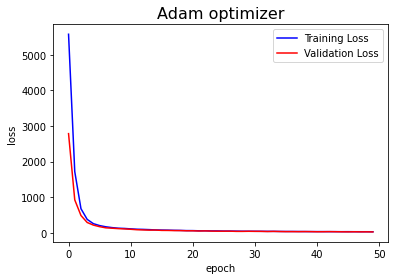

In [54]:
import matplotlib.pyplot as plt
# 第一層stable model loss和val loss
epoch = np.arange(0 , len(h1.history['loss']))

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , h1.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , h1.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

第二層fine-tune model loss和val loss

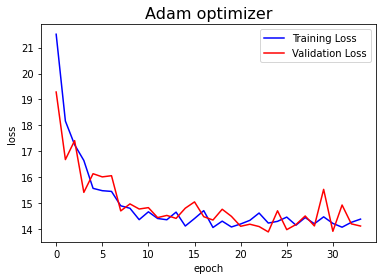

In [55]:
import matplotlib.pyplot as plt
# 第二層fine-tune model loss和val loss
epoch = np.arange(0 , len(h2.history['loss']))

plt.title('Adam optimizer' , fontsize = 16)
plt.xlabel('epoch' , fontsize = 10)
plt.ylabel('loss' , fontsize = 10)

plt.plot(epoch , h2.history['loss'] , color='b', label='Training Loss')
plt.plot(epoch , h2.history['val_loss'] , color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 4.測試模型

圖片偵測

In [56]:
# 進行圖片測試
from yolo import YOLO
from PIL import Image
yolo_model = YOLO(model_path='logs/000/trained_weights_final.h5', classes_path=classes_path)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.


In [57]:
#取得測試圖片
test_image_ids = open('test/test.txt').read().strip().split()

In [58]:
def detect_data(image_id):
    if 'raccoon' in image_id:
        test_fig_str = '/content/gdrive/My Drive/keras-yolo3/train_data/raccoon_dataset/images/%s.jpg' %(image_id)
    else:
        test_fig_str = '/content/gdrive/My Drive/keras-yolo3/train_data/kangaroo/images/%s.jpg' %(image_id)
    print(test_fig_str)
    image = Image.open(test_fig_str)   
    r_image = yolo_model.detect_image(image)
    return r_image

/content/gdrive/My Drive/keras-yolo3/train_data/kangaroo/images/00085.jpg
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.92 (78, 70) (510, 564)
kangaroo 0.96 (506, 193) (787, 554)
2.7406714509997983


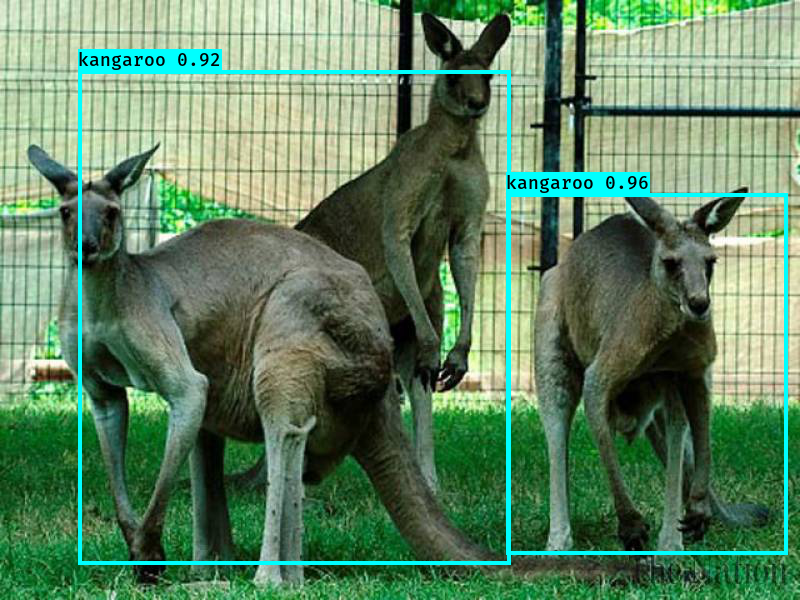

In [59]:
detect_data(test_image_ids[3])

影片偵測

In [60]:
import cv2
from timeit import default_timer as timer
from tqdm import tqdm
from PIL import Image

In [61]:
def detect_video(yolo, video_path, output_path=""):
    # 透過OpenCv擷取影像　
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    # 取得影像的基本資訊
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC)) # 編碼格式
    video_fps       = vid.get(cv2.CAP_PROP_FPS) # 取得fps
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), # 每個 frame 的寬
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))) # 每個 frame 的高
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read() # 讀取每個 frame 
        # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
        image = Image.fromarray(frame)
        image = yolo.detect_image(image) # 直接使用 yolo.py 的 detect_image 函式
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        if isOutput:
            out.write(result)
    yolo.close_session()

In [62]:
def detect_video2(model,video_path_in,video_path_out):
  # 透過OpenCv擷取影像　
  video_reader = cv2.VideoCapture(video_path_in)

  # 取得影像的基本資訊
  nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
  frame_size = (int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH)),   # 每個 frame 的寬
                int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT)))  # 每個 frame 的高
  video_fps = int(video_reader.get(cv2.CAP_PROP_FPS))  # 取得fps
  
  # 設定影像的輸出
  video_writer = cv2.VideoWriter(video_path_out,cv2.VideoWriter_fourcc(*'MP4V'),video_fps,frame_size)

  # 迭代每一個frame來進行圖像偵測
  for i in tqdm(range(nb_frames)):
    return_value, frame = video_reader.read() # 讀取每個 frame 

    # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
    if return_value == True: 
      image = Image.fromarray(frame)
      image = model.detect_image(image)  # 直接使用 yolo.py 的 detect_image 函式
      result = np.asarray(image)
      cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.50, color=(255, 0, 0), thickness=2)
      video_writer.write(result)

  video_reader.release() # 釋放資源
  video_writer.release() # 釋放資源


In [63]:
detect_video2(yolo_model,'/content/gdrive/My Drive/keras-yolo3/video/Raccoon.mp4','/content/gdrive/My Drive/keras-yolo3/video/Raccoon_yolo3.mp4')

  0%|          | 3/1800 [00:00<03:32,  8.46it/s]

(416, 416, 3)
Found 0 boxes for img
0.05400563799958036
(416, 416, 3)
Found 0 boxes for img
0.05414945800021087
(416, 416, 3)
Found 0 boxes for img
0.052379523999661615


  0%|          | 5/1800 [00:00<03:04,  9.73it/s]

(416, 416, 3)
Found 0 boxes for img
0.05472579799970845
(416, 416, 3)
Found 0 boxes for img
0.05156562400043185
(416, 416, 3)
Found 0 boxes for img
0.04986152399942512
(416, 416, 3)


  0%|          | 9/1800 [00:00<02:31, 11.85it/s]

Found 0 boxes for img
0.05444059500041476
(416, 416, 3)
Found 0 boxes for img
0.05298508000032598
(416, 416, 3)
Found 0 boxes for img
0.051684308999938366
(416, 416, 3)
Found 0 boxes for img
0.053417897000144876


  1%|          | 13/1800 [00:00<02:14, 13.25it/s]

(416, 416, 3)
Found 0 boxes for img
0.05318735800028662
(416, 416, 3)
Found 0 boxes for img
0.05117883300044923
(416, 416, 3)
Found 0 boxes for img
0.05243920200064167


  1%|          | 15/1800 [00:01<02:10, 13.69it/s]

(416, 416, 3)
Found 0 boxes for img
0.054148221999639645
(416, 416, 3)
Found 0 boxes for img
0.05072070299956977
(416, 416, 3)
Found 0 boxes for img
0.06145258099968487


  1%|          | 19/1800 [00:01<02:05, 14.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.05511539700000867
(416, 416, 3)
Found 0 boxes for img
0.05260552999970969
(416, 416, 3)
Found 0 boxes for img
0.05237690400008432


  1%|          | 21/1800 [00:01<02:04, 14.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.053615368000464514
(416, 416, 3)
Found 0 boxes for img
0.051137928000571264
(416, 416, 3)
Found 0 boxes for img
0.050308562999816786
(416, 416, 3)


  1%|▏         | 25/1800 [00:01<02:02, 14.53it/s]

Found 0 boxes for img
0.05116112699943187
(416, 416, 3)
Found 0 boxes for img
0.05195019399980083
(416, 416, 3)
Found 0 boxes for img
0.05713072400067176
(416, 416, 3)


  2%|▏         | 27/1800 [00:01<02:00, 14.72it/s]

Found 0 boxes for img
0.054623996000373154
(416, 416, 3)
Found 0 boxes for img
0.05038195599991013
(416, 416, 3)
Found 0 boxes for img
0.05696666099993308
(416, 416, 3)
Found 0 boxes for img
0.05105234599977848


  2%|▏         | 31/1800 [00:02<02:00, 14.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.05213706500035187
(416, 416, 3)
Found 0 boxes for img
0.05655692100026499
(416, 416, 3)
Found 0 boxes for img
0.053785079000590486
(416, 416, 3)


  2%|▏         | 35/1800 [00:02<01:59, 14.81it/s]

Found 0 boxes for img
0.05451388599976781
(416, 416, 3)
Found 0 boxes for img
0.05623573100001522
(416, 416, 3)
Found 0 boxes for img
0.05102193899983831
(416, 416, 3)


  2%|▏         | 37/1800 [00:02<02:00, 14.61it/s]

Found 0 boxes for img
0.059730574999775854
(416, 416, 3)
Found 0 boxes for img
0.051489688999936334
(416, 416, 3)
Found 0 boxes for img
0.0543904880005357
(416, 416, 3)
Found 0 boxes for img
0.052161949999572244


  2%|▏         | 41/1800 [00:02<02:00, 14.58it/s]

(416, 416, 3)
Found 0 boxes for img
0.05567875999986427
(416, 416, 3)
Found 0 boxes for img
0.055045566000444524
(416, 416, 3)
Found 0 boxes for img
0.054596800000581425


  2%|▎         | 45/1800 [00:03<02:01, 14.50it/s]

(416, 416, 3)
Found 0 boxes for img
0.05399904400019295
(416, 416, 3)
Found 0 boxes for img
0.052246150000428315
(416, 416, 3)
Found 0 boxes for img
0.052228139999897394


  3%|▎         | 47/1800 [00:03<02:05, 13.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.05212522700003319
(416, 416, 3)
Found 0 boxes for img
0.05832933799956663
(416, 416, 3)
Found 0 boxes for img
0.05029651799941348


  3%|▎         | 51/1800 [00:03<02:02, 14.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.05393387999993138
(416, 416, 3)
Found 0 boxes for img
0.05201591900004132
(416, 416, 3)
Found 0 boxes for img
0.05048502199952054


  3%|▎         | 53/1800 [00:03<02:01, 14.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.05264015200009453
(416, 416, 3)
Found 0 boxes for img
0.05357441300020582
(416, 416, 3)
Found 0 boxes for img
0.05018926899992948
(416, 416, 3)


  3%|▎         | 57/1800 [00:03<01:57, 14.82it/s]

Found 0 boxes for img
0.05155594299958466
(416, 416, 3)
Found 0 boxes for img
0.04993372599983559
(416, 416, 3)
Found 0 boxes for img
0.050773957000274095
(416, 416, 3)


  3%|▎         | 59/1800 [00:04<01:58, 14.74it/s]

Found 0 boxes for img
0.05614571399928536
(416, 416, 3)
Found 0 boxes for img
0.05165796700021019
(416, 416, 3)
Found 0 boxes for img
0.05054601600022579
(416, 416, 3)
Found 0 boxes for img
0.05060664099983114


  4%|▎         | 63/1800 [00:04<01:57, 14.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.050317978999373736
(416, 416, 3)
Found 0 boxes for img
0.051183832999413426
(416, 416, 3)
Found 0 boxes for img
0.05038934399999562
(416, 416, 3)


  4%|▎         | 67/1800 [00:04<01:56, 14.86it/s]

Found 0 boxes for img
0.051904232000197226
(416, 416, 3)
Found 0 boxes for img
0.052317027000754024
(416, 416, 3)
Found 0 boxes for img
0.052399788000002445
(416, 416, 3)


  4%|▍         | 69/1800 [00:04<01:58, 14.65it/s]

Found 0 boxes for img
0.05796896000083507
(416, 416, 3)
Found 0 boxes for img
0.053241399000398815
(416, 416, 3)
Found 0 boxes for img
0.057816552000076626
(416, 416, 3)


  4%|▍         | 73/1800 [00:05<02:00, 14.38it/s]

Found 0 boxes for img
0.05420172400044976
(416, 416, 3)
Found 0 boxes for img
0.05400693699994008
(416, 416, 3)
Found 0 boxes for img
0.05494797200026369
(416, 416, 3)


  4%|▍         | 75/1800 [00:05<02:01, 14.23it/s]

Found 0 boxes for img
0.05390100399927178
(416, 416, 3)
Found 0 boxes for img
0.0573086879994662
(416, 416, 3)
Found 0 boxes for img
0.05361217800054874
(416, 416, 3)


  4%|▍         | 79/1800 [00:05<02:01, 14.18it/s]

Found 0 boxes for img
0.05170866299977206
(416, 416, 3)
Found 0 boxes for img
0.052521837999847776
(416, 416, 3)
Found 0 boxes for img
0.0505080299999463
(416, 416, 3)


  4%|▍         | 81/1800 [00:05<02:00, 14.24it/s]

Found 0 boxes for img
0.05474862900064181
(416, 416, 3)
Found 0 boxes for img
0.051631677999466774
(416, 416, 3)
Found 0 boxes for img
0.05399774899979093
(416, 416, 3)


  5%|▍         | 85/1800 [00:05<02:01, 14.10it/s]

Found 0 boxes for img
0.05616524600009143
(416, 416, 3)
Found 0 boxes for img
0.05493947600098181
(416, 416, 3)
Found 0 boxes for img
0.05246441500094079
(416, 416, 3)


  5%|▍         | 87/1800 [00:06<02:01, 14.11it/s]

Found 0 boxes for img
0.053391441999337985
(416, 416, 3)
Found 0 boxes for img
0.051424470999336336
(416, 416, 3)
Found 0 boxes for img
0.05428804300026968
(416, 416, 3)


  5%|▌         | 91/1800 [00:06<01:59, 14.33it/s]

Found 0 boxes for img
0.05302637000022514
(416, 416, 3)
Found 0 boxes for img
0.05136071899869421
(416, 416, 3)
Found 0 boxes for img
0.052146553998682066
(416, 416, 3)


  5%|▌         | 93/1800 [00:06<01:59, 14.32it/s]

Found 0 boxes for img
0.053177453999524005
(416, 416, 3)
Found 0 boxes for img
0.0518811870006175
(416, 416, 3)
Found 0 boxes for img
0.05653553700176417
(416, 416, 3)


  5%|▌         | 97/1800 [00:06<01:58, 14.36it/s]

Found 0 boxes for img
0.05351371700089658
(416, 416, 3)
Found 0 boxes for img
0.05190922600013437
(416, 416, 3)
Found 0 boxes for img
0.0507733440008451
(416, 416, 3)


  6%|▌         | 99/1800 [00:06<01:57, 14.44it/s]

Found 0 boxes for img
0.05286236599931726
(416, 416, 3)
Found 0 boxes for img
0.04987821900067502
(416, 416, 3)
Found 0 boxes for img
0.05043723400012823
(416, 416, 3)
Found 0 boxes for img
0.0523854980001488

  6%|▌         | 103/1800 [00:07<01:55, 14.68it/s]


(416, 416, 3)
Found 0 boxes for img
0.04970590899938543
(416, 416, 3)
Found 0 boxes for img
0.05086889299855102
(416, 416, 3)


  6%|▌         | 105/1800 [00:07<01:57, 14.43it/s]

Found 0 boxes for img
0.05719279299955815
(416, 416, 3)
Found 0 boxes for img
0.050327510998613434
(416, 416, 3)
Found 0 boxes for img
0.05149980800160847
(416, 416, 3)


  6%|▌         | 109/1800 [00:07<01:56, 14.50it/s]

Found 0 boxes for img
0.05752199900052801
(416, 416, 3)
Found 0 boxes for img
0.0504972729995643
(416, 416, 3)
Found 0 boxes for img
0.0500884760003828
(416, 416, 3)


  6%|▌         | 111/1800 [00:07<02:01, 13.89it/s]

Found 0 boxes for img
0.05550234600013937
(416, 416, 3)
Found 0 boxes for img
0.05143629299891472
(416, 416, 3)
Found 0 boxes for img
0.0529273350002768
(416, 416, 3)


  6%|▋         | 115/1800 [00:08<01:59, 14.15it/s]

Found 0 boxes for img
0.053341634999014786
(416, 416, 3)
Found 0 boxes for img
0.053356926000560634
(416, 416, 3)
Found 0 boxes for img
0.05366610399869387
(416, 416, 3)


  6%|▋         | 117/1800 [00:08<01:58, 14.23it/s]

Found 0 boxes for img
0.0528872169998067
(416, 416, 3)
Found 0 boxes for img
0.05358699600037653
(416, 416, 3)
Found 0 boxes for img
0.056281803001184016
(416, 416, 3)


  7%|▋         | 121/1800 [00:08<01:59, 14.10it/s]

Found 0 boxes for img
0.05385360299987951
(416, 416, 3)
Found 0 boxes for img
0.05195963700134598
(416, 416, 3)
Found 0 boxes for img
0.052269728999817744
(416, 416, 3)


  7%|▋         | 123/1800 [00:08<01:57, 14.30it/s]

Found 0 boxes for img
0.05545600900040881
(416, 416, 3)
Found 0 boxes for img
0.0509778620016732
(416, 416, 3)
Found 0 boxes for img
0.052124981999440934
(416, 416, 3)
Found 0 boxes for img
0.05396990599911078


  7%|▋         | 127/1800 [00:08<01:57, 14.23it/s]

(416, 416, 3)
Found 0 boxes for img
0.05234896500041941
(416, 416, 3)
Found 0 boxes for img
0.054714403000616585
(416, 416, 3)
Found 0 boxes for img
0.052434545001233346


  7%|▋         | 129/1800 [00:08<02:00, 13.91it/s]

(416, 416, 3)
Found 0 boxes for img
0.057234715999584296
(416, 416, 3)
Found 0 boxes for img
0.066555804998643
(416, 416, 3)
Found 0 boxes for img
0.05404798299969116


  7%|▋         | 133/1800 [00:09<02:02, 13.62it/s]

(416, 416, 3)
Found 0 boxes for img
0.05763063599988527
(416, 416, 3)
Found 0 boxes for img
0.05318864500077325
(416, 416, 3)
Found 0 boxes for img
0.053199931999188266


  8%|▊         | 137/1800 [00:09<01:58, 14.07it/s]

(416, 416, 3)
Found 0 boxes for img
0.05572443699929863
(416, 416, 3)
Found 0 boxes for img
0.054002916998797446
(416, 416, 3)
Found 0 boxes for img
0.05108674199982488


  8%|▊         | 139/1800 [00:09<01:57, 14.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.05573687499963853
(416, 416, 3)
Found 0 boxes for img
0.051011911000387045
(416, 416, 3)
Found 0 boxes for img
0.054353788998923847


  8%|▊         | 143/1800 [00:09<01:57, 14.14it/s]

(416, 416, 3)
Found 0 boxes for img
0.056239552000988624
(416, 416, 3)
Found 0 boxes for img
0.051489055000274675
(416, 416, 3)
Found 0 boxes for img
0.053989818999980344


  8%|▊         | 145/1800 [00:10<01:57, 14.03it/s]

(416, 416, 3)
Found 0 boxes for img
0.0529722329993092
(416, 416, 3)
Found 0 boxes for img
0.051385137001489056
(416, 416, 3)
Found 0 boxes for img
0.04993699000078777


  8%|▊         | 149/1800 [00:10<01:54, 14.43it/s]

(416, 416, 3)
Found 0 boxes for img
0.057953368001108174
(416, 416, 3)
Found 0 boxes for img
0.05432777200076089
(416, 416, 3)
Found 0 boxes for img
0.051763875999313314
(416, 416, 3)


  8%|▊         | 151/1800 [00:10<01:53, 14.57it/s]

Found 0 boxes for img
0.05419189499843924
(416, 416, 3)
Found 0 boxes for img
0.05297084500125493
(416, 416, 3)
Found 0 boxes for img
0.05115582700091181
(416, 416, 3)
Found 0 boxes for img
0.05146857100044144


  9%|▊         | 155/1800 [00:10<01:51, 14.77it/s]

(416, 416, 3)
Found 0 boxes for img
0.05147506399953272
(416, 416, 3)
Found 0 boxes for img
0.05192961399916385
(416, 416, 3)
Found 0 boxes for img
0.05349581800146552
(416, 416, 3)


  9%|▉         | 159/1800 [00:11<01:50, 14.86it/s]

Found 0 boxes for img
0.05155202000059944
(416, 416, 3)
Found 0 boxes for img
0.052873898999678204
(416, 416, 3)
Found 0 boxes for img
0.052636297999924864
(416, 416, 3)


  9%|▉         | 161/1800 [00:11<01:51, 14.65it/s]

Found 0 boxes for img
0.05158236799979932
(416, 416, 3)
Found 0 boxes for img
0.05425770299916621
(416, 416, 3)
Found 0 boxes for img
0.054100041999845416
(416, 416, 3)


  9%|▉         | 165/1800 [00:11<01:53, 14.41it/s]

Found 0 boxes for img
0.05152625299888314
(416, 416, 3)
Found 0 boxes for img
0.05067117100043106
(416, 416, 3)
Found 0 boxes for img
0.054909831000259146
(416, 416, 3)


  9%|▉         | 167/1800 [00:11<01:54, 14.28it/s]

Found 0 boxes for img
0.05952942000112671
(416, 416, 3)
Found 0 boxes for img
0.053239996999764116
(416, 416, 3)
Found 0 boxes for img
0.05027765999875555
(416, 416, 3)


 10%|▉         | 171/1800 [00:11<01:53, 14.34it/s]

Found 0 boxes for img
0.05616002100032347
(416, 416, 3)
Found 0 boxes for img
0.051186011000027065
(416, 416, 3)
Found 0 boxes for img
0.052557318998879055
(416, 416, 3)


 10%|▉         | 173/1800 [00:12<01:54, 14.22it/s]

Found 0 boxes for img
0.0544772240009479
(416, 416, 3)
Found 0 boxes for img
0.052086339999732445
(416, 416, 3)
Found 0 boxes for img
0.05072087500047928
(416, 416, 3)


 10%|▉         | 177/1800 [00:12<01:53, 14.33it/s]

Found 0 boxes for img
0.05190905400013435
(416, 416, 3)
Found 0 boxes for img
0.05344460499873094
(416, 416, 3)
Found 0 boxes for img
0.05308769299881533
(416, 416, 3)


 10%|▉         | 179/1800 [00:12<01:53, 14.32it/s]

Found 0 boxes for img
0.055461363999711466
(416, 416, 3)
Found 0 boxes for img
0.04999286600104824
(416, 416, 3)
Found 0 boxes for img
0.052517535999868414
(416, 416, 3)


 10%|█         | 183/1800 [00:12<01:52, 14.35it/s]

Found 0 boxes for img
0.053160411000135355
(416, 416, 3)
Found 0 boxes for img
0.05213551700035168
(416, 416, 3)
Found 0 boxes for img
0.05137354899852653
(416, 416, 3)


 10%|█         | 185/1800 [00:12<01:54, 14.07it/s]

Found 0 boxes for img
0.05773341299936874
(416, 416, 3)
Found 0 boxes for img
0.05365107800025726
(416, 416, 3)
Found 0 boxes for img
0.054401249000875396
(416, 416, 3)


 10%|█         | 189/1800 [00:13<01:53, 14.23it/s]

Found 0 boxes for img
0.05038203499861993
(416, 416, 3)
Found 0 boxes for img
0.05174749600155337
(416, 416, 3)
Found 0 boxes for img
0.0535291350006446
(416, 416, 3)


 11%|█         | 191/1800 [00:13<01:55, 13.90it/s]

Found 0 boxes for img
0.06079422199945839
(416, 416, 3)
Found 0 boxes for img
0.052677656000014395
(416, 416, 3)
Found 0 boxes for img
0.05314329499924497
(416, 416, 3)


 11%|█         | 195/1800 [00:13<01:56, 13.81it/s]

Found 0 boxes for img
0.054039852000641986
(416, 416, 3)
Found 0 boxes for img
0.05535290399893711
(416, 416, 3)
Found 0 boxes for img
0.0521176980000746
(416, 416, 3)


 11%|█         | 197/1800 [00:13<01:54, 14.05it/s]

Found 0 boxes for img
0.051878688000215334
(416, 416, 3)
Found 0 boxes for img
0.05267391900088114
(416, 416, 3)
Found 0 boxes for img
0.05593451300046581
(416, 416, 3)
Found 0 boxes for img
0.049665724000078626


 11%|█         | 201/1800 [00:14<01:50, 14.53it/s]

(416, 416, 3)
Found 0 boxes for img
0.05120142799933092
(416, 416, 3)
Found 0 boxes for img
0.051515058999939356
(416, 416, 3)
Found 0 boxes for img
0.0493057610001415
(416, 416, 3)


 11%|█▏        | 205/1800 [00:14<01:49, 14.51it/s]

Found 0 boxes for img
0.05107185199995001
(416, 416, 3)
Found 0 boxes for img
0.05464625999957207
(416, 416, 3)
Found 0 boxes for img
0.055721169999742415
(416, 416, 3)


 12%|█▏        | 207/1800 [00:14<01:49, 14.58it/s]

Found 0 boxes for img
0.054163270999197266
(416, 416, 3)
Found 0 boxes for img
0.05225960800089524
(416, 416, 3)
Found 0 boxes for img
0.05104856199977803
(416, 416, 3)
Found 0 boxes for img
0.051932938000391005


 12%|█▏        | 211/1800 [00:14<01:48, 14.63it/s]

(416, 416, 3)
Found 0 boxes for img
0.05099626800074475
(416, 416, 3)
Found 0 boxes for img
0.051599930000520544
(416, 416, 3)
Found 0 boxes for img
0.05085333600072772
(416, 416, 3)


 12%|█▏        | 215/1800 [00:15<01:49, 14.43it/s]

Found 0 boxes for img
0.05550232799942023
(416, 416, 3)
Found 0 boxes for img
0.052394447000551736
(416, 416, 3)
Found 0 boxes for img
0.05236839200006216
(416, 416, 3)


 12%|█▏        | 217/1800 [00:15<01:50, 14.37it/s]

Found 0 boxes for img
0.058556732001306955
(416, 416, 3)
Found 0 boxes for img
0.051732630001424695
(416, 416, 3)
Found 0 boxes for img
0.054117465999297565
(416, 416, 3)
Found 0 boxes for img
0.05190165400017577


 12%|█▏        | 221/1800 [00:15<01:49, 14.46it/s]

(416, 416, 3)
Found 0 boxes for img
0.059520585999052855
(416, 416, 3)
Found 0 boxes for img
0.05163669899957313
(416, 416, 3)
Found 0 boxes for img
0.055272039000556106


 12%|█▎        | 225/1800 [00:15<01:49, 14.43it/s]

(416, 416, 3)
Found 0 boxes for img
0.05502548899858084
(416, 416, 3)
Found 0 boxes for img
0.05337594199954765
(416, 416, 3)
Found 0 boxes for img
0.05442112899982021


 13%|█▎        | 227/1800 [00:15<01:47, 14.57it/s]

(416, 416, 3)
Found 0 boxes for img
0.05156257700036804
(416, 416, 3)
Found 0 boxes for img
0.05212361899975804
(416, 416, 3)
Found 0 boxes for img
0.05480116599937901
(416, 416, 3)


 13%|█▎        | 231/1800 [00:16<01:46, 14.75it/s]

Found 0 boxes for img
0.050359217000732315
(416, 416, 3)
Found 0 boxes for img
0.04982026799916639
(416, 416, 3)
Found 0 boxes for img
0.05212918400138733
(416, 416, 3)


 13%|█▎        | 233/1800 [00:16<01:46, 14.69it/s]

Found 0 boxes for img
0.0544430560003093
(416, 416, 3)
Found 0 boxes for img
0.05098861000078614
(416, 416, 3)
Found 0 boxes for img
0.05360901899985038
(416, 416, 3)


 13%|█▎        | 237/1800 [00:16<01:47, 14.53it/s]

Found 0 boxes for img
0.05823607400088804
(416, 416, 3)
Found 0 boxes for img
0.05384104699987802
(416, 416, 3)
Found 0 boxes for img
0.05104485599986219
(416, 416, 3)


 13%|█▎        | 239/1800 [00:16<01:47, 14.54it/s]

Found 0 boxes for img
0.05087940399971558
(416, 416, 3)
Found 0 boxes for img
0.05155575000026147
(416, 416, 3)
Found 0 boxes for img
0.05063011499987624
(416, 416, 3)
Found 0 boxes for img
0.05111905900048441


 14%|█▎        | 243/1800 [00:16<01:46, 14.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.05271620500025165
(416, 416, 3)
Found 0 boxes for img
0.05230349500016018
(416, 416, 3)
Found 0 boxes for img
0.05310432800069975
(416, 416, 3)


 14%|█▎        | 247/1800 [00:17<01:44, 14.86it/s]

Found 0 boxes for img
0.05379239399917424
(416, 416, 3)
Found 0 boxes for img
0.052290170000560465
(416, 416, 3)
Found 0 boxes for img
0.05030541399901267
(416, 416, 3)
Found 0 boxes for img
0.05467055799999798


 14%|█▍        | 251/1800 [00:17<01:45, 14.72it/s]

(416, 416, 3)
Found 0 boxes for img
0.0583648190004169
(416, 416, 3)
Found 0 boxes for img
0.05150762599987502
(416, 416, 3)
Found 0 boxes for img
0.050502885000241804


 14%|█▍        | 253/1800 [00:17<01:46, 14.58it/s]

(416, 416, 3)
Found 0 boxes for img
0.05701062600019213
(416, 416, 3)
Found 0 boxes for img
0.05107228400083841
(416, 416, 3)
Found 0 boxes for img
0.05063302400048997


 14%|█▍        | 257/1800 [00:17<01:47, 14.41it/s]

(416, 416, 3)
Found 0 boxes for img
0.05660312799955136
(416, 416, 3)
Found 0 boxes for img
0.05159281399937754
(416, 416, 3)
Found 0 boxes for img
0.05356745200151636


 14%|█▍        | 259/1800 [00:18<01:47, 14.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.052115545000560815
(416, 416, 3)
Found 0 boxes for img
0.05631918899962329
(416, 416, 3)
Found 0 boxes for img
0.05553257300016412


 15%|█▍        | 263/1800 [00:18<01:46, 14.45it/s]

(416, 416, 3)
Found 0 boxes for img
0.055846589000793756
(416, 416, 3)
Found 0 boxes for img
0.051037504001214984
(416, 416, 3)
Found 0 boxes for img
0.051938692000476294


 15%|█▍        | 265/1800 [00:18<01:47, 14.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.05413616700025159
(416, 416, 3)
Found 0 boxes for img
0.05350645999897097
(416, 416, 3)
Found 0 boxes for img
0.0533916690001206


 15%|█▍        | 269/1800 [00:18<01:46, 14.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.05698603699966043
(416, 416, 3)
Found 0 boxes for img
0.050463875000787084
(416, 416, 3)
Found 0 boxes for img
0.05083210300108476


 15%|█▌        | 271/1800 [00:18<01:44, 14.59it/s]

(416, 416, 3)
Found 0 boxes for img
0.05124898599933658
(416, 416, 3)
Found 0 boxes for img
0.05066077100127586
(416, 416, 3)
Found 0 boxes for img
0.05401352899934864
(416, 416, 3)


 15%|█▌        | 275/1800 [00:19<01:45, 14.47it/s]

Found 0 boxes for img
0.05894577599974582
(416, 416, 3)
Found 0 boxes for img
0.053469185000722064
(416, 416, 3)
Found 0 boxes for img
0.0499600150014885
(416, 416, 3)


 15%|█▌        | 277/1800 [00:19<01:45, 14.41it/s]

Found 0 boxes for img
0.053098933000001125
(416, 416, 3)
Found 0 boxes for img
0.05051647099935508
(416, 416, 3)
Found 0 boxes for img
0.05159892500159913
(416, 416, 3)


 16%|█▌        | 281/1800 [00:19<01:46, 14.32it/s]

Found 0 boxes for img
0.05242515300051309
(416, 416, 3)
Found 0 boxes for img
0.056207536999863805
(416, 416, 3)
Found 0 boxes for img
0.051090985998598626
(416, 416, 3)


 16%|█▌        | 283/1800 [00:19<01:45, 14.37it/s]

Found 0 boxes for img
0.05264266700032749
(416, 416, 3)
Found 0 boxes for img
0.052151115000015125
(416, 416, 3)
Found 0 boxes for img
0.05166211599862436
(416, 416, 3)
Found 0 boxes for img
0.05249432600066939


 16%|█▌        | 287/1800 [00:19<01:43, 14.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.05203809500017087
(416, 416, 3)
Found 0 boxes for img
0.05143955099993036
(416, 416, 3)
Found 0 boxes for img
0.05019463200005703
(416, 416, 3)


 16%|█▌        | 291/1800 [00:20<01:42, 14.66it/s]

Found 0 boxes for img
0.05241639300038514
(416, 416, 3)
Found 0 boxes for img
0.050164639000286115
(416, 416, 3)
Found 0 boxes for img
0.052412101000300026
(416, 416, 3)


 16%|█▋        | 293/1800 [00:20<01:44, 14.44it/s]

Found 0 boxes for img
0.05295010100053332
(416, 416, 3)
Found 0 boxes for img
0.056267010999363265
(416, 416, 3)
Found 0 boxes for img
0.054994407000776846
(416, 416, 3)


 16%|█▋        | 297/1800 [00:20<01:48, 13.86it/s]

Found 0 boxes for img
0.057407016000070143
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (478, 64) (1232, 518)
0.05634226499932993
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (577, 77) (1137, 562)
0.06254375399839773
(416, 416, 3)


 17%|█▋        | 299/1800 [00:20<01:47, 13.91it/s]

Found 1 boxes for img
raccoon 0.89 (566, 59) (1140, 587)
0.056973754000864574
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (567, 47) (1150, 606)
0.05510083599983773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (567, 51) (1146, 604)
0.05510917099854851
(416, 416, 3)


 17%|█▋        | 303/1800 [00:21<01:47, 13.94it/s]

Found 1 boxes for img
raccoon 0.85 (568, 60) (1144, 589)
0.05715938799949072
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (567, 66) (1145, 579)
0.05686395100019581
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (505, 40) (1280, 546)
0.054141160999279236
(416, 416, 3)


 17%|█▋        | 305/1800 [00:21<01:49, 13.69it/s]

Found 1 boxes for img
raccoon 0.90 (510, 36) (1280, 546)
0.05822446300044248
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (504, 44) (1280, 532)
0.056633733000126085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (508, 36) (1280, 533)
0.05899394699918048
(416, 416, 3)


 17%|█▋        | 309/1800 [00:21<01:50, 13.47it/s]

Found 1 boxes for img
raccoon 0.80 (481, 24) (1280, 545)
0.05462493999948492
(416, 416, 3)
Found 2 boxes for img
raccoon 0.41 (589, 128) (1107, 509)
raccoon 0.83 (468, 10) (1280, 548)
0.059158378000574885
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (455, 0) (1280, 553)
0.06441242100117961
(416, 416, 3)


 17%|█▋        | 311/1800 [00:21<01:50, 13.44it/s]

Found 1 boxes for img
raccoon 0.58 (456, 0) (1280, 571)
0.05581066599916085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (456, 0) (1220, 545)
0.05571197900098923
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (414, 20) (1263, 506)
0.05499935699845082
(416, 416, 3)


 18%|█▊        | 315/1800 [00:22<01:49, 13.55it/s]

Found 1 boxes for img
raccoon 0.74 (347, 0) (1280, 536)
0.05582047699863324
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (376, 0) (1280, 522)
0.05423356300161686
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (468, 0) (1280, 556)
0.05383975099903182
(416, 416, 3)


 18%|█▊        | 317/1800 [00:22<01:48, 13.72it/s]

Found 1 boxes for img
raccoon 0.46 (463, 0) (1280, 567)
0.05518976100029249
(416, 416, 3)
Found 0 boxes for img
0.05132519300059357
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (429, 0) (1280, 514)
0.0588981339988095
(416, 416, 3)


 18%|█▊        | 321/1800 [00:22<01:50, 13.43it/s]

Found 1 boxes for img
raccoon 0.34 (392, 0) (1280, 470)
0.0582104299992352
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (376, 0) (1280, 471)
0.05518868599938287
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (361, 11) (1280, 505)
0.05639200599944161
(416, 416, 3)


 18%|█▊        | 323/1800 [00:22<01:48, 13.60it/s]

Found 1 boxes for img
raccoon 0.73 (405, 0) (1280, 567)
0.05348924600002647
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (419, 0) (1280, 562)
0.054336888000761974
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (423, 0) (1263, 569)
0.056595749001644435
(416, 416, 3)


 18%|█▊        | 327/1800 [00:22<01:47, 13.70it/s]

Found 1 boxes for img
raccoon 0.84 (429, 1) (1254, 572)
0.05458294799973373
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (535, 9) (1147, 636)
0.056719606000115164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (438, 0) (1230, 584)
0.056589994999740156
(416, 416, 3)


 18%|█▊        | 329/1800 [00:23<01:46, 13.77it/s]

Found 1 boxes for img
raccoon 0.75 (534, 0) (1142, 656)
0.052567505999832065
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (520, 0) (1144, 666)
0.055272195999350515
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (507, 0) (1156, 656)
0.054008247001547716
(416, 416, 3)


 18%|█▊        | 333/1800 [00:23<01:46, 13.77it/s]

Found 1 boxes for img
raccoon 0.56 (438, 0) (1228, 560)
0.05357866600024863
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (358, 26) (1280, 481)
0.055010007999953814
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (371, 11) (1280, 506)
0.05486840000048687
(416, 416, 3)


 19%|█▊        | 335/1800 [00:23<01:46, 13.77it/s]

Found 1 boxes for img
raccoon 0.62 (378, 12) (1280, 514)
0.052047760000277776
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (394, 8) (1280, 530)
0.057825511999908485
(416, 416, 3)
Found 0 boxes for img
0.052373963000718504
(416, 416, 3)


 19%|█▉        | 339/1800 [00:23<01:44, 13.95it/s]

Found 0 boxes for img
0.051069209999695886
(416, 416, 3)
Found 0 boxes for img
0.05168287999913446
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (399, 142) (1035, 504)
0.05567321599846764
(416, 416, 3)


 19%|█▉        | 341/1800 [00:23<01:44, 14.02it/s]

Found 0 boxes for img
0.05544093400021666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (410, 114) (1034, 549)
0.05579847400076687
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (428, 119) (1019, 555)
0.059638575999997556
(416, 416, 3)


 19%|█▉        | 345/1800 [00:24<01:45, 13.81it/s]

Found 1 boxes for img
raccoon 0.59 (419, 112) (1038, 571)
0.054545947999940836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (432, 87) (1047, 612)
0.0570073280014185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (436, 73) (1048, 631)
0.05490903200006869
(416, 416, 3)


 19%|█▉        | 347/1800 [00:24<01:46, 13.66it/s]

Found 1 boxes for img
raccoon 0.75 (399, 60) (1235, 646)
0.05555600099978619
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (452, 64) (1019, 644)
0.05370511299952341
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (413, 30) (1227, 687)
0.05390731799889181
(416, 416, 3)


 20%|█▉        | 351/1800 [00:24<01:47, 13.52it/s]

Found 1 boxes for img
raccoon 0.55 (407, 29) (1232, 695)
0.060475088999737636
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (380, 27) (1257, 702)
0.05631417200129363
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (351, 29) (1278, 701)
0.055318201000773115
(416, 416, 3)


 20%|█▉        | 353/1800 [00:24<01:46, 13.58it/s]

Found 1 boxes for img
raccoon 0.75 (327, 25) (1280, 706)
0.05477840099956666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (321, 42) (1280, 677)
0.05411748200094735
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (378, 122) (1147, 607)
0.055185229999551666
(416, 416, 3)


 20%|█▉        | 357/1800 [00:25<01:46, 13.60it/s]

Found 1 boxes for img
raccoon 0.71 (358, 122) (1161, 596)
0.055109638000431005
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (326, 127) (1192, 582)
0.05568603599931521
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (309, 66) (1280, 620)
0.05771472099877428
(416, 416, 3)


 20%|█▉        | 359/1800 [00:25<01:44, 13.76it/s]

Found 1 boxes for img
raccoon 0.35 (320, 67) (1280, 611)
0.05653531799907796
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (333, 76) (1277, 593)
0.05624704500041844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (320, 68) (1280, 603)
0.056224870999358245
(416, 416, 3)


 20%|██        | 363/1800 [00:25<01:45, 13.62it/s]

Found 1 boxes for img
raccoon 0.31 (315, 81) (1280, 588)
0.054685861001416924
(416, 416, 3)
Found 0 boxes for img
0.05245302999901469
(416, 416, 3)
Found 0 boxes for img
0.05464165200100979
(416, 416, 3)


 20%|██        | 365/1800 [00:25<01:42, 13.95it/s]

Found 0 boxes for img
0.050829619000069215
(416, 416, 3)
Found 0 boxes for img
0.051184813000872964
(416, 416, 3)
Found 0 boxes for img
0.056080410999129526
(416, 416, 3)


 20%|██        | 369/1800 [00:25<01:41, 14.15it/s]

Found 0 boxes for img
0.06008628699964902
(416, 416, 3)
Found 0 boxes for img
0.05113553699993645
(416, 416, 3)
Found 0 boxes for img
0.05107130800024606
(416, 416, 3)


 21%|██        | 371/1800 [00:26<01:39, 14.31it/s]

Found 0 boxes for img
0.05683370400038257
(416, 416, 3)
Found 0 boxes for img
0.05215666100048111
(416, 416, 3)
Found 0 boxes for img
0.05378757200014661
(416, 416, 3)
Found 0 boxes for img
0.05139596399931179


 21%|██        | 375/1800 [00:26<01:38, 14.53it/s]

(416, 416, 3)
Found 0 boxes for img
0.05302897900037351
(416, 416, 3)
Found 0 boxes for img
0.05360932599978696
(416, 416, 3)
Found 0 boxes for img
0.0504344900000433


 21%|██        | 379/1800 [00:26<01:38, 14.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.059089637999932165
(416, 416, 3)
Found 0 boxes for img
0.05107503799990809
(416, 416, 3)
Found 0 boxes for img
0.051286447000165936


 21%|██        | 381/1800 [00:26<01:38, 14.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.052100492001045495
(416, 416, 3)
Found 0 boxes for img
0.05293299500044668
(416, 416, 3)
Found 0 boxes for img
0.05347622600129398


 21%|██▏       | 383/1800 [00:26<01:39, 14.28it/s]

(416, 416, 3)
Found 0 boxes for img
0.055055148999599623
(416, 416, 3)
Found 0 boxes for img
0.05085857700032648
(416, 416, 3)
Found 0 boxes for img
0.05259621600089304


 22%|██▏       | 387/1800 [00:27<01:41, 13.95it/s]

(416, 416, 3)
Found 0 boxes for img
0.0530439939993812
(416, 416, 3)
Found 0 boxes for img
0.0518449450009939
(416, 416, 3)
Found 0 boxes for img
0.054180051000003004
(416, 416, 3)


 22%|██▏       | 391/1800 [00:27<01:41, 13.93it/s]

Found 0 boxes for img
0.05253158999948937
(416, 416, 3)
Found 0 boxes for img
0.05493929499971273
(416, 416, 3)
Found 0 boxes for img
0.05371277300037036
(416, 416, 3)


 22%|██▏       | 393/1800 [00:27<01:40, 13.99it/s]

Found 0 boxes for img
0.05315113199867483
(416, 416, 3)
Found 0 boxes for img
0.05226058599873795
(416, 416, 3)
Found 0 boxes for img
0.056343375999858836
(416, 416, 3)


 22%|██▏       | 397/1800 [00:27<01:40, 13.97it/s]

Found 0 boxes for img
0.0568351129986695
(416, 416, 3)
Found 0 boxes for img
0.05169006600044668
(416, 416, 3)
Found 0 boxes for img
0.0539709889999358
(416, 416, 3)


 22%|██▏       | 399/1800 [00:28<01:40, 13.94it/s]

Found 0 boxes for img
0.0542125420015509
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (281, 87) (1165, 583)
0.05432693299917446
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (284, 89) (1165, 590)
0.05562825500055624
(416, 416, 3)


 22%|██▏       | 403/1800 [00:28<01:39, 14.05it/s]

Found 1 boxes for img
raccoon 0.37 (261, 111) (1186, 572)
0.05622979600047984
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (283, 100) (1167, 582)
0.05673507199935557
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (284, 91) (1174, 603)
0.05292822800038266
(416, 416, 3)


 22%|██▎       | 405/1800 [00:28<01:40, 13.88it/s]

Found 1 boxes for img
raccoon 0.56 (279, 96) (1180, 604)
0.06253170499985572
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (287, 97) (1176, 603)
0.054801029998998274
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (305, 99) (1164, 619)
0.05923462200007634
(416, 416, 3)


 23%|██▎       | 409/1800 [00:28<01:40, 13.88it/s]

Found 1 boxes for img
raccoon 0.81 (293, 85) (1178, 642)
0.052077207999900565
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (300, 99) (1171, 629)
0.05748924599902239
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (322, 101) (1149, 629)
0.05428743499942357
(416, 416, 3)


 23%|██▎       | 411/1800 [00:28<01:40, 13.76it/s]

Found 1 boxes for img
raccoon 0.85 (332, 84) (1149, 655)
0.06140274199970008
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (331, 81) (1158, 665)
0.054762893998486106
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (330, 95) (1156, 655)
0.053921357000945136
(416, 416, 3)


 23%|██▎       | 415/1800 [00:29<01:39, 13.91it/s]

Found 1 boxes for img
raccoon 0.84 (332, 91) (1153, 657)
0.05451643999913358
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (332, 82) (1149, 659)
0.05836681199980376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (323, 80) (1155, 661)
0.053395785000248
(416, 416, 3)


 23%|██▎       | 417/1800 [00:29<01:39, 13.83it/s]

Found 1 boxes for img
raccoon 0.83 (324, 91) (1159, 657)
0.05919371799973305
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (323, 87) (1161, 665)
0.05681637599991518
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (312, 101) (1166, 657)
0.05447072200149705
(416, 416, 3)


 23%|██▎       | 421/1800 [00:29<01:38, 13.96it/s]

Found 1 boxes for img
raccoon 0.36 (295, 121) (1163, 636)
0.05492354499983776
(416, 416, 3)
Found 0 boxes for img
0.0527677970003424
(416, 416, 3)
Found 0 boxes for img
0.05145905000063067
(416, 416, 3)


 24%|██▎       | 423/1800 [00:29<01:37, 14.11it/s]

Found 0 boxes for img
0.051231081000878476
(416, 416, 3)
Found 0 boxes for img
0.05224877500040748
(416, 416, 3)
Found 0 boxes for img
0.05332800700125517
(416, 416, 3)


 24%|██▎       | 427/1800 [00:30<01:36, 14.16it/s]

Found 0 boxes for img
0.054580644000452594
(416, 416, 3)
Found 0 boxes for img
0.05173824799931026
(416, 416, 3)
Found 0 boxes for img
0.052378802000021096
(416, 416, 3)


 24%|██▍       | 429/1800 [00:30<01:38, 13.85it/s]

Found 1 boxes for img
raccoon 0.40 (322, 186) (1166, 662)
0.06480721200023254
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (335, 207) (1169, 644)
0.05601053399914235
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (332, 203) (1174, 647)
0.05480905900003563
(416, 416, 3)


 24%|██▍       | 433/1800 [00:30<01:39, 13.79it/s]

Found 1 boxes for img
raccoon 0.61 (347, 191) (1157, 660)
0.05514864999895508
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (359, 200) (1151, 650)
0.05610478299968236
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (343, 200) (1164, 652)
0.055660965999777545
(416, 416, 3)


 24%|██▍       | 435/1800 [00:30<01:39, 13.77it/s]

Found 1 boxes for img
raccoon 0.59 (348, 221) (1167, 631)
0.05603570600032981
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (353, 217) (1161, 634)
0.0546940039985202
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (346, 218) (1165, 629)
0.05278149699915957
(416, 416, 3)


 24%|██▍       | 439/1800 [00:30<01:36, 14.04it/s]

Found 0 boxes for img
0.05367001200102095
(416, 416, 3)
Found 0 boxes for img
0.053269845000613714
(416, 416, 3)
Found 0 boxes for img
0.05039967199991224
(416, 416, 3)


 24%|██▍       | 441/1800 [00:31<01:36, 14.02it/s]

Found 1 boxes for img
raccoon 0.85 (121, 0) (1280, 720)
0.05548169699977734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (123, 0) (1280, 720)
0.052638364999438636
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (128, 0) (1280, 720)
0.0539654120002524
(416, 416, 3)


 25%|██▍       | 445/1800 [00:31<01:35, 14.19it/s]

Found 1 boxes for img
raccoon 0.84 (135, 0) (1280, 720)
0.05734305099940684
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (148, 0) (1280, 720)
0.053421110000272165
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (137, 0) (1280, 720)
0.05495165300089866
(416, 416, 3)


 25%|██▍       | 447/1800 [00:31<01:34, 14.25it/s]

Found 1 boxes for img
raccoon 0.81 (138, 0) (1280, 720)
0.05484570599946892
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (119, 0) (1280, 720)
0.052885039998727734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (136, 0) (1280, 720)
0.05712407999999414
(416, 416, 3)


 25%|██▌       | 451/1800 [00:31<01:34, 14.25it/s]

Found 1 boxes for img
raccoon 0.81 (120, 0) (1280, 720)
0.05568878600024618
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (144, 0) (1280, 720)
0.05285689299853402
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (148, 0) (1280, 720)
0.05387394499848597
(416, 416, 3)


 25%|██▌       | 453/1800 [00:31<01:35, 14.15it/s]

Found 1 boxes for img
raccoon 0.75 (133, 0) (1280, 720)
0.06185339799958456
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (122, 0) (1280, 720)
0.0555761599989637
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (128, 0) (1280, 720)
0.05520691300080216
(416, 416, 3)


 25%|██▌       | 457/1800 [00:32<01:34, 14.22it/s]

Found 1 boxes for img
raccoon 0.73 (153, 0) (1280, 720)
0.0596474149988353
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (154, 0) (1280, 720)
0.05278682499920251
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (159, 0) (1280, 720)
0.05337410499851103
(416, 416, 3)


 26%|██▌       | 459/1800 [00:32<01:34, 14.15it/s]

Found 1 boxes for img
raccoon 0.77 (160, 0) (1279, 720)
0.05509382200034452
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (150, 0) (1280, 720)
0.055066138000256615
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (114, 0) (1280, 720)
0.051998672000991064
(416, 416, 3)


 26%|██▌       | 463/1800 [00:32<01:34, 14.09it/s]

Found 1 boxes for img
raccoon 0.69 (99, 0) (1280, 720)
0.05946390899953258
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (88, 0) (1280, 720)
0.056648251998922206
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (114, 0) (1280, 720)
0.05338774300071236
(416, 416, 3)


 26%|██▌       | 465/1800 [00:32<01:33, 14.25it/s]

Found 1 boxes for img
raccoon 0.41 (97, 0) (1280, 720)
0.0524736009992921
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (103, 0) (1280, 720)
0.05344568499822344
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (70, 0) (1280, 720)
0.054751419000240276
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (17, 0) (1280, 720)


 26%|██▌       | 469/1800 [00:33<01:33, 14.27it/s]

0.05203948199959996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (44, 0) (1280, 720)
0.05712591500014241
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (47, 0) (1280, 720)
0.052339710000524065
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (93, 0) (1280, 720)
0.05627006800023082


 26%|██▋       | 473/1800 [00:33<01:34, 14.10it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (62, 0) (1280, 720)
0.0580794240013347
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (100, 0) (1280, 720)
0.060300043998722686
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (68, 0) (1280, 720)
0.054412229999798


 26%|██▋       | 475/1800 [00:33<01:33, 14.10it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (78, 0) (1280, 720)
0.05757780699968862
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (30, 0) (1280, 720)
0.05502857600004063
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (46, 0) (1280, 720)
0.05558000600103696


 27%|██▋       | 479/1800 [00:33<01:34, 14.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (45, 0) (1280, 720)
0.05872414500117884
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (0, 0) (1280, 720)
0.0576141319997987
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (0, 0) (1280, 720)
0.05798525799946219


 27%|██▋       | 481/1800 [00:33<01:34, 14.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (39, 0) (1280, 720)
0.056902972000898444
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (0, 0) (1280, 720)
0.054060902999481186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 0) (1280, 720)
0.05352976500034856


 27%|██▋       | 485/1800 [00:34<01:32, 14.14it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 0) (1280, 720)
0.055828652999480255
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (0, 0) (1280, 720)
0.053201147999061504
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (1280, 720)
0.055073395000363234


 27%|██▋       | 487/1800 [00:34<01:33, 14.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 0) (1280, 720)
0.054269817999738734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (0, 0) (1280, 720)
0.05370267100079218
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (0, 0) (1280, 720)
0.056336962999921525


 27%|██▋       | 491/1800 [00:34<01:34, 13.88it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 0) (1280, 720)
0.058682578999651014
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (0, 0) (1280, 720)
0.055489699998361175
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (0, 0) (1280, 720)
0.056768017000649706


 27%|██▋       | 493/1800 [00:34<01:34, 13.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (1280, 720)
0.05454735700004676
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (0, 0) (1280, 720)
0.05546338600106537
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (0, 0) (1280, 720)
0.05642042100043909


 28%|██▊       | 497/1800 [00:35<01:34, 13.74it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (0, 0) (1280, 720)
0.05412550400069449
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (1280, 720)
0.05608578600003966
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1280, 714)
0.053633556999557186


 28%|██▊       | 499/1800 [00:35<01:34, 13.73it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (1280, 720)
0.055594515999473515
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.05565236599977652
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 720)
0.0529208549996838


 28%|██▊       | 503/1800 [00:35<01:33, 13.87it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.060277151000263984
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 0) (1280, 720)
0.05307832200014673
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (1280, 720)
0.05360546100018837


 28%|██▊       | 505/1800 [00:35<01:33, 13.82it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (1280, 720)
0.05647067700010666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.05530219600041164
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (0, 0) (1280, 720)
0.05306588299936266


 28%|██▊       | 509/1800 [00:35<01:32, 14.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (1280, 720)
0.058196280000629486
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.05572072799986927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.054232964999755495


 28%|██▊       | 511/1800 [00:36<01:31, 14.01it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.05677481399834505
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.05544107800051279
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.05569778900098754


 29%|██▊       | 515/1800 [00:36<01:32, 13.95it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.0567970760002936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.053472086001420394
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.055239201999938814


 29%|██▊       | 517/1800 [00:36<01:32, 13.93it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1280, 720)
0.05723999900146737
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.05504527999983111
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.05555254399951082


 29%|██▉       | 521/1800 [00:36<01:32, 13.86it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 720)
0.058141122999586514
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.053635202999430476
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.054277514998830156


 29%|██▉       | 523/1800 [00:36<01:30, 14.10it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05658535300062795
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.052557996999894385
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.057749939000132144


 29%|██▉       | 527/1800 [00:37<01:29, 14.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.058370618000481045
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.0522983650007518
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05331972100066196


 29%|██▉       | 529/1800 [00:37<01:29, 14.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05464573599965661
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05338699200001429
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.054053984000347555


 30%|██▉       | 533/1800 [00:37<01:29, 14.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05710852300035185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (4, 0) (1280, 720)
0.0528629220007133
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.054633314999591676


 30%|██▉       | 535/1800 [00:37<01:29, 14.08it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05364122799983306
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.054639522000798024
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (19, 0) (1273, 720)
0.05418769400057499


 30%|██▉       | 539/1800 [00:38<01:29, 14.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (23, 0) (1273, 720)
0.05856258499989053
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05406716499965114
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05527648399947793


 30%|███       | 541/1800 [00:38<01:29, 14.08it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05824435199974687
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05338960900007805
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.05547822300104599


 30%|███       | 545/1800 [00:38<01:28, 14.24it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (16, 0) (1280, 720)
0.055675022000286845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (7, 0) (1280, 716)
0.057667189999847324
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (8, 0) (1280, 714)
0.053008183000201825


 30%|███       | 547/1800 [00:38<01:28, 14.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (11, 0) (1280, 709)
0.06044001600093907
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (18, 2) (1280, 703)
0.0543863919992873
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (19, 3) (1278, 700)
0.05924020800011931


 31%|███       | 551/1800 [00:38<01:27, 14.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (15, 0) (1280, 703)
0.057072248000622494
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (23, 0) (1269, 701)
0.05249789400113514
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (17, 0) (1276, 708)
0.05325476899997739


 31%|███       | 553/1800 [00:39<01:30, 13.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (26, 0) (1274, 711)
0.05559945599998173
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (9, 0) (1280, 703)
0.06546849500045937
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 705)
0.05753106400152319


 31%|███       | 557/1800 [00:39<01:29, 13.90it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 1) (1280, 702)
0.05337246300041443
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 1) (1280, 703)
0.0547385830013809
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 0) (1280, 705)
0.05539644899909035


 31%|███       | 559/1800 [00:39<01:29, 13.83it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 1) (1280, 704)
0.054457741000078386
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 3) (1280, 702)
0.057257407999713905
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (0, 3) (1280, 702)
0.05470510000122886


 31%|███       | 561/1800 [00:39<01:31, 13.53it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (205, 225) (686, 639)
0.05368633400030376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (203, 221) (694, 645)
0.057463432000076864
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (209, 229) (686, 645)
0.05383717400036403


 31%|███▏      | 565/1800 [00:39<01:31, 13.57it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (149, 273) (720, 637)
0.053379094000774785
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (163, 250) (698, 660)
0.054833366000821115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (174, 246) (689, 670)
0.06252926500019385


 32%|███▏      | 569/1800 [00:40<01:30, 13.56it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (196, 232) (673, 693)
0.059827746999872033
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (206, 246) (678, 680)
0.05569710200143163
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (201, 235) (677, 689)
0.05632553800023743


 32%|███▏      | 571/1800 [00:40<01:31, 13.41it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (213, 238) (675, 687)
0.06305337300000247
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (213, 240) (674, 686)
0.05603105899899674
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (224, 237) (667, 699)
0.057894419000149355


 32%|███▏      | 575/1800 [00:40<01:30, 13.54it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (223, 236) (669, 703)
0.05791545899955963
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (229, 224) (666, 720)
0.057786630999544286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (232, 225) (662, 720)
0.05602738000015961


 32%|███▏      | 577/1800 [00:40<01:29, 13.59it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (228, 225) (663, 720)
0.05807296899911307
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (226, 222) (661, 720)
0.05398421899917594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (232, 226) (663, 720)
0.057697869999174145


 32%|███▏      | 581/1800 [00:41<01:28, 13.83it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (234, 225) (663, 720)
0.06094304599901079
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (230, 224) (664, 720)
0.05546147899985954
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (230, 244) (668, 720)
0.054289539000819786


 32%|███▏      | 583/1800 [00:41<01:28, 13.80it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (231, 241) (668, 720)
0.061487562001275364
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (220, 237) (686, 720)
0.053726224999991246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (218, 242) (690, 720)
0.05279644599977473


 33%|███▎      | 587/1800 [00:41<01:27, 13.89it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (212, 244) (698, 720)
0.05542209799932607
(416, 416, 3)
Found 0 boxes for img
0.050558208999063936
(416, 416, 3)
Found 0 boxes for img
0.05266413299978012


 33%|███▎      | 589/1800 [00:41<01:26, 14.02it/s]

(416, 416, 3)
Found 0 boxes for img
0.0582283309995546
(416, 416, 3)
Found 0 boxes for img
0.05226453500108619
(416, 416, 3)
Found 0 boxes for img
0.06009287099914218


 33%|███▎      | 593/1800 [00:41<01:24, 14.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.054602631000307156
(416, 416, 3)
Found 0 boxes for img
0.054782637000243994
(416, 416, 3)
Found 0 boxes for img
0.05261329300083162


 33%|███▎      | 595/1800 [00:42<01:24, 14.29it/s]

(416, 416, 3)
Found 0 boxes for img
0.05517854900062957
(416, 416, 3)
Found 0 boxes for img
0.053648391000024276
(416, 416, 3)
Found 0 boxes for img
0.05160352699931536


 33%|███▎      | 599/1800 [00:42<01:23, 14.30it/s]

(416, 416, 3)
Found 0 boxes for img
0.057116707001114264
(416, 416, 3)
Found 0 boxes for img
0.05675614599931578
(416, 416, 3)
Found 0 boxes for img
0.052584654000384035


 33%|███▎      | 601/1800 [00:42<01:23, 14.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.054538623999178526
(416, 416, 3)
Found 0 boxes for img
0.052344767998874886
(416, 416, 3)
Found 0 boxes for img
0.05128257499927713


 34%|███▎      | 605/1800 [00:42<01:23, 14.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.05659317100071348
(416, 416, 3)
Found 0 boxes for img
0.058524488000330166
(416, 416, 3)
Found 0 boxes for img
0.051758232000793214


 34%|███▎      | 607/1800 [00:42<01:22, 14.39it/s]

(416, 416, 3)
Found 0 boxes for img
0.056202647001555306
(416, 416, 3)
Found 0 boxes for img
0.05223641299926385
(416, 416, 3)
Found 0 boxes for img
0.05599465799969039


 34%|███▍      | 611/1800 [00:43<01:22, 14.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.059389776000898564
(416, 416, 3)
Found 0 boxes for img
0.05275406500004465
(416, 416, 3)
Found 0 boxes for img
0.0525187699986418


 34%|███▍      | 613/1800 [00:43<01:21, 14.49it/s]

(416, 416, 3)
Found 0 boxes for img
0.051525249999031075
(416, 416, 3)
Found 0 boxes for img
0.05174858600003063
(416, 416, 3)
Found 0 boxes for img
0.053927512000882416
(416, 416, 3)


 34%|███▍      | 617/1800 [00:43<01:20, 14.66it/s]

Found 0 boxes for img
0.05181378099950962
(416, 416, 3)
Found 0 boxes for img
0.053594069999235217
(416, 416, 3)
Found 0 boxes for img
0.052043255000171484
(416, 416, 3)


 34%|███▍      | 619/1800 [00:43<01:20, 14.59it/s]

Found 0 boxes for img
0.058116645999689354
(416, 416, 3)
Found 0 boxes for img
0.04971239999940735
(416, 416, 3)
Found 0 boxes for img
0.05288465100056783
(416, 416, 3)
Found 0 boxes for img
0.05329165900002408


 35%|███▍      | 623/1800 [00:44<01:20, 14.55it/s]

(416, 416, 3)
Found 0 boxes for img
0.053482167999391095
(416, 416, 3)
Found 0 boxes for img
0.052721037000083015
(416, 416, 3)
Found 0 boxes for img
0.05181075600012264
(416, 416, 3)


 35%|███▍      | 627/1800 [00:44<01:20, 14.59it/s]

Found 0 boxes for img
0.05292707399894425
(416, 416, 3)
Found 0 boxes for img
0.051725372999499086
(416, 416, 3)
Found 0 boxes for img
0.05167640200124879
(416, 416, 3)


 35%|███▍      | 629/1800 [00:44<01:20, 14.48it/s]

Found 0 boxes for img
0.05898297000021557
(416, 416, 3)
Found 0 boxes for img
0.052824926999164745
(416, 416, 3)
Found 0 boxes for img
0.050703929000519565
(416, 416, 3)


 35%|███▌      | 633/1800 [00:44<01:20, 14.42it/s]

Found 0 boxes for img
0.05724769600055879
(416, 416, 3)
Found 0 boxes for img
0.05259734200080857
(416, 416, 3)
Found 0 boxes for img
0.05140756299988425
(416, 416, 3)


 35%|███▌      | 635/1800 [00:44<01:22, 14.13it/s]

Found 0 boxes for img
0.05535731700001634
(416, 416, 3)
Found 0 boxes for img
0.05176156200104742
(416, 416, 3)
Found 0 boxes for img
0.05480340800022532
(416, 416, 3)
Found 0 boxes for img
0.05181596199872729


 36%|███▌      | 639/1800 [00:45<01:21, 14.18it/s]

(416, 416, 3)
Found 0 boxes for img
0.0531022449995362
(416, 416, 3)
Found 0 boxes for img
0.055119485999966855
(416, 416, 3)
Found 0 boxes for img
0.0600597030006611


 36%|███▌      | 643/1800 [00:45<01:21, 14.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.05413443399993412
(416, 416, 3)
Found 0 boxes for img
0.05594321900025534
(416, 416, 3)
Found 0 boxes for img
0.0531883250005194


 36%|███▌      | 645/1800 [00:45<01:20, 14.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.05460958399999072
(416, 416, 3)
Found 0 boxes for img
0.05211936399973638
(416, 416, 3)
Found 0 boxes for img
0.049812809000286506


 36%|███▌      | 649/1800 [00:45<01:19, 14.48it/s]

(416, 416, 3)
Found 0 boxes for img
0.0556793280011334
(416, 416, 3)
Found 0 boxes for img
0.05372368399912375
(416, 416, 3)
Found 0 boxes for img
0.050555394000184606


 36%|███▌      | 651/1800 [00:45<01:19, 14.50it/s]

(416, 416, 3)
Found 0 boxes for img
0.05717476600148075
(416, 416, 3)
Found 0 boxes for img
0.051044956999248825
(416, 416, 3)
Found 0 boxes for img
0.05461793399990711


 36%|███▋      | 655/1800 [00:46<01:20, 14.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.05683843799852184
(416, 416, 3)
Found 0 boxes for img
0.05513516999963031
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (15, 0) (1018, 702)
0.053604628001266974


 36%|███▋      | 657/1800 [00:46<01:20, 14.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (960, 720)
0.0560229899983824
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (960, 720)
0.054581125999902724
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (966, 720)
0.05348246100038523


 37%|███▋      | 659/1800 [00:46<01:20, 14.22it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (0, 0) (966, 720)
0.055498484000054304
(416, 416, 3)
Found 2 boxes for img
raccoon 0.65 (0, 0) (950, 720)
kangaroo 0.57 (0, 0) (984, 720)
0.0581017710010201
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (0, 0) (949, 720)
kangaroo 0.56 (0, 0) (988, 720)
0.05723567199856916


 37%|███▋      | 663/1800 [00:46<01:22, 13.77it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (981, 720)
0.057608365999840316
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 0) (981, 720)
0.05411242500122171
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (992, 720)
0.054804008001156035


 37%|███▋      | 667/1800 [00:47<01:21, 13.86it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (994, 720)
0.055847571000413154
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (0, 0) (959, 720)
0.05385346000002755
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (0, 0) (959, 720)
0.05382980299873452


 37%|███▋      | 669/1800 [00:47<01:21, 13.92it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (971, 720)
0.05448770100156253
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (973, 720)
0.05213815900060581
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (0, 0) (966, 720)
0.05658778799988795


 37%|███▋      | 673/1800 [00:47<01:20, 13.99it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (0, 0) (971, 720)
0.057790499999100575
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (0, 0) (917, 720)
0.05541159299900755
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (0, 0) (918, 720)
0.05424882199986314


 38%|███▊      | 675/1800 [00:47<01:20, 13.99it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (0, 0) (947, 720)
0.05984065700067731
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (0, 0) (949, 720)
0.054111903000375605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (0, 0) (989, 720)
0.06656764500075951


 38%|███▊      | 679/1800 [00:48<01:20, 13.87it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (0, 0) (991, 720)
0.05784787599986885
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (0, 0) (986, 720)
0.0574932470008207
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 0) (989, 720)
0.05340314800014312


 38%|███▊      | 681/1800 [00:48<01:20, 13.95it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 0) (1051, 720)
0.06029247299920826
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 0) (1048, 720)
0.053131654000026174
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 5) (1046, 720)
0.05840976100080297


 38%|███▊      | 685/1800 [00:48<01:20, 13.89it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (0, 6) (1046, 720)
0.05839743099932093
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (16, 0) (1016, 720)
0.061130240001148195
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (22, 0) (1009, 720)
0.05298811400098202


 38%|███▊      | 687/1800 [00:48<01:18, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.05587106700113509
(416, 416, 3)
Found 0 boxes for img
0.05161945299914805
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 0) (1066, 720)
0.056274110998856486
(416, 416, 3)


 38%|███▊      | 691/1800 [00:48<01:19, 14.04it/s]

Found 1 boxes for img
raccoon 0.47 (0, 0) (1060, 720)
0.05518149700037611
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 0) (938, 720)
0.060987224998825695
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 0) (936, 720)
0.05531951600096363
(416, 416, 3)


 38%|███▊      | 693/1800 [00:49<01:18, 14.06it/s]

Found 1 boxes for img
raccoon 0.85 (0, 0) (1061, 720)
0.058641555999201955
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1059, 720)
0.05569567599923175
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 9) (1028, 708)
0.05810761199973058
(416, 416, 3)


 39%|███▊      | 697/1800 [00:49<01:19, 13.85it/s]

Found 1 boxes for img
raccoon 0.89 (0, 9) (1024, 709)
0.06072045499968226
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (1068, 720)
0.05956226899979811
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (1065, 720)
0.056243875000291155
(416, 416, 3)


 39%|███▉      | 699/1800 [00:49<01:18, 13.97it/s]

Found 1 boxes for img
raccoon 0.80 (7, 0) (930, 720)
0.058533911000267835
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (6, 0) (931, 720)
0.05406763099927048
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (8, 0) (929, 720)
0.05789835900031903
(416, 416, 3)


 39%|███▉      | 703/1800 [00:49<01:19, 13.81it/s]

Found 2 boxes for img
raccoon 0.31 (0, 0) (1064, 720)
kangaroo 0.58 (8, 0) (929, 720)
0.06257822299994587
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (0, 0) (1085, 720)
kangaroo 0.54 (0, 0) (972, 720)
0.05798687800051994
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (0, 0) (1084, 720)
kangaroo 0.54 (0, 0) (972, 720)
0.05628695099949255
(416, 416, 3)


 39%|███▉      | 705/1800 [00:49<01:19, 13.78it/s]

Found 1 boxes for img
kangaroo 0.40 (0, 0) (1010, 720)
0.058169341000393615
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (0, 0) (1011, 720)
0.05392416499853425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 0) (1124, 720)
0.05313357500017446
(416, 416, 3)


 39%|███▉      | 709/1800 [00:50<01:17, 14.08it/s]

Found 1 boxes for img
raccoon 0.36 (0, 0) (1124, 720)
0.0543004250012018
(416, 416, 3)
Found 0 boxes for img
0.05349819800176192
(416, 416, 3)
Found 0 boxes for img
0.05098888700013049
(416, 416, 3)


 40%|███▉      | 711/1800 [00:50<01:18, 13.94it/s]

Found 1 boxes for img
kangaroo 0.49 (15, 0) (1005, 720)
0.05732597799942596
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (10, 0) (1010, 720)
0.054826448000312666
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (0, 0) (1044, 720)
0.055292601999099134
(416, 416, 3)


 40%|███▉      | 715/1800 [00:50<01:16, 14.10it/s]

Found 1 boxes for img
kangaroo 0.34 (0, 0) (1046, 720)
0.05694273300105124
(416, 416, 3)
Found 0 boxes for img
0.05207687999973132
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (0, 0) (941, 720)
0.05453048599883914
(416, 416, 3)


 40%|███▉      | 717/1800 [00:50<01:16, 14.19it/s]

Found 0 boxes for img
0.05351183799939463
(416, 416, 3)
Found 0 boxes for img
0.05053090900037205
(416, 416, 3)
Found 0 boxes for img
0.04989225899953453
(416, 416, 3)


 40%|████      | 721/1800 [00:51<01:15, 14.26it/s]

Found 0 boxes for img
0.060484665000331006
(416, 416, 3)
Found 0 boxes for img
0.05394068399982643
(416, 416, 3)
Found 0 boxes for img
0.05218842399881396
(416, 416, 3)


 40%|████      | 723/1800 [00:51<01:15, 14.27it/s]

Found 1 boxes for img
raccoon 0.53 (0, 0) (998, 720)
0.05886124700009532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (0, 0) (998, 720)
0.05180689700137009
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 0) (974, 720)
0.053728978000435745
(416, 416, 3)


 40%|████      | 727/1800 [00:51<01:15, 14.26it/s]

Found 1 boxes for img
raccoon 0.79 (0, 0) (971, 720)
0.055928917001438094
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (976, 720)
0.05615795499943488
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (977, 720)
0.05323179699917091
(416, 416, 3)


 40%|████      | 729/1800 [00:51<01:15, 14.17it/s]

Found 1 boxes for img
raccoon 0.94 (0, 0) (973, 720)
0.06277951800075243
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 0) (973, 720)
0.05404136100150936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (7, 0) (885, 720)
0.054843156000060844
(416, 416, 3)


 41%|████      | 733/1800 [00:51<01:15, 14.18it/s]

Found 1 boxes for img
raccoon 0.52 (6, 0) (886, 720)
0.05738931900123134
(416, 416, 3)
Found 0 boxes for img
0.05586569600018265
(416, 416, 3)
Found 0 boxes for img
0.05198867900071491
(416, 416, 3)


 41%|████      | 735/1800 [00:52<01:15, 14.11it/s]

Found 1 boxes for img
raccoon 0.30 (11, 0) (834, 720)
0.06254924499990011
(416, 416, 3)
Found 0 boxes for img
0.052491290000034496
(416, 416, 3)
Found 0 boxes for img
0.055778683001335594
(416, 416, 3)


 41%|████      | 739/1800 [00:52<01:14, 14.23it/s]

Found 0 boxes for img
0.05562837899924489
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (50, 0) (776, 720)
0.055716021999614895
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (52, 0) (775, 720)
0.05364199799987546
(416, 416, 3)


 41%|████      | 741/1800 [00:52<01:15, 14.12it/s]

Found 1 boxes for img
raccoon 0.72 (37, 0) (787, 720)
0.0635016030009865
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (36, 0) (789, 720)
0.052821416000369936
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (826, 720)
0.05455048899966641
(416, 416, 3)


 41%|████▏     | 745/1800 [00:52<01:14, 14.25it/s]

Found 1 boxes for img
raccoon 0.41 (0, 0) (823, 720)
0.0528948869996384
(416, 416, 3)
Found 0 boxes for img
0.05321104600079707
(416, 416, 3)
Found 0 boxes for img
0.05250348600020516
(416, 416, 3)


 42%|████▏     | 747/1800 [00:52<01:13, 14.28it/s]

Found 0 boxes for img
0.05763115099944116
(416, 416, 3)
Found 0 boxes for img
0.05111805599881336
(416, 416, 3)
Found 0 boxes for img
0.05158545599988429
(416, 416, 3)


 42%|████▏     | 751/1800 [00:53<01:13, 14.23it/s]

Found 0 boxes for img
0.052486208000118495
(416, 416, 3)
Found 0 boxes for img
0.05060643099932349
(416, 416, 3)
Found 0 boxes for img
0.05300268399878405
(416, 416, 3)


 42%|████▏     | 753/1800 [00:53<01:13, 14.16it/s]

Found 0 boxes for img
0.057398537999688415
(416, 416, 3)
Found 0 boxes for img
0.05191116300011345
(416, 416, 3)
Found 0 boxes for img
0.05545847500070522
(416, 416, 3)


 42%|████▏     | 757/1800 [00:53<01:14, 13.95it/s]

Found 0 boxes for img
0.053782474999025
(416, 416, 3)
Found 0 boxes for img
0.05000597999969614
(416, 416, 3)
Found 0 boxes for img
0.051467053999658674
(416, 416, 3)


 42%|████▏     | 759/1800 [00:53<01:14, 14.06it/s]

Found 0 boxes for img
0.05390776399872266
(416, 416, 3)
Found 0 boxes for img
0.053708108000137145
(416, 416, 3)
Found 0 boxes for img
0.05183634899913159
(416, 416, 3)


 42%|████▏     | 763/1800 [00:53<01:13, 14.11it/s]

Found 0 boxes for img
0.054040466999140335
(416, 416, 3)
Found 0 boxes for img
0.056903569000496645
(416, 416, 3)
Found 0 boxes for img
0.052920564001397
(416, 416, 3)


 42%|████▎     | 765/1800 [00:54<01:12, 14.23it/s]

Found 0 boxes for img
0.05700598099974741
(416, 416, 3)
Found 0 boxes for img
0.05225885700019717
(416, 416, 3)
Found 0 boxes for img
0.05218649600101344
(416, 416, 3)


 43%|████▎     | 769/1800 [00:54<01:13, 13.99it/s]

Found 0 boxes for img
0.06067770300069242
(416, 416, 3)
Found 0 boxes for img
0.05717804100095236
(416, 416, 3)
Found 0 boxes for img
0.05226912000034645
(416, 416, 3)


 43%|████▎     | 771/1800 [00:54<01:13, 14.08it/s]

Found 0 boxes for img
0.05531751200032886
(416, 416, 3)
Found 0 boxes for img
0.05381994899835263
(416, 416, 3)
Found 0 boxes for img
0.05505903599987505
(416, 416, 3)


 43%|████▎     | 775/1800 [00:54<01:11, 14.39it/s]

Found 0 boxes for img
0.05146739699921454
(416, 416, 3)
Found 0 boxes for img
0.05137097199985874
(416, 416, 3)
Found 0 boxes for img
0.05247189199872082
(416, 416, 3)


 43%|████▎     | 777/1800 [00:54<01:11, 14.23it/s]

Found 0 boxes for img
0.0635036809999292
(416, 416, 3)
Found 0 boxes for img
0.051023672000155784
(416, 416, 3)
Found 0 boxes for img
0.055766430999938166
(416, 416, 3)


 43%|████▎     | 781/1800 [00:55<01:13, 13.91it/s]

Found 0 boxes for img
0.06386056399969675
(416, 416, 3)
Found 0 boxes for img
0.05584654300037073
(416, 416, 3)
Found 0 boxes for img
0.053135186000872636
(416, 416, 3)


 44%|████▎     | 783/1800 [00:55<01:12, 14.08it/s]

Found 0 boxes for img
0.05425039799956721
(416, 416, 3)
Found 0 boxes for img
0.051551067999753286
(416, 416, 3)
Found 0 boxes for img
0.05353047400058131
(416, 416, 3)


 44%|████▎     | 787/1800 [00:55<01:11, 14.13it/s]

Found 0 boxes for img
0.062305639001351665
(416, 416, 3)
Found 0 boxes for img
0.05193192799924873
(416, 416, 3)
Found 0 boxes for img
0.05347560200061707
(416, 416, 3)


 44%|████▍     | 789/1800 [00:55<01:11, 14.13it/s]

Found 0 boxes for img
0.05803465099961613
(416, 416, 3)
Found 0 boxes for img
0.05101766900043003
(416, 416, 3)
Found 0 boxes for img
0.05027233799955866
(416, 416, 3)


 44%|████▍     | 793/1800 [00:56<01:10, 14.19it/s]

Found 0 boxes for img
0.05280383900026209
(416, 416, 3)
Found 0 boxes for img
0.053438672999618575
(416, 416, 3)
Found 0 boxes for img
0.051995728999827406
(416, 416, 3)
Found 0 boxes for img
0.05473918899951968


 44%|████▍     | 797/1800 [00:56<01:10, 14.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.05164245299965842
(416, 416, 3)
Found 0 boxes for img
0.053665448000174365
(416, 416, 3)
Found 0 boxes for img
0.052440098001170554


 44%|████▍     | 799/1800 [00:56<01:10, 14.29it/s]

(416, 416, 3)
Found 0 boxes for img
0.0532109469986608
(416, 416, 3)
Found 0 boxes for img
0.056874043999414425
(416, 416, 3)
Found 0 boxes for img
0.05135704600070312


 45%|████▍     | 803/1800 [00:56<01:09, 14.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.05843060600091121
(416, 416, 3)
Found 0 boxes for img
0.05341440300071554
(416, 416, 3)
Found 0 boxes for img
0.0517489680005383


 45%|████▍     | 805/1800 [00:56<01:09, 14.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.04990673499924014
(416, 416, 3)
Found 0 boxes for img
0.05189885799882177
(416, 416, 3)
Found 0 boxes for img
0.04945053399933386


 45%|████▍     | 809/1800 [00:57<01:09, 14.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.0572089759989467
(416, 416, 3)
Found 0 boxes for img
0.05212474199834105
(416, 416, 3)
Found 0 boxes for img
0.0507944029995997


 45%|████▌     | 811/1800 [00:57<01:09, 14.26it/s]

(416, 416, 3)
Found 0 boxes for img
0.05190738499914005
(416, 416, 3)
Found 0 boxes for img
0.051390685001024394
(416, 416, 3)
Found 0 boxes for img
0.05086865200064494


 45%|████▌     | 815/1800 [00:57<01:09, 14.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.05489390999900934
(416, 416, 3)
Found 0 boxes for img
0.05168786799913505
(416, 416, 3)
Found 0 boxes for img
0.05226098200000706


 45%|████▌     | 817/1800 [00:57<01:09, 14.19it/s]

(416, 416, 3)
Found 0 boxes for img
0.05055987100058701
(416, 416, 3)
Found 0 boxes for img
0.05070142499971553
(416, 416, 3)
Found 0 boxes for img
0.05479697699956887


 46%|████▌     | 821/1800 [00:58<01:09, 14.07it/s]

(416, 416, 3)
Found 0 boxes for img
0.05977338000047894
(416, 416, 3)
Found 0 boxes for img
0.05147478499930003
(416, 416, 3)
Found 0 boxes for img
0.05171151300055499


 46%|████▌     | 823/1800 [00:58<01:10, 13.91it/s]

(416, 416, 3)
Found 0 boxes for img
0.054709831998479785
(416, 416, 3)
Found 0 boxes for img
0.05218391699963831
(416, 416, 3)
Found 0 boxes for img
0.05462547900060599


 46%|████▌     | 827/1800 [00:58<01:09, 14.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.05625395000060962
(416, 416, 3)
Found 0 boxes for img
0.051854699000614346
(416, 416, 3)
Found 0 boxes for img
0.051514308999685454


 46%|████▌     | 829/1800 [00:58<01:12, 13.39it/s]

(416, 416, 3)
Found 0 boxes for img
0.05259706099968753
(416, 416, 3)
Found 0 boxes for img
0.06468958400000702
(416, 416, 3)


 46%|████▌     | 831/1800 [00:58<01:12, 13.35it/s]

Found 0 boxes for img
0.056657646000530804
(416, 416, 3)
Found 0 boxes for img
0.05263923999882536
(416, 416, 3)
Found 0 boxes for img
0.049888247000126285
(416, 416, 3)


 46%|████▋     | 835/1800 [00:59<01:10, 13.76it/s]

Found 0 boxes for img
0.06354244999965886
(416, 416, 3)
Found 0 boxes for img
0.05159102799916582
(416, 416, 3)
Found 0 boxes for img
0.05183833999944909
(416, 416, 3)


 46%|████▋     | 837/1800 [00:59<01:09, 13.91it/s]

Found 0 boxes for img
0.05122682100045495
(416, 416, 3)
Found 0 boxes for img
0.052776536000237684
(416, 416, 3)
Found 0 boxes for img
0.051858220000212896
(416, 416, 3)


 47%|████▋     | 841/1800 [00:59<01:10, 13.67it/s]

Found 0 boxes for img
0.059743362999142846
(416, 416, 3)
Found 0 boxes for img
0.06037866299993766
(416, 416, 3)
Found 0 boxes for img
0.05071681300069031
(416, 416, 3)


 47%|████▋     | 843/1800 [00:59<01:08, 13.95it/s]

Found 0 boxes for img
0.05457620500055782
(416, 416, 3)
Found 0 boxes for img
0.0521483039992745
(416, 416, 3)
Found 0 boxes for img
0.052652426000349806
(416, 416, 3)
Found 0 boxes for img
0.051182346998757566


 47%|████▋     | 847/1800 [00:59<01:07, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.05181685000025027
(416, 416, 3)
Found 0 boxes for img
0.05670980799914105
(416, 416, 3)
Found 0 boxes for img
0.0545632299999852


 47%|████▋     | 851/1800 [01:00<01:06, 14.30it/s]

(416, 416, 3)
Found 0 boxes for img
0.05492335000053572
(416, 416, 3)
Found 0 boxes for img
0.058447588999115396
(416, 416, 3)
Found 0 boxes for img
0.05092631800107483


 47%|████▋     | 853/1800 [01:00<01:07, 14.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (234, 0) (677, 482)
0.06162971899902914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (304, 0) (720, 506)
0.05471154199949524
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (313, 0) (733, 518)
0.05358297999919159


 48%|████▊     | 857/1800 [01:00<01:08, 13.83it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (320, 0) (768, 553)
0.05887270499988517
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (325, 0) (764, 561)
0.05407445099990582
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (315, 0) (800, 572)
0.05506230800165213


 48%|████▊     | 859/1800 [01:00<01:08, 13.82it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (331, 0) (882, 618)
0.05333429900019837
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (330, 0) (889, 605)
0.053621810000549885
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (320, 0) (908, 592)
0.05473810399962531


 48%|████▊     | 863/1800 [01:01<01:08, 13.73it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (316, 0) (918, 582)
0.0581510280007933
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (324, 0) (911, 585)
0.053819394001038745
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (324, 0) (922, 575)
0.056631522998941364


 48%|████▊     | 865/1800 [01:01<01:07, 13.81it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (338, 0) (908, 573)
0.05353645399918605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (331, 13) (925, 552)
0.05328389500027697
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (328, 18) (921, 551)
0.05737906800095516


 48%|████▊     | 867/1800 [01:01<01:08, 13.56it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (324, 43) (935, 535)
0.0593276319996221
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (332, 40) (932, 538)
0.05772591200002353
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (328, 36) (940, 549)
0.054815831001178594


 48%|████▊     | 871/1800 [01:01<01:08, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (319, 33) (952, 559)
0.05404244899909827
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (359, 0) (904, 667)
0.05508897499930754
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (352, 0) (928, 666)
0.05285894900043786


 48%|████▊     | 873/1800 [01:01<01:09, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (346, 0) (931, 681)
0.05937613099922601
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (353, 0) (909, 700)
0.053659717999835266
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (361, 0) (915, 698)
0.06438927700037311


 49%|████▊     | 877/1800 [01:02<01:09, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (355, 0) (922, 686)
0.05570963500031212
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (356, 0) (924, 662)
0.05585543099914503
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (356, 0) (927, 654)
0.05738136899890378


 49%|████▉     | 881/1800 [01:02<01:09, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (349, 0) (916, 669)
0.053867373999310075
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (357, 0) (894, 675)
0.05261957400034589
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (366, 0) (882, 683)
0.05548381400149083


 49%|████▉     | 883/1800 [01:02<01:08, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (364, 0) (881, 689)
0.056207120998806204
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (364, 0) (879, 676)
0.054829606000566855
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (345, 0) (888, 694)
0.054033819000324


 49%|████▉     | 887/1800 [01:02<01:07, 13.44it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (341, 0) (882, 690)
0.06167233199994371
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (337, 0) (876, 642)
0.052625726000769646
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (336, 0) (873, 694)
0.05476048699892999


 49%|████▉     | 889/1800 [01:03<01:08, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (333, 0) (797, 720)
0.05792238600042765
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (317, 0) (807, 716)
0.053533272999629844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (301, 0) (807, 705)
0.05515104999903997


 50%|████▉     | 893/1800 [01:03<01:07, 13.43it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (312, 0) (800, 717)
0.05544957600068301
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (302, 0) (800, 720)
0.0533834489997389
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (312, 0) (797, 720)
0.05935753800076782


 50%|████▉     | 895/1800 [01:03<01:07, 13.42it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (314, 0) (799, 720)
0.05720364099943254
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (323, 0) (792, 720)
0.05842348599981051
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (331, 0) (788, 720)
0.05297996300032537


 50%|████▉     | 899/1800 [01:03<01:06, 13.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (322, 0) (799, 720)
0.058030520000102115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (330, 0) (793, 720)
0.055429891999665415
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (327, 0) (799, 720)
0.05451193000044441


 50%|█████     | 901/1800 [01:03<01:06, 13.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (333, 0) (794, 720)
0.056890867999754846
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (348, 0) (779, 720)
0.0546937879989855
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (341, 0) (787, 720)
0.053627736000635196


 50%|█████     | 905/1800 [01:04<01:05, 13.67it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (331, 0) (882, 717)
0.05900357499922393
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (310, 0) (904, 720)
0.054388643000493175
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (307, 0) (909, 720)
0.053740629000458284


 50%|█████     | 907/1800 [01:04<01:05, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (314, 0) (906, 717)
0.05923154699848965
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (329, 0) (892, 720)
0.05509189499935019
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (325, 0) (897, 720)
0.05527824199998577


 51%|█████     | 911/1800 [01:04<01:06, 13.41it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (320, 0) (907, 720)
0.053613277999829734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (326, 0) (913, 720)
0.05495669199990516
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (319, 0) (926, 720)
0.056061450000925106


 51%|█████     | 913/1800 [01:04<01:07, 13.12it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (336, 0) (925, 714)
0.0553822849997232
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (325, 0) (945, 716)
0.05650739099837665
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (340, 0) (939, 720)
0.05689034600072773


 51%|█████     | 915/1800 [01:05<01:07, 13.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (331, 0) (956, 720)
0.05427879200033203
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (312, 0) (989, 720)
0.05351841800074908
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (325, 0) (986, 720)
0.053933794999466045


 51%|█████     | 919/1800 [01:05<01:07, 13.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (313, 0) (1004, 720)
0.05423097899983986
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (318, 0) (1001, 720)
0.05805050299932191
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (432, 0) (981, 718)
0.05384919900097884


 51%|█████▏    | 923/1800 [01:05<01:05, 13.31it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (421, 0) (996, 713)
0.0565875070005859
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (421, 0) (995, 711)
0.05462995800007775
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (421, 0) (986, 720)
0.055242284999621916


 51%|█████▏    | 925/1800 [01:05<01:05, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (328, 0) (997, 681)
0.05770215600023221
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (327, 1) (977, 654)
0.05410168599883036
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (280, 0) (976, 672)
0.05821498399927805


 52%|█████▏    | 929/1800 [01:06<01:05, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (242, 0) (992, 679)
0.05589385900020716
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (233, 0) (985, 698)
0.05412476499986951
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (183, 0) (943, 683)
0.05570246500064968


 52%|█████▏    | 931/1800 [01:06<01:04, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (189, 0) (933, 704)
0.05566724799973599
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (202, 0) (916, 717)
0.0544318629999907
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (177, 0) (916, 712)
0.060121696998976404


 52%|█████▏    | 933/1800 [01:06<01:05, 13.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (54, 0) (1060, 720)
0.06212431699896115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (75, 0) (1016, 720)
0.054134891001012875
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (113, 0) (933, 720)
0.05679260099896055


 52%|█████▏    | 937/1800 [01:06<01:04, 13.46it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (59, 0) (1003, 720)
0.05465736999940418
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (29, 0) (1026, 720)
0.05501217200071551
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (0, 0) (939, 720)
0.054038653999668895


 52%|█████▏    | 939/1800 [01:06<01:04, 13.35it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (27, 0) (1017, 720)
0.06049736000022676
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (20, 0) (1029, 720)
0.05587955700138991
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (1045, 720)
0.05541905799873348


 52%|█████▏    | 943/1800 [01:07<01:04, 13.23it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 0) (1052, 720)
0.053591654999763705
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1076, 720)
0.05815004300166038
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (5, 15) (1059, 706)
0.057076704999417416


 53%|█████▎    | 947/1800 [01:07<01:03, 13.39it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 21) (1062, 694)
0.058035576999827754
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 17) (1064, 696)
0.0597092789994349
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (22, 34) (1041, 677)
0.05670550099966931


 53%|█████▎    | 949/1800 [01:07<01:04, 13.23it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (0, 26) (1079, 690)
0.06283333100145683
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (30, 25) (1035, 687)
0.05938371000047482
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (17, 14) (1058, 699)
0.059063452999907895


 53%|█████▎    | 951/1800 [01:07<01:04, 13.07it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (14, 18) (1066, 698)
0.05716072900031577
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (6, 13) (1071, 704)
0.06213620800008357
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (29, 8) (1056, 712)
0.05538731900014682


 53%|█████▎    | 955/1800 [01:08<01:04, 13.08it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (58, 0) (1040, 720)
0.06193500299923471
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (43, 8) (1054, 717)
0.0553993530011212
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (444, 37) (1080, 626)
0.060389452999515925


 53%|█████▎    | 957/1800 [01:08<01:04, 13.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (425, 44) (1096, 614)
0.05493330799981777
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (418, 52) (1106, 601)
0.05419403300038539
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (410, 59) (1117, 594)
0.059246627999527846


 53%|█████▎    | 961/1800 [01:08<01:03, 13.12it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (436, 45) (1088, 604)
0.056816865000655525
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (416, 50) (1105, 605)
0.05286573900048097
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (405, 51) (1117, 608)
0.054785446998721454


 54%|█████▎    | 965/1800 [01:08<01:03, 13.25it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (391, 30) (1117, 628)
0.0554304620000039
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (396, 33) (1117, 627)
0.0570307159996446
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (394, 14) (1111, 641)
0.05493933300022036


 54%|█████▎    | 967/1800 [01:08<01:02, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (397, 12) (1109, 644)
0.06281383799978357
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (391, 11) (1115, 645)
0.054373971001041355
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (391, 0) (1108, 668)
0.05512356399958662


 54%|█████▍    | 969/1800 [01:09<01:03, 13.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (380, 0) (1115, 670)
0.06170615600058227
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (391, 0) (1105, 665)
0.05722116899960383
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (391, 0) (1101, 669)
0.056916650999482954


 54%|█████▍    | 973/1800 [01:09<01:02, 13.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (401, 0) (1091, 667)
0.05359658300039882
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (397, 0) (1095, 661)
0.054878987999472884
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (381, 0) (1113, 655)
0.055993125999521


 54%|█████▍    | 975/1800 [01:09<01:03, 13.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (383, 0) (1107, 657)
0.05904435699994792
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (391, 0) (1100, 669)
0.06097920600041107
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (388, 0) (1108, 667)
0.05522684599964123


 54%|█████▍    | 979/1800 [01:09<01:02, 13.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (382, 0) (1116, 668)
0.05478173200026504
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (384, 2) (1118, 659)
0.05520717999934277
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (397, 10) (1107, 647)
0.05281614900013665


 55%|█████▍    | 981/1800 [01:10<01:02, 13.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (416, 22) (1096, 633)
0.060671261000607046
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (406, 12) (1099, 645)
0.06006496400004835
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (393, 16) (1113, 642)
0.06053333900126745


 55%|█████▍    | 985/1800 [01:10<01:01, 13.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (393, 0) (1112, 660)
0.05335639400072978
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (394, 11) (1109, 648)
0.05558695899890154
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (395, 15) (1108, 646)
0.058053040998856886


 55%|█████▍    | 987/1800 [01:10<01:02, 13.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (397, 24) (1112, 639)
0.0578663129999768
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (409, 18) (1103, 650)
0.06329157000072883
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (390, 24) (1117, 643)
0.053561877999527496


 55%|█████▌    | 991/1800 [01:10<01:00, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (398, 33) (1115, 637)
0.05582534499990288
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (402, 42) (1119, 634)
0.05413697799849615
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (407, 34) (1115, 641)
0.05457405299966922


 55%|█████▌    | 993/1800 [01:10<01:00, 13.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (404, 30) (1123, 644)
0.060064113000407815
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (401, 30) (1127, 651)
0.05486577000010584
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (389, 29) (1140, 658)
0.055156616001113434


 55%|█████▌    | 997/1800 [01:11<01:00, 13.22it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (392, 45) (1138, 641)
0.05599851300030423
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (390, 50) (1140, 637)
0.056722068000453874
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (404, 61) (1123, 623)


 56%|█████▌    | 999/1800 [01:11<01:02, 12.89it/s]

0.05887204700047732
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (397, 51) (1134, 636)
0.0597766099999717
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (399, 50) (1130, 639)
0.05478811200009659
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (400, 55) (1123, 631)
0.054110686000058195


 56%|█████▌    | 1003/1800 [01:11<01:00, 13.08it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (401, 58) (1120, 627)
0.055864608999399934
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (394, 52) (1123, 633)
0.05570005400113587
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (402, 49) (1116, 639)
0.053540930999588454


 56%|█████▌    | 1005/1800 [01:11<01:01, 13.01it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (402, 55) (1118, 633)
0.05505567299951508
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (393, 47) (1128, 637)
0.053088155000295956
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (376, 56) (1145, 627)
0.054589704999671085


 56%|█████▌    | 1009/1800 [01:12<01:00, 13.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (386, 66) (1141, 616)
0.05381615800069994
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (390, 58) (1140, 624)
0.05924710199906258
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (395, 65) (1136, 620)
0.055176861000290955


 56%|█████▌    | 1011/1800 [01:12<01:00, 13.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (342, 0) (1188, 715)
0.06273662900093768
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (406, 56) (1120, 624)
0.05705165799918177
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (405, 53) (1121, 628)
0.05556160899868701


 56%|█████▋    | 1015/1800 [01:12<01:00, 13.03it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (383, 62) (1140, 613)
0.06347443499907968
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (391, 51) (1134, 622)
0.05366726300053415
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (393, 57) (1138, 611)
0.05461405099958938


 56%|█████▋    | 1017/1800 [01:12<01:00, 13.00it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (384, 51) (1141, 614)
0.05749308499980543
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (385, 50) (1143, 619)
0.05416215200057195
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (384, 49) (1150, 618)
0.05330818500078749


 57%|█████▋    | 1021/1800 [01:13<00:58, 13.22it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (385, 52) (1146, 619)
0.05392253700119909
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (384, 52) (1155, 616)
0.0540157809991797
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (397, 47) (1141, 623)
0.056715255001108744


 57%|█████▋    | 1025/1800 [01:13<00:58, 13.31it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (391, 44) (1143, 623)
0.06189541099956841
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (401, 38) (1131, 633)
0.06287831599911442
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (405, 49) (1128, 618)
0.05397963399991568


 57%|█████▋    | 1027/1800 [01:13<00:57, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (404, 50) (1132, 616)
0.05854116000045906
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (418, 0) (1199, 708)
0.05679758999940532
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (401, 41) (1137, 628)
0.05823730200063437


 57%|█████▋    | 1029/1800 [01:13<00:58, 13.24it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (416, 0) (1200, 720)
0.05568314099946292
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (384, 49) (1153, 622)
0.05504660999940825
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (387, 50) (1147, 623)
0.05369352900015656


 57%|█████▋    | 1033/1800 [01:13<00:58, 13.13it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (391, 46) (1146, 625)
0.05871950799883052
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (389, 46) (1147, 624)
0.056029667999609956
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (410, 0) (1207, 714)
0.05400384899985511


 57%|█████▊    | 1035/1800 [01:14<00:58, 13.06it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (390, 49) (1146, 621)
0.05829032000110601
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (396, 41) (1137, 629)
0.055097738000768004
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (399, 39) (1133, 630)
0.05586235000009765


 58%|█████▊    | 1039/1800 [01:14<00:58, 13.06it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (395, 43) (1138, 625)
0.057947246999901836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (387, 47) (1150, 622)
0.05844092599909345
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (395, 51) (1141, 622)
0.05521412099915324


 58%|█████▊    | 1041/1800 [01:14<00:58, 13.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (418, 0) (1196, 714)
0.05464460700022755
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (400, 43) (1136, 625)
0.055329655999230454
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (396, 54) (1143, 614)
0.05593441100063501


 58%|█████▊    | 1045/1800 [01:14<00:57, 13.02it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (398, 56) (1140, 612)
0.06064205800066702
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (428, 0) (1202, 720)
0.05799855399891385
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (470, 0) (1162, 720)
0.055502578001323855


 58%|█████▊    | 1047/1800 [01:15<00:58, 12.94it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (500, 0) (1136, 720)
0.05370878199937579
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (526, 0) (1133, 720)
0.06100095799956762
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (541, 0) (1121, 720)
0.05542463600068004


 58%|█████▊    | 1051/1800 [01:15<00:57, 12.96it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (523, 0) (1130, 720)
0.0574584190017049
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (538, 0) (1121, 720)
0.055836548999650404
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (549, 0) (1105, 720)
0.054960400999334524


 59%|█████▊    | 1055/1800 [01:15<00:56, 13.15it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (554, 0) (1106, 720)
0.05771684000137611
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (546, 0) (1100, 720)
0.05371143100092013
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (529, 0) (1109, 709)
0.05386553000062122


 59%|█████▊    | 1057/1800 [01:15<00:55, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (542, 0) (1094, 720)
0.05806931799997983
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (572, 0) (1077, 711)
0.05402514300112671
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (582, 0) (1064, 702)
0.05904251500032842


 59%|█████▉    | 1059/1800 [01:15<00:55, 13.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (586, 0) (1054, 720)
0.06106740399991395
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (589, 0) (1040, 720)
0.053209320998576004
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (592, 0) (1034, 716)
0.05721249900125258


 59%|█████▉    | 1063/1800 [01:16<00:55, 13.35it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (588, 0) (1035, 701)
0.05404140399878088
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (576, 0) (1042, 713)
0.05786531700141495
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (560, 0) (1054, 720)
0.05269802600014373


 59%|█████▉    | 1067/1800 [01:16<00:54, 13.44it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (573, 0) (1045, 720)
0.05996641699857719
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (497, 0) (1017, 720)
0.056680386000152794
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (459, 0) (1042, 715)
0.05509975399945688


 59%|█████▉    | 1069/1800 [01:16<00:54, 13.47it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (464, 0) (1034, 720)
0.054205602000365616
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (438, 0) (1055, 720)
0.05485870700067608
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (452, 0) (1043, 720)
0.05533777000164264


 60%|█████▉    | 1071/1800 [01:16<00:54, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (380, 0) (1065, 720)
0.05605112999910489
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (408, 0) (1011, 720)
0.05277354700046999
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (361, 0) (973, 699)
0.05202598100004252


 60%|█████▉    | 1075/1800 [01:17<00:53, 13.43it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (359, 0) (941, 696)
0.058434487000340596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (304, 0) (963, 711)
0.05358501599948795
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (307, 0) (949, 715)
0.05607756600147695


 60%|█████▉    | 1079/1800 [01:17<00:53, 13.46it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (300, 0) (948, 711)
0.06035752599927946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (285, 0) (945, 718)
0.05420101000163413
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (272, 0) (948, 707)
0.05479874199954793


 60%|██████    | 1081/1800 [01:17<00:53, 13.42it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (269, 0) (947, 720)
0.05891199600046093
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (283, 0) (929, 720)
0.05405843300104607
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (282, 0) (927, 720)
0.057416486999500194


 60%|██████    | 1085/1800 [01:17<00:53, 13.45it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (279, 0) (929, 720)
0.05895698300082586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (290, 0) (923, 720)
0.055386636000548606
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (277, 0) (931, 720)
0.05453680400023586


 60%|██████    | 1087/1800 [01:18<00:52, 13.46it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (272, 0) (939, 720)
0.05284931499954837
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (253, 0) (955, 720)
0.053610011000273516
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (248, 0) (963, 720)
0.05345314799888001


 61%|██████    | 1091/1800 [01:18<00:52, 13.47it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (291, 0) (924, 720)
0.05638256400015962
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (277, 0) (932, 699)
0.060006947998772375
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (324, 0) (887, 720)
0.05551502299931599


 61%|██████    | 1093/1800 [01:18<00:52, 13.35it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (343, 8) (862, 698)
0.05707658699975582
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (318, 27) (821, 706)
0.05691277500045544
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (318, 9) (814, 697)
0.05279280799913977


 61%|██████    | 1097/1800 [01:18<00:52, 13.46it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (293, 33) (817, 667)
0.06408284999997704
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (275, 14) (809, 696)
0.054466124000100535
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (271, 9) (794, 711)
0.05342259100143565


 61%|██████    | 1099/1800 [01:18<00:52, 13.45it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (240, 0) (809, 714)
0.05651413899977342
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (219, 0) (820, 720)
0.053453993999937666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (255, 14) (793, 709)
0.0582509289997688


 61%|██████▏   | 1103/1800 [01:19<00:50, 13.79it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (264, 5) (777, 720)
0.05887197999982163
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (273, 0) (770, 720)
0.05673516800015932
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (268, 15) (771, 713)
0.05219797800054948


 61%|██████▏   | 1105/1800 [01:19<00:52, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (258, 14) (781, 718)
0.07284288000118977
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (260, 16) (771, 718)
0.059118966000824
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (256, 8) (773, 713)
0.05577168699892354


 62%|██████▏   | 1109/1800 [01:19<00:50, 13.60it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (249, 3) (773, 717)
0.056415102999380906
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (240, 22) (776, 704)
0.05339018999984546
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (226, 50) (798, 677)
0.05317409199960821


 62%|██████▏   | 1111/1800 [01:19<00:50, 13.72it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (251, 19) (755, 698)
0.055085924999730196
(416, 416, 3)
Found 0 boxes for img
0.05122232699977758
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (205, 55) (684, 702)
0.060879862001456786


 62%|██████▏   | 1115/1800 [01:20<00:49, 13.72it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (187, 76) (653, 687)
0.058820608999667456
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (183, 57) (652, 694)
0.060413361999962945
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (197, 80) (642, 677)
0.05484279000120296


 62%|██████▏   | 1117/1800 [01:20<00:50, 13.61it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (193, 67) (627, 686)
0.05411599100079911
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (203, 57) (614, 713)
0.05568485199910356
(416, 416, 3)
Found 0 boxes for img
0.05274889800057281


 62%|██████▏   | 1121/1800 [01:20<00:49, 13.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (141, 107) (592, 676)
0.06016511100096977
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (124, 160) (605, 684)
0.05761447900113126
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (149, 164) (668, 675)
0.05408918000102858


 62%|██████▏   | 1123/1800 [01:20<00:49, 13.71it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (144, 171) (676, 669)
0.05852889699963271
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (143, 164) (674, 678)
0.05767342100079986
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (159, 166) (660, 678)
0.053555292999590165


 62%|██████▎   | 1125/1800 [01:20<00:49, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (160, 162) (660, 678)
0.05928382400088594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (166, 156) (649, 684)
0.05634106999968935
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (147, 177) (587, 660)
0.057210678000046755


 63%|██████▎   | 1129/1800 [01:21<00:49, 13.69it/s]

(416, 416, 3)
Found 0 boxes for img
0.052131567001197254
(416, 416, 3)
Found 0 boxes for img
0.05139985299865657
(416, 416, 3)
Found 0 boxes for img
0.0526785000001837


 63%|██████▎   | 1133/1800 [01:21<00:47, 13.96it/s]

(416, 416, 3)
Found 0 boxes for img
0.05921317399952386
(416, 416, 3)
Found 0 boxes for img
0.05040418799944746
(416, 416, 3)
Found 0 boxes for img
0.050853532999099116


 63%|██████▎   | 1135/1800 [01:21<00:47, 14.07it/s]

(416, 416, 3)
Found 0 boxes for img
0.056923341000583605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (66, 179) (565, 697)
0.053431235000971355
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (61, 166) (561, 707)
0.06641945899900747


 63%|██████▎   | 1139/1800 [01:21<00:47, 13.91it/s]

(416, 416, 3)
Found 0 boxes for img
0.05644375200063223
(416, 416, 3)
Found 0 boxes for img
0.05022689799989166
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (56, 183) (575, 693)
0.055387981001331354


 63%|██████▎   | 1141/1800 [01:22<00:47, 13.85it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (39, 189) (602, 688)
0.05418230199938989
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (30, 192) (611, 693)
0.05397903899938683
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (242, 36) (788, 668)
0.054829515000164974


 64%|██████▎   | 1145/1800 [01:22<00:47, 13.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (271, 40) (751, 669)
0.05711172799965425
(416, 416, 3)
Found 0 boxes for img
0.050440500999684446
(416, 416, 3)
Found 0 boxes for img
0.057278325000879704


 64%|██████▎   | 1147/1800 [01:22<00:47, 13.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (228, 161) (714, 594)
0.05654690300070797
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (261, 160) (679, 610)
0.05369093999979668
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (232, 220) (692, 623)
0.054188453999813646


 64%|██████▍   | 1151/1800 [01:22<00:47, 13.69it/s]

(416, 416, 3)
Found 0 boxes for img
0.05664470500050811
(416, 416, 3)
Found 0 boxes for img
0.052133657000013045
(416, 416, 3)
Found 0 boxes for img
0.052335391999804415


 64%|██████▍   | 1153/1800 [01:22<00:46, 13.79it/s]

(416, 416, 3)
Found 0 boxes for img
0.05373081699872273
(416, 416, 3)
Found 0 boxes for img
0.05072610800016264
(416, 416, 3)
Found 0 boxes for img
0.053945809000651934


 64%|██████▍   | 1157/1800 [01:23<00:46, 13.90it/s]

(416, 416, 3)
Found 0 boxes for img
0.05501781099883374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (278, 181) (747, 673)
0.053419825999299064
(416, 416, 3)
Found 0 boxes for img
0.0525927260005119


 64%|██████▍   | 1159/1800 [01:23<00:46, 13.88it/s]

(416, 416, 3)
Found 0 boxes for img
0.05882060099975206
(416, 416, 3)
Found 0 boxes for img
0.055187096000736346
(416, 416, 3)
Found 0 boxes for img
0.053092539001227124


 65%|██████▍   | 1163/1800 [01:23<00:45, 13.97it/s]

(416, 416, 3)
Found 0 boxes for img
0.0561189550007839
(416, 416, 3)
Found 0 boxes for img
0.051859659999536234
(416, 416, 3)
Found 0 boxes for img
0.051937784999608994


 65%|██████▍   | 1165/1800 [01:23<00:45, 13.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.057758169999942766
(416, 416, 3)
Found 0 boxes for img
0.05362529599915433
(416, 416, 3)
Found 0 boxes for img
0.05763516200022423


 65%|██████▍   | 1169/1800 [01:24<00:46, 13.69it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (366, 163) (917, 686)
0.059808260999488994
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (396, 163) (911, 687)
0.05773589400087076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (359, 144) (938, 698)
0.0566414220011211


 65%|██████▌   | 1171/1800 [01:24<00:45, 13.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (387, 143) (905, 702)
0.05948794300093141
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (382, 147) (910, 702)
0.053799849998540594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (387, 151) (902, 703)
0.06039737100036291


 65%|██████▌   | 1175/1800 [01:24<00:46, 13.49it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (390, 162) (887, 701)
0.05746477200045774
(416, 416, 3)
Found 0 boxes for img
0.05375491699851409
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (376, 148) (899, 720)
0.05536319500060927


 65%|██████▌   | 1177/1800 [01:24<00:45, 13.65it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (370, 122) (910, 720)
0.056404811000902555
(416, 416, 3)
Found 0 boxes for img
0.050496371999543044
(416, 416, 3)
Found 0 boxes for img
0.05191554900011397


 66%|██████▌   | 1181/1800 [01:24<00:45, 13.75it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (361, 163) (938, 710)
0.06116709999878367
(416, 416, 3)
Found 0 boxes for img
0.05258307599979162
(416, 416, 3)
Found 0 boxes for img
0.05206737499975134


 66%|██████▌   | 1183/1800 [01:25<00:44, 13.81it/s]

(416, 416, 3)
Found 0 boxes for img
0.0525914539994119
(416, 416, 3)
Found 0 boxes for img
0.052142575001198566
(416, 416, 3)
Found 0 boxes for img
0.06070704099875002


 66%|██████▌   | 1187/1800 [01:25<00:43, 14.00it/s]

(416, 416, 3)
Found 0 boxes for img
0.05293589199936832
(416, 416, 3)
Found 0 boxes for img
0.055194982000102755
(416, 416, 3)
Found 0 boxes for img
0.051229199998488184


 66%|██████▌   | 1189/1800 [01:25<00:43, 13.92it/s]

(416, 416, 3)
Found 0 boxes for img
0.05256125699997938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (344, 85) (901, 678)
0.05518208200010122
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (333, 85) (919, 671)
0.05622702000073332


 66%|██████▌   | 1191/1800 [01:25<00:45, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (334, 69) (916, 678)
0.059523635000005015
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (346, 59) (900, 679)
0.05307759700008319
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (347, 83) (887, 662)
0.05673208200096269


 66%|██████▋   | 1195/1800 [01:25<00:44, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (365, 90) (860, 665)
0.05377670699999726
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (378, 77) (841, 683)
0.05545490600161429
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (370, 83) (840, 676)
0.057609090999903856


 67%|██████▋   | 1199/1800 [01:26<00:44, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (357, 64) (857, 695)
0.060876391999045154
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (315, 92) (816, 666)
0.0596901760000037
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (305, 76) (802, 677)
0.05610900600004243


 67%|██████▋   | 1201/1800 [01:26<00:44, 13.53it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (297, 38) (789, 715)
0.05571579600109544
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (275, 0) (779, 720)
0.05866380599945842
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (254, 9) (789, 720)
0.05592807100038044


 67%|██████▋   | 1203/1800 [01:26<00:44, 13.34it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (248, 34) (797, 720)
0.0547004290001496
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (270, 53) (783, 714)
0.06191302499973972
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (266, 62) (794, 705)
0.0575894129997323


 67%|██████▋   | 1207/1800 [01:26<00:44, 13.19it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (233, 43) (825, 720)
0.056302098999367445
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (256, 118) (783, 715)
0.054235923000305775
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (278, 112) (750, 720)
0.06042158200034464


 67%|██████▋   | 1209/1800 [01:27<00:44, 13.16it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (253, 110) (765, 720)
0.06085046800035343
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (266, 124) (743, 720)
0.057669824000186054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (273, 120) (735, 720)
0.056177386999479495


 67%|██████▋   | 1213/1800 [01:27<00:44, 13.31it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (276, 129) (736, 720)
0.05441244499888853
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (268, 149) (742, 714)
0.054950210000242805
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (258, 133) (757, 720)
0.06364032099918404


 68%|██████▊   | 1217/1800 [01:27<00:43, 13.40it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (265, 153) (774, 698)
0.059575216999292024
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (266, 136) (779, 714)
0.05359737000071618
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (274, 142) (778, 706)
0.05444198700024572


 68%|██████▊   | 1219/1800 [01:27<00:43, 13.46it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (271, 144) (790, 704)
0.05335991699939768
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (262, 134) (799, 708)
0.05538106499989226
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (258, 128) (802, 712)
0.05712697700073477


 68%|██████▊   | 1223/1800 [01:28<00:42, 13.64it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (249, 22) (794, 720)
0.059459260999574326
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (242, 12) (797, 720)
0.058483555998464
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (233, 63) (684, 683)
0.05473390099905373


 68%|██████▊   | 1225/1800 [01:28<00:42, 13.63it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (215, 26) (818, 720)
0.05545944400000735
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (216, 28) (814, 720)
0.05729518000043754
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (219, 45) (806, 720)
0.05804501599959622


 68%|██████▊   | 1227/1800 [01:28<00:42, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (199, 76) (706, 672)
0.06363182899985986
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (197, 81) (673, 674)
0.06545200199980172
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (214, 89) (653, 667)
0.05423107299975527


 68%|██████▊   | 1231/1800 [01:28<00:42, 13.30it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (220, 92) (648, 666)
0.0588016929996229
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (252, 187) (815, 658)
0.05607477000012295
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (228, 118) (638, 649)
0.05474490900087403


 69%|██████▊   | 1235/1800 [01:28<00:42, 13.39it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (210, 158) (830, 694)
0.058273726999686914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (207, 129) (653, 707)
0.06199637399913627
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (216, 159) (835, 694)
0.054156057000000146


 69%|██████▊   | 1237/1800 [01:29<00:41, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (236, 167) (825, 687)
0.05422254800032533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (244, 147) (827, 709)
0.05300088500007405
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (257, 147) (812, 700)
0.06054188300004171


 69%|██████▉   | 1239/1800 [01:29<00:41, 13.39it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (402, 144) (834, 705)
raccoon 0.51 (241, 90) (618, 672)
0.061688881998634315
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (244, 86) (631, 673)
0.05453811500046868
(416, 416, 3)
Found 1 boxes for img


 69%|██████▉   | 1243/1800 [01:29<00:42, 13.10it/s]

raccoon 0.84 (238, 100) (660, 657)
0.06498692100103654
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (237, 40) (804, 720)
0.058731299001010484
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (243, 139) (806, 696)
0.05310283499966317
(416, 416, 3)


 69%|██████▉   | 1245/1800 [01:29<00:41, 13.33it/s]

Found 1 boxes for img
raccoon 0.70 (237, 18) (814, 720)
0.057457310998870526
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (218, 16) (821, 720)
0.05693597300160036
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (236, 20) (804, 720)
0.054626577999442816
(416, 416, 3)


 69%|██████▉   | 1249/1800 [01:30<00:40, 13.56it/s]

Found 1 boxes for img
raccoon 0.44 (218, 90) (652, 672)
0.05736250900008599
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (236, 67) (807, 720)
0.058844508001129725
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (359, 34) (914, 720)
0.05440045800060034
(416, 416, 3)


 70%|██████▉   | 1251/1800 [01:30<00:40, 13.49it/s]

Found 1 boxes for img
raccoon 1.00 (354, 38) (919, 710)
0.06127464500059432
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (357, 39) (918, 701)
0.06024591499954113
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (359, 50) (911, 692)
0.052509491999444435
(416, 416, 3)


 70%|██████▉   | 1255/1800 [01:30<00:39, 13.71it/s]

Found 1 boxes for img
raccoon 1.00 (358, 38) (906, 698)
0.057360414999493514
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (359, 31) (903, 694)
0.05939664100151276
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (356, 35) (907, 690)
0.053621188999386504
(416, 416, 3)


 70%|██████▉   | 1257/1800 [01:30<00:39, 13.72it/s]

Found 1 boxes for img
raccoon 1.00 (360, 36) (897, 687)
0.06122775400035607
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (363, 23) (892, 697)
0.05529769099848636
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (361, 36) (888, 687)
0.05520192099902488
(416, 416, 3)


 70%|███████   | 1261/1800 [01:30<00:39, 13.51it/s]

Found 1 boxes for img
raccoon 1.00 (355, 42) (893, 686)
0.05393996599923412
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (343, 33) (897, 691)
0.05899691600097867
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (329, 21) (914, 709)
0.05586270499952661
(416, 416, 3)


 70%|███████   | 1263/1800 [01:31<00:39, 13.57it/s]

Found 1 boxes for img
raccoon 0.99 (334, 15) (924, 704)
0.05481836299986753
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (349, 9) (924, 714)
0.05377837599917257
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (337, 16) (946, 720)
0.05579150099947583
(416, 416, 3)


 70%|███████   | 1267/1800 [01:31<00:39, 13.62it/s]

Found 1 boxes for img
raccoon 1.00 (325, 3) (963, 720)
0.05385223200028122
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (330, 17) (959, 713)
0.05460700799994811
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (323, 6) (965, 720)
0.05385373200078902
(416, 416, 3)


 70%|███████   | 1269/1800 [01:31<00:39, 13.59it/s]

Found 1 boxes for img
raccoon 0.99 (335, 6) (954, 720)
0.05346093700063648
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (343, 18) (945, 720)
0.05855034399974102
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (331, 27) (954, 713)
0.05430335299934086
(416, 416, 3)


 71%|███████   | 1273/1800 [01:31<00:38, 13.68it/s]

Found 1 boxes for img
raccoon 1.00 (330, 24) (956, 720)
0.05461795299925143
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (333, 27) (950, 720)
0.05799050200039346
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (324, 20) (958, 720)
0.05444851700121944
(416, 416, 3)


 71%|███████   | 1275/1800 [01:31<00:38, 13.57it/s]

Found 1 boxes for img
raccoon 0.99 (325, 21) (966, 712)
0.05847819500013429
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (323, 18) (966, 717)
0.054876928001249325
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (317, 17) (970, 720)
0.05665446700004395
(416, 416, 3)


 71%|███████   | 1279/1800 [01:32<00:37, 13.79it/s]

Found 1 boxes for img
raccoon 0.99 (327, 7) (967, 720)
0.06139332199927594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (321, 0) (970, 720)
0.055280082999161095
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (330, 0) (957, 720)
0.05695360299978347
(416, 416, 3)


 71%|███████   | 1281/1800 [01:32<00:37, 13.80it/s]

Found 1 boxes for img
raccoon 1.00 (322, 6) (957, 720)
0.060495084999274695
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (323, 14) (944, 720)
0.05549171100028616
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (310, 14) (938, 718)
0.058394683999722474
(416, 416, 3)


 71%|███████▏  | 1285/1800 [01:32<00:37, 13.76it/s]

Found 1 boxes for img
raccoon 1.00 (319, 3) (918, 720)
0.059042950999355526
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (322, 25) (928, 714)
0.05559607400027744
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (309, 10) (927, 720)
0.0529818470004102
(416, 416, 3)


 72%|███████▏  | 1287/1800 [01:32<00:37, 13.85it/s]

Found 1 boxes for img
raccoon 1.00 (318, 24) (921, 713)
0.059630707000906114
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (322, 27) (911, 711)
0.053718323999419226
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (318, 20) (923, 708)
0.05702529500013043
(416, 416, 3)


 72%|███████▏  | 1291/1800 [01:33<00:36, 13.86it/s]

Found 1 boxes for img
raccoon 1.00 (346, 49) (897, 704)
0.06189549500049907
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (329, 41) (900, 709)
0.06000499999936437
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (340, 55) (897, 703)
0.055218151999724796
(416, 416, 3)


 72%|███████▏  | 1293/1800 [01:33<00:36, 13.83it/s]

Found 1 boxes for img
raccoon 0.99 (343, 48) (883, 711)
0.05938450000030571
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (341, 45) (880, 710)
0.05428829199991014
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (327, 37) (901, 711)
0.05251682699963567
(416, 416, 3)


 72%|███████▏  | 1297/1800 [01:33<00:36, 13.66it/s]

Found 1 boxes for img
raccoon 0.98 (323, 28) (910, 720)
0.05638451699996949
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (299, 42) (933, 702)
0.056705259999944246
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (304, 51) (916, 704)
0.059951848999844515
(416, 416, 3)


 72%|███████▏  | 1299/1800 [01:33<00:36, 13.56it/s]

Found 1 boxes for img
raccoon 0.98 (292, 86) (842, 671)
0.05778549699971336
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (277, 59) (822, 692)
0.05479540399937832
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (290, 57) (755, 697)
0.06084317599925271
(416, 416, 3)


 72%|███████▏  | 1303/1800 [01:33<00:36, 13.73it/s]

Found 1 boxes for img
raccoon 0.98 (297, 44) (750, 720)
0.05324564399961673
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (285, 51) (766, 720)
0.056141188000765396
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (278, 45) (769, 720)
0.05601023999952304
(416, 416, 3)


 72%|███████▎  | 1305/1800 [01:34<00:35, 13.76it/s]

Found 1 boxes for img
raccoon 0.97 (270, 48) (783, 720)
0.05423224599871901
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (265, 56) (786, 720)
0.05388179200053855
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (265, 51) (782, 720)
0.05845642200074508
(416, 416, 3)


 73%|███████▎  | 1309/1800 [01:34<00:36, 13.63it/s]

Found 1 boxes for img
raccoon 0.96 (252, 38) (791, 720)
0.05868245800047589
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (233, 52) (792, 720)
0.06235101299898815
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (243, 43) (781, 720)
0.05762579200018081
(416, 416, 3)


 73%|███████▎  | 1311/1800 [01:34<00:36, 13.50it/s]

Found 1 boxes for img
raccoon 0.95 (242, 48) (777, 720)
0.059873510001125396
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (239, 60) (774, 705)
0.05401804100074514
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (234, 69) (775, 697)
0.056560422000984545
(416, 416, 3)


 73%|███████▎  | 1315/1800 [01:34<00:35, 13.63it/s]

Found 1 boxes for img
raccoon 0.97 (241, 59) (771, 698)
0.0552549550011463
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (246, 59) (765, 704)
0.058915437999530695
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (236, 62) (782, 701)
0.05347656399862899
(416, 416, 3)


 73%|███████▎  | 1317/1800 [01:34<00:35, 13.47it/s]

Found 1 boxes for img
raccoon 0.98 (230, 43) (793, 701)
0.05627361600090808
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (240, 36) (805, 720)
0.05490438400011044
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (246, 28) (823, 719)
0.05754313400029787
(416, 416, 3)


 73%|███████▎  | 1321/1800 [01:35<00:36, 13.27it/s]

Found 1 boxes for img
raccoon 0.98 (250, 37) (843, 709)
0.056747159998849384
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (255, 37) (852, 702)
0.05919203200028278
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (273, 22) (844, 720)
0.05501356700005999
(416, 416, 3)


 74%|███████▎  | 1323/1800 [01:35<00:36, 13.10it/s]

Found 1 boxes for img
raccoon 0.98 (295, 43) (830, 711)
0.058249330999387894
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (315, 42) (814, 719)
0.05642329200054519
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (315, 67) (827, 704)
0.058463305000259425
(416, 416, 3)


 74%|███████▎  | 1327/1800 [01:35<00:35, 13.16it/s]

Found 1 boxes for img
raccoon 0.96 (329, 27) (878, 720)
0.05440176500087546
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (318, 0) (890, 720)
0.057624111001132405
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (325, 21) (886, 720)
0.055315285000688164
(416, 416, 3)


 74%|███████▍  | 1329/1800 [01:35<00:35, 13.21it/s]

Found 1 boxes for img
raccoon 0.98 (303, 0) (908, 720)
0.05836985600035405
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (305, 0) (911, 720)
0.05440739099867642
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (309, 0) (909, 720)
0.059094385000207694
(416, 416, 3)


 74%|███████▍  | 1333/1800 [01:36<00:34, 13.53it/s]

Found 1 boxes for img
raccoon 0.98 (317, 12) (907, 720)
0.054740415998821845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (319, 16) (920, 720)
0.05248681700140878
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (296, 24) (940, 720)
0.053512905000388855
(416, 416, 3)


 74%|███████▍  | 1335/1800 [01:36<00:34, 13.52it/s]

Found 1 boxes for img
raccoon 0.98 (318, 20) (925, 720)
0.06079389799924684
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (308, 29) (942, 720)
0.05656356399958895
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (298, 38) (959, 720)
0.0551280340005178
(416, 416, 3)


 74%|███████▍  | 1339/1800 [01:36<00:34, 13.24it/s]

Found 1 boxes for img
raccoon 0.98 (295, 48) (962, 720)
0.05586939400018309
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (296, 45) (960, 720)
0.05870664799840597
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (272, 55) (985, 699)
0.05619275699973514
(416, 416, 3)


 74%|███████▍  | 1341/1800 [01:36<00:34, 13.29it/s]

Found 1 boxes for img
raccoon 0.99 (287, 27) (976, 720)
0.05344963099923916
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (275, 20) (980, 717)
0.056089194000378484
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (286, 30) (966, 707)
0.053436034000696964
(416, 416, 3)


 75%|███████▍  | 1345/1800 [01:37<00:33, 13.48it/s]

Found 1 boxes for img
raccoon 0.98 (251, 0) (986, 720)
0.05669300499903329
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (241, 0) (1004, 720)
0.05854773499959265
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (279, 17) (972, 712)
0.05496859199956816
(416, 416, 3)


 75%|███████▍  | 1347/1800 [01:37<00:33, 13.53it/s]

Found 1 boxes for img
raccoon 0.99 (280, 12) (971, 717)
0.0549417349993746
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (256, 17) (989, 705)
0.054661465999743086
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (248, 0) (991, 708)
0.055750061001162976
(416, 416, 3)


 75%|███████▌  | 1351/1800 [01:37<00:33, 13.41it/s]

Found 1 boxes for img
raccoon 0.98 (271, 0) (958, 715)
0.05647784199936723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (257, 23) (964, 698)
0.05954629100051534
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (251, 14) (973, 692)
0.05554795100033516
(416, 416, 3)


 75%|███████▌  | 1353/1800 [01:37<00:33, 13.50it/s]

Found 1 boxes for img
raccoon 0.98 (286, 29) (940, 693)
0.06060217400045076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (307, 11) (916, 712)
0.05358803699891723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (298, 22) (924, 710)
0.05680435999965994
(416, 416, 3)


 75%|███████▌  | 1357/1800 [01:37<00:32, 13.66it/s]

Found 1 boxes for img
raccoon 0.98 (304, 0) (910, 720)
0.05948388199976762
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (292, 4) (919, 720)
0.05978930599849264
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (285, 5) (923, 720)
0.0537174569999479
(416, 416, 3)


 76%|███████▌  | 1359/1800 [01:38<00:32, 13.68it/s]

Found 1 boxes for img
raccoon 0.94 (285, 0) (923, 720)
0.05497045699848968
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (283, 0) (922, 720)
0.053846536999117234
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (282, 4) (921, 720)
0.054093066000859835
(416, 416, 3)


 76%|███████▌  | 1363/1800 [01:38<00:32, 13.63it/s]

Found 1 boxes for img
raccoon 0.95 (290, 9) (910, 720)
0.05656100200030778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (282, 22) (918, 714)
0.05561749299886287
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (281, 29) (919, 703)
0.05699513199942885
(416, 416, 3)


 76%|███████▌  | 1365/1800 [01:38<00:31, 13.67it/s]

Found 1 boxes for img
raccoon 0.95 (248, 0) (884, 720)
0.05997525599923392
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (237, 4) (882, 720)
0.05458894799994596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (235, 8) (869, 720)
0.053608636000717524
(416, 416, 3)


 76%|███████▌  | 1369/1800 [01:38<00:31, 13.56it/s]

Found 1 boxes for img
raccoon 0.96 (238, 3) (866, 720)
0.05986656800087076
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (255, 8) (859, 720)
0.05568286400011857
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (251, 2) (847, 720)
0.054963927001153934
(416, 416, 3)


 76%|███████▌  | 1371/1800 [01:39<00:31, 13.41it/s]

Found 2 boxes for img
raccoon 0.62 (16, 0) (1068, 720)
raccoon 0.97 (240, 0) (832, 720)
0.06300562499927764
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (221, 0) (821, 720)
0.05390056400028698
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (190, 0) (823, 720)
0.05824523000046611
(416, 416, 3)


 76%|███████▋  | 1375/1800 [01:39<00:31, 13.51it/s]

Found 1 boxes for img
raccoon 0.85 (162, 0) (769, 720)
0.05464929600020696
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (95, 0) (762, 720)
0.05661592799879145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (67, 0) (758, 720)
0.05703268700017361
(416, 416, 3)


 76%|███████▋  | 1377/1800 [01:39<00:31, 13.52it/s]

Found 1 boxes for img
raccoon 0.82 (35, 0) (779, 720)
0.05505185400033952
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (20, 0) (691, 720)
0.05403485500028182
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (700, 720)
0.05505885099955776
(416, 416, 3)


 77%|███████▋  | 1381/1800 [01:39<00:31, 13.40it/s]

Found 1 boxes for img
raccoon 0.95 (23, 0) (662, 720)
0.059530978000111645
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (28, 0) (651, 720)
0.05646780699862575
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (39, 0) (650, 720)
0.05637108999871998
(416, 416, 3)


 77%|███████▋  | 1383/1800 [01:39<00:31, 13.42it/s]

Found 1 boxes for img
raccoon 0.98 (28, 0) (645, 720)
0.05776738199892861
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (79, 0) (629, 720)
0.053396227000121144
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (69, 0) (628, 720)
0.05486961199858342
(416, 416, 3)


 77%|███████▋  | 1387/1800 [01:40<00:31, 13.30it/s]

Found 1 boxes for img
raccoon 0.90 (99, 12) (621, 720)
0.05789483599983214
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (12, 0) (838, 720)
raccoon 0.79 (106, 0) (609, 720)
0.058958818999599316
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (0, 0) (857, 720)
raccoon 0.74 (109, 0) (604, 720)
0.057349407999936375
(416, 416, 3)


 77%|███████▋  | 1389/1800 [01:40<00:30, 13.50it/s]

Found 1 boxes for img
raccoon 0.57 (0, 0) (869, 720)
0.05804060899936303
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (71, 0) (633, 720)
0.0557285189988761
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (88, 0) (731, 720)
0.05580062499939231
(416, 416, 3)


 77%|███████▋  | 1393/1800 [01:40<00:30, 13.45it/s]

Found 1 boxes for img
raccoon 0.42 (64, 0) (635, 720)
0.05616357500002778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (92, 0) (729, 720)
0.055853140000181156
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (71, 0) (767, 720)
0.054065893000370124
(416, 416, 3)


 78%|███████▊  | 1395/1800 [01:40<00:30, 13.37it/s]

Found 0 boxes for img
0.05565352200028428
(416, 416, 3)
Found 0 boxes for img
0.05199660399921413
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (0, 0) (911, 720)
0.05592493599942827
(416, 416, 3)


 78%|███████▊  | 1399/1800 [01:41<00:30, 13.31it/s]

Found 1 boxes for img
raccoon 0.80 (0, 0) (878, 720)
0.059303310999894165
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 15) (829, 709)
0.05361193499993533
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 36) (736, 707)
0.055893623999509146
(416, 416, 3)


 78%|███████▊  | 1401/1800 [01:41<00:30, 13.02it/s]

Found 1 boxes for img
raccoon 0.77 (0, 41) (750, 680)
0.05767689300046186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (759, 711)
0.05680005400063237
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (735, 720)
0.05475742799899308
(416, 416, 3)


 78%|███████▊  | 1405/1800 [01:41<00:29, 13.31it/s]

Found 1 boxes for img
raccoon 0.95 (0, 0) (712, 720)
0.0549270859992248
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (719, 715)
0.055373338000208605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (26, 0) (786, 720)
0.0563846420009213
(416, 416, 3)


 78%|███████▊  | 1407/1800 [01:41<00:30, 12.95it/s]

Found 0 boxes for img
0.057342533000337426
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (1106, 720)
0.056786618999467464
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1258, 720)
0.05601136299992504
(416, 416, 3)


 78%|███████▊  | 1411/1800 [01:42<00:29, 13.00it/s]

Found 1 boxes for img
raccoon 0.99 (0, 0) (1277, 720)
0.05549528899973666
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1280, 720)
0.0594244220010296
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1258, 720)
0.05730105799921148
(416, 416, 3)


 78%|███████▊  | 1413/1800 [01:42<00:29, 13.22it/s]

Found 1 boxes for img
raccoon 0.99 (0, 0) (1250, 720)
0.05948999599968374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (19, 0) (1232, 720)
0.05551718000060646
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1266, 720)
0.05337406599937822
(416, 416, 3)


 79%|███████▊  | 1417/1800 [01:42<00:28, 13.47it/s]

Found 1 boxes for img
raccoon 0.99 (33, 0) (1226, 713)
0.05735462499978894
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (7, 0) (1255, 720)
0.05641306199868268
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (0, 0) (1271, 720)
0.053602819998559426
(416, 416, 3)


 79%|███████▉  | 1419/1800 [01:42<00:28, 13.40it/s]

Found 1 boxes for img
raccoon 0.99 (17, 0) (1255, 720)
0.05559490999985428
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (24, 0) (1257, 720)
0.055412729998352006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (39, 0) (1256, 720)
0.05340409400014323
(416, 416, 3)


 79%|███████▉  | 1423/1800 [01:42<00:27, 13.62it/s]

Found 1 boxes for img
raccoon 0.99 (34, 0) (1271, 720)
0.05482360200039693
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (47, 0) (1269, 720)
0.05830686599983892
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (57, 0) (1258, 720)
0.054602545000307146
(416, 416, 3)


 79%|███████▉  | 1425/1800 [01:43<00:27, 13.48it/s]

Found 1 boxes for img
raccoon 0.98 (62, 0) (1252, 720)
0.058851927000432624
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (35, 0) (1274, 720)
0.054390846999012865
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (29, 0) (1280, 720)
0.052947162999771535
(416, 416, 3)


 79%|███████▉  | 1429/1800 [01:43<00:27, 13.54it/s]

Found 1 boxes for img
raccoon 0.98 (19, 0) (1280, 720)
0.05748260499967728
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (56, 0) (1262, 720)
0.056707636000282946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (125, 0) (1200, 720)
0.055403498001396656
(416, 416, 3)


 80%|███████▉  | 1431/1800 [01:43<00:27, 13.49it/s]

Found 1 boxes for img
raccoon 0.97 (120, 0) (1206, 720)
0.053990635999070946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (132, 0) (1192, 720)
0.0572628160007298
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (130, 0) (1200, 720)
0.060831283999505104
(416, 416, 3)


 80%|███████▉  | 1435/1800 [01:43<00:27, 13.36it/s]

Found 1 boxes for img
raccoon 0.97 (156, 0) (1270, 720)
0.058867456998996204
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (176, 0) (1253, 720)
0.05330542099909508
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (163, 0) (1262, 720)
0.054965383000308066
(416, 416, 3)


 80%|███████▉  | 1437/1800 [01:43<00:27, 13.35it/s]

Found 1 boxes for img
raccoon 0.97 (156, 0) (1269, 720)
0.05513371999950323
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (100, 0) (1230, 718)
0.05307521699978679
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (63, 0) (1263, 720)
0.06050279200098885
(416, 416, 3)


 80%|████████  | 1441/1800 [01:44<00:26, 13.35it/s]

Found 1 boxes for img
raccoon 0.97 (54, 0) (1275, 719)
0.06332981299965468
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (173, 0) (1251, 720)
0.05845884200061846
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (172, 0) (1250, 720)
0.05611915699955716
(416, 416, 3)


 80%|████████  | 1443/1800 [01:44<00:26, 13.41it/s]

Found 1 boxes for img
raccoon 0.95 (199, 0) (1222, 720)
0.06083238400060509
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (116, 0) (1200, 690)
0.05593522299932374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (269, 439) (554, 629)
0.05461914700026682
(416, 416, 3)


 80%|████████  | 1447/1800 [01:44<00:26, 13.21it/s]

Found 2 boxes for img
raccoon 0.35 (277, 439) (548, 626)
raccoon 0.35 (224, 382) (422, 679)
0.057730915999854915
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (266, 434) (556, 631)
raccoon 0.40 (212, 388) (434, 675)
0.0680197429992404
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (212, 379) (437, 683)
0.05425962899971637
(416, 416, 3)


 80%|████████  | 1449/1800 [01:44<00:26, 13.35it/s]

Found 1 boxes for img
raccoon 0.42 (219, 384) (427, 675)
0.05443195400039258
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (221, 387) (421, 673)
0.05396692999966035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (219, 396) (419, 666)
0.0571585679990676
(416, 416, 3)


 81%|████████  | 1453/1800 [01:45<00:25, 13.40it/s]

Found 1 boxes for img
raccoon 0.68 (218, 392) (415, 667)
0.05484899899965967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (215, 389) (423, 668)
0.054617649999272544
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (225, 389) (414, 668)
0.05369407399848569
(416, 416, 3)


 81%|████████  | 1455/1800 [01:45<00:25, 13.33it/s]

Found 1 boxes for img
raccoon 0.38 (222, 382) (419, 676)
0.059973954999804846
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (221, 378) (425, 680)
0.057512523999321274
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (223, 369) (419, 688)
0.056384924000667525
(416, 416, 3)


 81%|████████  | 1459/1800 [01:45<00:25, 13.50it/s]

Found 1 boxes for img
raccoon 0.37 (228, 373) (409, 686)
0.05280583899912017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (225, 365) (408, 692)
0.0590878220009472
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (232, 364) (404, 691)
0.054272405001029256
(416, 416, 3)


 81%|████████  | 1461/1800 [01:45<00:25, 13.49it/s]

Found 1 boxes for img
raccoon 0.49 (224, 365) (414, 686)
0.05524766100097622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (233, 380) (405, 673)
0.05392550400028995
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (228, 372) (406, 681)
0.056677820000913925
(416, 416, 3)


 81%|████████▏ | 1465/1800 [01:46<00:24, 13.52it/s]

Found 1 boxes for img
raccoon 0.69 (229, 378) (405, 674)
0.05748974999914935
(416, 416, 3)
Found 1 boxes for img
raccoon 0.67 (228, 373) (404, 678)
0.0582794929996453
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (228, 381) (402, 673)
0.05357978699976229
(416, 416, 3)


 82%|████████▏ | 1467/1800 [01:46<00:24, 13.57it/s]

Found 1 boxes for img
raccoon 0.66 (228, 384) (403, 670)
0.06010117299956619
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (231, 383) (400, 672)
0.05543344600118871
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (231, 391) (401, 663)
0.056303511999431066
(416, 416, 3)


 82%|████████▏ | 1471/1800 [01:46<00:23, 13.73it/s]

Found 1 boxes for img
raccoon 0.65 (236, 399) (399, 661)
0.059235495999018895
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (235, 391) (394, 667)
0.05657791600060591
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (239, 396) (391, 663)
0.05393440799889504
(416, 416, 3)


 82%|████████▏ | 1473/1800 [01:46<00:24, 13.51it/s]

Found 1 boxes for img
raccoon 0.56 (238, 402) (396, 662)
0.0568805600014457
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (232, 395) (402, 668)
0.05486102800023218
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (234, 390) (406, 669)
0.05966178000016953
(416, 416, 3)


 82%|████████▏ | 1477/1800 [01:46<00:23, 13.50it/s]

Found 1 boxes for img
raccoon 0.39 (216, 396) (422, 656)
0.05556187799993495
(416, 416, 3)
Found 1 boxes for img
raccoon 0.54 (227, 379) (400, 674)
0.059179763000429375
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (210, 365) (406, 687)
0.05395390800003952
(416, 416, 3)


 82%|████████▏ | 1479/1800 [01:47<00:23, 13.63it/s]

Found 1 boxes for img
raccoon 0.49 (208, 371) (410, 677)
0.05295867800123233
(416, 416, 3)
Found 0 boxes for img
0.051951870000266354
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (211, 387) (412, 670)
0.05641154700060724
(416, 416, 3)


 82%|████████▏ | 1483/1800 [01:47<00:22, 13.88it/s]

Found 0 boxes for img
0.05479253200064704
(416, 416, 3)
Found 0 boxes for img
0.052224202001525555
(416, 416, 3)
Found 0 boxes for img
0.051196336000430165
(416, 416, 3)


 82%|████████▎ | 1485/1800 [01:47<00:22, 13.84it/s]

Found 1 boxes for img
raccoon 0.42 (239, 390) (398, 665)
0.0607692470002803
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (253, 392) (382, 667)
0.05378687600023113
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (272, 397) (378, 663)
0.055517613000120036
(416, 416, 3)


 83%|████████▎ | 1489/1800 [01:47<00:23, 13.29it/s]

Found 1 boxes for img
raccoon 0.67 (267, 390) (385, 670)
0.05726961900109018
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (263, 396) (390, 667)
0.06566217699946719
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (254, 400) (398, 666)
0.056525853999119136
(416, 416, 3)


 83%|████████▎ | 1491/1800 [01:47<00:22, 13.46it/s]

Found 1 boxes for img
raccoon 0.70 (256, 396) (399, 671)
0.05839129900050466
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (258, 401) (398, 669)
0.05416999500084785
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (259, 405) (399, 667)
0.055211748000147054
(416, 416, 3)


 83%|████████▎ | 1495/1800 [01:48<00:22, 13.43it/s]

Found 1 boxes for img
raccoon 0.68 (256, 398) (402, 667)
0.055695658000331605
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (251, 408) (404, 657)
0.057435988001088845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (261, 400) (402, 668)
0.053648219000024255
(416, 416, 3)


 83%|████████▎ | 1497/1800 [01:48<00:22, 13.64it/s]

Found 0 boxes for img
0.05259254299926397
(416, 416, 3)
Found 0 boxes for img
0.05185495800105855
(416, 416, 3)
Found 0 boxes for img
0.06233108699962031
(416, 416, 3)


 83%|████████▎ | 1501/1800 [01:48<00:22, 13.54it/s]

Found 0 boxes for img
0.05534417400122038
(416, 416, 3)
Found 0 boxes for img
0.05499438399965584
(416, 416, 3)
Found 0 boxes for img
0.05540561299858382
(416, 416, 3)


 84%|████████▎ | 1503/1800 [01:48<00:21, 13.63it/s]

Found 0 boxes for img
0.05412449699906574
(416, 416, 3)
Found 0 boxes for img
0.050571359000969096
(416, 416, 3)
Found 0 boxes for img
0.05571681600122247
(416, 416, 3)


 84%|████████▎ | 1507/1800 [01:49<00:21, 13.81it/s]

Found 0 boxes for img
0.057580619999498595
(416, 416, 3)
Found 0 boxes for img
0.053702930999861564
(416, 416, 3)
Found 0 boxes for img
0.051602354000351625
(416, 416, 3)


 84%|████████▍ | 1509/1800 [01:49<00:20, 13.95it/s]

Found 0 boxes for img
0.05455531500047073
(416, 416, 3)
Found 0 boxes for img
0.05241872900114686
(416, 416, 3)
Found 0 boxes for img
0.054835136001202045
(416, 416, 3)
Found 0 boxes for img


 84%|████████▍ | 1513/1800 [01:49<00:20, 14.22it/s]

0.05161686100109364
(416, 416, 3)
Found 0 boxes for img
0.05171245300152805
(416, 416, 3)
Found 0 boxes for img
0.05286621599952923
(416, 416, 3)
Found 0 boxes for img
0.05800628799988772


 84%|████████▍ | 1515/1800 [01:49<00:20, 13.90it/s]

(416, 416, 3)
Found 0 boxes for img
0.05561588999989908
(416, 416, 3)
Found 0 boxes for img
0.05034549799893284
(416, 416, 3)
Found 0 boxes for img
0.05164705300012429


 84%|████████▍ | 1519/1800 [01:49<00:20, 13.77it/s]

(416, 416, 3)
Found 0 boxes for img
0.055355215999952634
(416, 416, 3)
Found 0 boxes for img
0.05285032100073295
(416, 416, 3)
Found 0 boxes for img
0.05232061800052179


 85%|████████▍ | 1523/1800 [01:50<00:20, 13.85it/s]

(416, 416, 3)
Found 0 boxes for img
0.05658259700066992
(416, 416, 3)
Found 0 boxes for img
0.05069778899996891
(416, 416, 3)
Found 0 boxes for img
0.051471702001435915


 85%|████████▍ | 1525/1800 [01:50<00:20, 13.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.0506134290008049
(416, 416, 3)
Found 0 boxes for img
0.05204057300034037
(416, 416, 3)
Found 0 boxes for img
0.05567127499853086


 85%|████████▍ | 1529/1800 [01:50<00:19, 13.68it/s]

(416, 416, 3)
Found 0 boxes for img
0.05728864400043676
(416, 416, 3)
Found 0 boxes for img
0.05234574300084205
(416, 416, 3)
Found 0 boxes for img
0.051483301000189385


 85%|████████▌ | 1531/1800 [01:50<00:19, 13.68it/s]

(416, 416, 3)
Found 0 boxes for img
0.05432170699896233
(416, 416, 3)
Found 0 boxes for img
0.04946946800009755
(416, 416, 3)
Found 0 boxes for img
0.05758211699867388


 85%|████████▌ | 1535/1800 [01:51<00:19, 13.73it/s]

(416, 416, 3)
Found 0 boxes for img
0.05832819899842434
(416, 416, 3)
Found 0 boxes for img
0.05454901400116796
(416, 416, 3)
Found 0 boxes for img
0.05338701599976048


 85%|████████▌ | 1537/1800 [01:51<00:19, 13.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.05939614000089932
(416, 416, 3)
Found 0 boxes for img
0.05192209500091849
(416, 416, 3)
Found 0 boxes for img
0.051879165999707766


 86%|████████▌ | 1541/1800 [01:51<00:18, 13.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.05829030100176169
(416, 416, 3)
Found 0 boxes for img
0.05122428299910098
(416, 416, 3)
Found 0 boxes for img
0.05214286299997184


 86%|████████▌ | 1543/1800 [01:51<00:18, 13.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.062410559999989346
(416, 416, 3)
Found 0 boxes for img
0.05438508999941405
(416, 416, 3)
Found 0 boxes for img
0.05480465900109266


 86%|████████▌ | 1547/1800 [01:52<00:18, 13.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.056522718999985955
(416, 416, 3)
Found 0 boxes for img
0.055917460998898605
(416, 416, 3)
Found 0 boxes for img
0.05257101600000169


 86%|████████▌ | 1549/1800 [01:52<00:18, 13.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.056827180000254884
(416, 416, 3)
Found 0 boxes for img
0.05268631399849255
(416, 416, 3)
Found 0 boxes for img
0.051806051000312436


 86%|████████▋ | 1553/1800 [01:52<00:18, 13.71it/s]

(416, 416, 3)
Found 0 boxes for img
0.057848256999932346
(416, 416, 3)
Found 0 boxes for img
0.05265466399941943
(416, 416, 3)
Found 0 boxes for img
0.053124497999306186


 86%|████████▋ | 1555/1800 [01:52<00:17, 13.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.052106203000221285
(416, 416, 3)
Found 0 boxes for img
0.05183600099917385
(416, 416, 3)
Found 0 boxes for img
0.05245302599905699


 87%|████████▋ | 1559/1800 [01:52<00:17, 13.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.057961485001214896
(416, 416, 3)
Found 0 boxes for img
0.05124774999967485
(416, 416, 3)
Found 0 boxes for img
0.051813759999276954


 87%|████████▋ | 1561/1800 [01:53<00:17, 13.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.05713560500043968
(416, 416, 3)
Found 0 boxes for img
0.05591046100016683
(416, 416, 3)
Found 0 boxes for img
0.05595097200057353


 87%|████████▋ | 1565/1800 [01:53<00:17, 13.75it/s]

(416, 416, 3)
Found 0 boxes for img
0.05849476499861339
(416, 416, 3)
Found 0 boxes for img
0.05385708299945691
(416, 416, 3)
Found 0 boxes for img
0.051817917001244496


 87%|████████▋ | 1567/1800 [01:53<00:17, 13.63it/s]

(416, 416, 3)
Found 0 boxes for img
0.05681929099955596
(416, 416, 3)
Found 0 boxes for img
0.05331781399945612
(416, 416, 3)
Found 0 boxes for img
0.05323557500014431


 87%|████████▋ | 1571/1800 [01:53<00:16, 13.64it/s]

(416, 416, 3)
Found 0 boxes for img
0.05763270200077386
(416, 416, 3)
Found 0 boxes for img
0.051653559999977006
(416, 416, 3)
Found 0 boxes for img
0.05119784199996502


 87%|████████▋ | 1573/1800 [01:53<00:16, 13.51it/s]

(416, 416, 3)
Found 0 boxes for img
0.06673514599970076
(416, 416, 3)
Found 0 boxes for img
0.052180130000124336
(416, 416, 3)
Found 0 boxes for img
0.05972067299990158


 88%|████████▊ | 1575/1800 [01:54<00:16, 13.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.060777136000979226
(416, 416, 3)
Found 0 boxes for img
0.053210389998639585
(416, 416, 3)
Found 0 boxes for img
0.05344678299843508


 88%|████████▊ | 1579/1800 [01:54<00:16, 13.23it/s]

(416, 416, 3)
Found 0 boxes for img
0.058647787000154494
(416, 416, 3)
Found 0 boxes for img
0.05363969799873303
(416, 416, 3)
Found 0 boxes for img
0.05471221600055287


 88%|████████▊ | 1583/1800 [01:54<00:16, 13.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.06290714900023886
(416, 416, 3)
Found 0 boxes for img
0.05509116599932895
(416, 416, 3)
Found 0 boxes for img
0.051813325999319204


 88%|████████▊ | 1585/1800 [01:54<00:16, 13.29it/s]

(416, 416, 3)
Found 0 boxes for img
0.06608880900057557
(416, 416, 3)
Found 0 boxes for img
0.05320175599990762
(416, 416, 3)
Found 0 boxes for img
0.053301807998650474


 88%|████████▊ | 1589/1800 [01:55<00:15, 13.39it/s]

(416, 416, 3)
Found 0 boxes for img
0.05518474400014384
(416, 416, 3)
Found 0 boxes for img
0.057886206999683054
(416, 416, 3)
Found 0 boxes for img
0.053076418000273407


 88%|████████▊ | 1591/1800 [01:55<00:15, 13.45it/s]

(416, 416, 3)
Found 0 boxes for img
0.0519964949999121
(416, 416, 3)
Found 0 boxes for img
0.052540681999744265
(416, 416, 3)
Found 0 boxes for img
0.05531900899950415


 89%|████████▊ | 1595/1800 [01:55<00:14, 13.71it/s]

(416, 416, 3)
Found 0 boxes for img
0.05787383899951237
(416, 416, 3)
Found 0 boxes for img
0.05622176599899831
(416, 416, 3)
Found 0 boxes for img
0.051107648001561756


 89%|████████▊ | 1597/1800 [01:55<00:14, 13.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.0587592339998082
(416, 416, 3)
Found 0 boxes for img
0.05223886099884112
(416, 416, 3)
Found 0 boxes for img
0.06070521199944778


 89%|████████▉ | 1601/1800 [01:56<00:14, 13.60it/s]

(416, 416, 3)
Found 0 boxes for img
0.05913993600006506
(416, 416, 3)
Found 0 boxes for img
0.055609883998840814
(416, 416, 3)
Found 0 boxes for img
0.05341783599942573


 89%|████████▉ | 1603/1800 [01:56<00:14, 13.76it/s]

(416, 416, 3)
Found 0 boxes for img
0.058551674001137144
(416, 416, 3)
Found 0 boxes for img
0.05085788599899388
(416, 416, 3)
Found 0 boxes for img
0.058014593001644243


 89%|████████▉ | 1607/1800 [01:56<00:13, 13.85it/s]

(416, 416, 3)
Found 0 boxes for img
0.056572049999886076
(416, 416, 3)
Found 0 boxes for img
0.056915793000371195
(416, 416, 3)
Found 0 boxes for img
0.051263333998576854


 89%|████████▉ | 1609/1800 [01:56<00:13, 13.75it/s]

(416, 416, 3)
Found 0 boxes for img
0.06206558599842538
(416, 416, 3)
Found 0 boxes for img
0.05267790299876651
(416, 416, 3)
Found 0 boxes for img
0.057753494000280625


 90%|████████▉ | 1611/1800 [01:56<00:14, 13.48it/s]

(416, 416, 3)
Found 0 boxes for img
0.06035610000071756
(416, 416, 3)
Found 0 boxes for img
0.06023996300064027
(416, 416, 3)
Found 0 boxes for img
0.05150424899875361


 90%|████████▉ | 1615/1800 [01:57<00:14, 13.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.05474555799992231
(416, 416, 3)
Found 0 boxes for img
0.05005912799970247
(416, 416, 3)
Found 0 boxes for img
0.05412454500037711


 90%|████████▉ | 1619/1800 [01:57<00:13, 13.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.05405849199996737
(416, 416, 3)
Found 0 boxes for img
0.058899678000670974
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (774, 292) (982, 447)
0.05481432100168604


 90%|█████████ | 1621/1800 [01:57<00:13, 13.34it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (759, 195) (980, 546)
raccoon 0.51 (787, 277) (958, 461)
0.0643901499988715
(416, 416, 3)
Found 0 boxes for img
0.050552431001051445
(416, 416, 3)
Found 0 boxes for img
0.053333784999267664


 90%|█████████ | 1625/1800 [01:57<00:13, 13.41it/s]

(416, 416, 3)
Found 0 boxes for img
0.06166096699962509
(416, 416, 3)
Found 0 boxes for img
0.05544336999992083
(416, 416, 3)
Found 0 boxes for img
0.05514867800047796


 90%|█████████ | 1627/1800 [01:57<00:12, 13.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.05437753200021689
(416, 416, 3)
Found 0 boxes for img
0.05164716699982819
(416, 416, 3)
Found 0 boxes for img
0.05532336500073143


 91%|█████████ | 1631/1800 [01:58<00:12, 13.65it/s]

(416, 416, 3)
Found 0 boxes for img
0.05861584600097558
(416, 416, 3)
Found 0 boxes for img
0.055869309000627254
(416, 416, 3)
Found 0 boxes for img
0.051514452999981586


 91%|█████████ | 1633/1800 [01:58<00:12, 13.76it/s]

(416, 416, 3)
Found 0 boxes for img
0.05860012599987385
(416, 416, 3)
Found 0 boxes for img
0.05315376199905586
(416, 416, 3)
Found 0 boxes for img
0.05685232299947529


 91%|█████████ | 1637/1800 [01:58<00:11, 13.81it/s]

(416, 416, 3)
Found 0 boxes for img
0.05634774699865375
(416, 416, 3)
Found 0 boxes for img
0.05080965399974957
(416, 416, 3)
Found 0 boxes for img
0.05350284899941471


 91%|█████████ | 1639/1800 [01:58<00:11, 13.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.060038519999579876
(416, 416, 3)
Found 0 boxes for img
0.05251516099997389
(416, 416, 3)
Found 0 boxes for img
0.05612391199974809


 91%|█████████▏| 1643/1800 [01:59<00:11, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.05544050099888409
(416, 416, 3)
Found 0 boxes for img
0.05663823399845569
(416, 416, 3)
Found 0 boxes for img
0.05055289999836532


 91%|█████████▏| 1645/1800 [01:59<00:11, 14.00it/s]

(416, 416, 3)
Found 0 boxes for img
0.06115062599928933
(416, 416, 3)
Found 0 boxes for img
0.05286874100056593
(416, 416, 3)
Found 0 boxes for img
0.05276658100046916


 92%|█████████▏| 1649/1800 [01:59<00:10, 13.84it/s]

(416, 416, 3)
Found 0 boxes for img
0.05362897399936628
(416, 416, 3)
Found 0 boxes for img
0.05020372900071379
(416, 416, 3)
Found 0 boxes for img
0.05106264700043539


 92%|█████████▏| 1651/1800 [01:59<00:10, 13.80it/s]

(416, 416, 3)
Found 0 boxes for img
0.05342043400014518
(416, 416, 3)
Found 0 boxes for img
0.0508666119985719
(416, 416, 3)
Found 0 boxes for img
0.051229237998995814


 92%|█████████▏| 1653/1800 [01:59<00:10, 13.61it/s]

(416, 416, 3)
Found 0 boxes for img
0.058019407999381656
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (96, 290) (573, 676)
kangaroo 0.55 (490, 232) (705, 612)
0.06235752800057526
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (96, 289) (574, 677)
kangaroo 0.55 (486, 224) (710, 619)
0.05552828000145382


 92%|█████████▏| 1657/1800 [02:00<00:11, 12.70it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (95, 288) (583, 678)
kangaroo 0.51 (484, 221) (712, 621)
0.06135967499903927
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (93, 286) (589, 678)
kangaroo 0.50 (485, 227) (714, 614)
0.05962279899904388


 92%|█████████▏| 1659/1800 [02:00<00:11, 12.52it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (84, 288) (589, 677)
kangaroo 0.54 (491, 232) (710, 609)
0.060939773999052704
(416, 416, 3)
Found 3 boxes for img
raccoon 0.34 (496, 241) (706, 595)
kangaroo 0.32 (75, 282) (588, 679)
kangaroo 0.47 (496, 241) (706, 595)
0.06330722299935587
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 

 92%|█████████▏| 1661/1800 [02:00<00:11, 12.41it/s]

(82, 266) (580, 688)
kangaroo 0.50 (494, 242) (707, 593)
0.0728727309997339
(416, 416, 3)
Found 3 boxes for img
raccoon 0.33 (489, 190) (707, 610)
kangaroo 0.32 (89, 265) (574, 693)
kangaroo 0.48 (500, 256) (701, 577)
0.06060482599968964
(416, 416, 3)
Found 3 boxes for img
raccoon 0.31 (729, 241) (1006, 544)
raccoon 0.33 (499, 251) (700, 583)
kangaroo 0.45 (499, 251) (700, 583)
0.06482486699860601
(416, 416, 3)


 92%|█████████▎| 1665/1800 [02:00<00:10, 12.59it/s]

Found 3 boxes for img
raccoon 0.30 (475, 201) (718, 600)
raccoon 0.34 (731, 247) (1002, 542)
kangaroo 0.41 (501, 250) (697, 584)
0.0605795780011249
(416, 416, 3)
Found 3 boxes for img
raccoon 0.31 (732, 239) (999, 550)
raccoon 0.36 (469, 204) (722, 596)
kangaroo 0.34 (505, 256) (692, 576)
0.06600176499887311
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (469, 200) (723, 601)
raccoon 0.43 (725, 224) (1002, 563)
0.05676320299971849


 93%|█████████▎| 1667/1800 [02:00<00:10, 12.71it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (727, 226) (1000, 560)
kangaroo 0.32 (495, 251) (704, 585)
0.059253072999126744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (495, 243) (703, 596)
0.05480378600077529
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (486, 233) (708, 606)
0.05960281300031056


 93%|█████████▎| 1669/1800 [02:01<00:10, 12.59it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (463, 257) (731, 582)
0.05471560200021486
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (135, 172) (700, 720)
0.0601150359998428
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (139, 174) (689, 720)
0.056776556999466266


 93%|█████████▎| 1673/1800 [02:01<00:09, 12.92it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (122, 181) (701, 720)
0.060455040000306326
(416, 416, 3)
Found 0 boxes for img
0.050648153001020546
(416, 416, 3)
Found 0 boxes for img
0.05532725100056268


 93%|█████████▎| 1677/1800 [02:01<00:09, 13.48it/s]

(416, 416, 3)
Found 0 boxes for img
0.055311510999672464
(416, 416, 3)
Found 0 boxes for img
0.05129872699944826
(416, 416, 3)
Found 0 boxes for img
0.053971612000168534


 93%|█████████▎| 1679/1800 [02:01<00:08, 13.74it/s]

(416, 416, 3)
Found 0 boxes for img
0.05833246399924974
(416, 416, 3)
Found 0 boxes for img
0.0530959960015025
(416, 416, 3)
Found 0 boxes for img
0.05370132499956526


 94%|█████████▎| 1683/1800 [02:02<00:08, 13.71it/s]

(416, 416, 3)
Found 0 boxes for img
0.06016478899982758
(416, 416, 3)
Found 0 boxes for img
0.05264644799899543
(416, 416, 3)
Found 0 boxes for img
0.051798706999761635


 94%|█████████▎| 1685/1800 [02:02<00:08, 13.76it/s]

(416, 416, 3)
Found 0 boxes for img
0.0546903159993235
(416, 416, 3)
Found 0 boxes for img
0.05476693600030558
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (82, 314) (641, 720)
0.0535769039997831


 94%|█████████▎| 1687/1800 [02:02<00:08, 13.54it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (81, 313) (638, 720)
0.06094288799977221
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (477, 218) (721, 629)
kangaroo 0.59 (89, 318) (629, 720)
0.06038473599983263
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (487, 217) (707, 629)
kangaroo 0.44 (84, 310) (631, 720)
0.057711970001037116


 94%|█████████▍| 1691/1800 [02:02<00:08, 13.22it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (491, 218) (703, 627)
kangaroo 0.44 (78, 305) (634, 720)
0.05904968199865834
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (488, 218) (705, 630)
kangaroo 0.53 (67, 230) (679, 720)
0.057077340001342236
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (69, 222) (680, 720)
0.06043283699909807


 94%|█████████▍| 1693/1800 [02:02<00:08, 13.17it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (491, 230) (703, 615)
kangaroo 0.48 (65, 227) (676, 720)
0.05921790200045507
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (83, 241) (647, 720)
kangaroo 0.47 (491, 216) (704, 631)
0.0547679760002211
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (78, 235) (649, 720)
kangaroo 0.56 (491, 242) (702, 607)
0.05722863099981623


 94%|█████████▍| 1697/1800 [02:03<00:07, 13.12it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (72, 236) (652, 720)
kangaroo 0.50 (486, 240) (707, 607)
0.059360909999668365
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (67, 232) (657, 720)
kangaroo 0.46 (487, 250) (705, 594)
0.055486809000285575
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (58, 240) (667, 720)
kangaroo 0.49 (489, 251) (702, 592)
0.060464648999186466


 94%|█████████▍| 1699/1800 [02:03<00:07, 12.84it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (57, 243) (666, 720)
kangaroo 0.53 (490, 251) (700, 591)
0.05789441699926101
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (484, 247) (708, 595)
0.05714656899908732
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (57, 236) (678, 720)
kangaroo 0.47 (484, 251) (709, 591)
0.057960500998888165


 95%|█████████▍| 1703/1800 [02:03<00:07, 12.97it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (155, 166) (669, 720)
0.05742019299941603
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (100, 179) (719, 720)
0.05355391600096482
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (478, 237) (715, 605)
0.0557074600001215


 95%|█████████▍| 1707/1800 [02:03<00:07, 13.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.05237722799938638
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (118, 206) (699, 720)
0.054258649000985315
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (458, 249) (734, 590)
0.053615617000104976


 95%|█████████▍| 1709/1800 [02:04<00:06, 13.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.05205398500038427
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (460, 246) (736, 600)
0.05827907300044899
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (97, 299) (617, 720)
kangaroo 0.50 (459, 239) (735, 611)
0.05484760900071706


 95%|█████████▌| 1711/1800 [02:04<00:06, 12.75it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (93, 294) (614, 720)
kangaroo 0.52 (459, 240) (736, 611)
0.06428178700116405
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.44 (96, 298) (610, 720)
kangaroo 0.50 (464, 238) (731, 608)
0.061964214999534306
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (474, 239) (720, 604)
kangaroo 0.47 (94, 301) (615, 720)


 95%|█████████▌| 1715/1800 [02:04<00:06, 12.98it/s]

0.05680533499980811
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (474, 233) (719, 612)
kangaroo 0.57 (94, 304) (613, 720)
0.05711918499946478
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (472, 236) (722, 610)
kangaroo 0.54 (98, 307) (608, 720)
0.056935177999548614
(416, 416, 3)


 95%|█████████▌| 1717/1800 [02:04<00:06, 12.90it/s]

Found 2 boxes for img
kangaroo 0.50 (466, 241) (727, 603)
kangaroo 0.56 (94, 303) (603, 720)
0.060777893999329535
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.52 (93, 301) (598, 720)
kangaroo 0.56 (470, 241) (724, 601)
0.05641857000046002
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (89, 297) (593, 720)
kangaroo 0.54 (467, 251) (727, 590)
0.0576458650011773
(416, 416, 3)


 96%|█████████▌| 1721/1800 [02:05<00:06, 13.04it/s]

Found 2 boxes for img
kangaroo 0.33 (82, 298) (590, 720)
kangaroo 0.45 (468, 255) (724, 584)
0.0563788769995881
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (93, 297) (582, 720)
kangaroo 0.53 (465, 264) (729, 575)
0.0596195540001645
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (100, 297) (578, 720)
kangaroo 0.56 (461, 265) (735, 575)
0.05808746699949552
(416, 416, 3)


 96%|█████████▌| 1723/1800 [02:05<00:05, 12.94it/s]

Found 2 boxes for img
kangaroo 0.41 (102, 293) (577, 720)
kangaroo 0.58 (456, 266) (740, 574)
0.06833770199955325
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (97, 297) (568, 720)
kangaroo 0.56 (455, 262) (740, 579)
0.05996314700132643
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (98, 297) (563, 720)
kangaroo 0.53 (458, 260) (737, 580)
0.06560394899861421
(416, 416, 3)


 96%|█████████▌| 1727/1800 [02:05<00:05, 13.00it/s]

Found 2 boxes for img
kangaroo 0.34 (100, 297) (561, 720)
kangaroo 0.53 (458, 253) (736, 589)
0.05698804699932225
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (100, 298) (560, 720)
kangaroo 0.51 (456, 251) (738, 591)
0.05988260699996317
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (99, 299) (561, 720)
kangaroo 0.52 (450, 250) (745, 592)
0.05777823899916257
(416, 416, 3)


 96%|█████████▌| 1729/1800 [02:05<00:05, 12.97it/s]

Found 2 boxes for img
kangaroo 0.37 (100, 302) (562, 720)
kangaroo 0.45 (458, 238) (735, 603)
0.05950819400095497
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (100, 305) (559, 720)
kangaroo 0.45 (453, 238) (742, 600)
0.057927703999666846
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (93, 308) (562, 720)
kangaroo 0.40 (460, 241) (734, 598)
0.059027295999840135
(416, 416, 3)


 96%|█████████▋| 1733/1800 [02:05<00:05, 13.25it/s]

Found 1 boxes for img
kangaroo 0.35 (465, 228) (727, 614)
0.05486391299928073
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (475, 238) (717, 601)
0.05772465500012913
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (487, 253) (706, 582)
0.05399598300027719
(416, 416, 3)


 96%|█████████▋| 1735/1800 [02:06<00:04, 13.38it/s]

Found 1 boxes for img
kangaroo 0.34 (489, 253) (702, 582)
0.056172622998929
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (487, 250) (704, 585)
0.054397063999203965
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (491, 234) (700, 604)
0.05806962700080476
(416, 416, 3)


 97%|█████████▋| 1739/1800 [02:06<00:04, 13.58it/s]

Found 1 boxes for img
kangaroo 0.43 (487, 231) (704, 609)
0.05674914299925149
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (484, 223) (706, 619)
0.05689462999907846
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (485, 224) (705, 618)
0.05499230599889415
(416, 416, 3)


 97%|█████████▋| 1741/1800 [02:06<00:04, 13.55it/s]

Found 1 boxes for img
kangaroo 0.41 (485, 225) (706, 616)
0.05484717000035744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (486, 228) (705, 611)
0.053637940998669364
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (485, 228) (706, 611)
0.06029384899920842
(416, 416, 3)


 97%|█████████▋| 1745/1800 [02:06<00:03, 13.89it/s]

Found 1 boxes for img
kangaroo 0.36 (482, 222) (710, 619)
0.05941500100016128
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (482, 226) (711, 614)
0.05760034300146799
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (481, 231) (711, 608)
0.05282449600053951
(416, 416, 3)


 97%|█████████▋| 1747/1800 [02:07<00:03, 13.84it/s]

Found 1 boxes for img
kangaroo 0.35 (480, 230) (712, 607)
0.06513818699932017
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (479, 236) (713, 602)
0.05367460699926596
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (482, 231) (710, 607)
0.0641302709991578
(416, 416, 3)


 97%|█████████▋| 1751/1800 [02:07<00:03, 14.07it/s]

Found 1 boxes for img
kangaroo 0.31 (482, 226) (710, 612)
0.057957823999458924
(416, 416, 3)
Found 0 boxes for img
0.05519829200056847
(416, 416, 3)
Found 0 boxes for img
0.050580013999933726
(416, 416, 3)


 97%|█████████▋| 1753/1800 [02:07<00:03, 13.71it/s]

Found 1 boxes for img
kangaroo 0.34 (479, 212) (712, 632)
0.06900816699999268
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (479, 209) (712, 636)
0.05597305100127414
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (478, 210) (714, 635)
0.05823774300006335
(416, 416, 3)


 98%|█████████▊| 1757/1800 [02:07<00:03, 13.71it/s]

Found 1 boxes for img
kangaroo 0.41 (474, 216) (717, 627)
0.06193733500003873
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (475, 213) (716, 627)
0.059987395999996806
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (477, 212) (714, 626)
0.054718149000109406
(416, 416, 3)


 98%|█████████▊| 1759/1800 [02:07<00:02, 13.68it/s]

Found 1 boxes for img
kangaroo 0.36 (476, 227) (716, 611)
0.05821315899993351
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (472, 225) (721, 613)
0.05721954100044968
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (476, 242) (717, 594)
0.05741663799926755
(416, 416, 3)


 98%|█████████▊| 1763/1800 [02:08<00:02, 13.87it/s]

Found 1 boxes for img
kangaroo 0.44 (479, 239) (713, 598)
0.0564289940011804
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (480, 229) (713, 610)
0.05818528900090314
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (482, 235) (711, 602)
0.05296701900078915
(416, 416, 3)


 98%|█████████▊| 1765/1800 [02:08<00:02, 13.84it/s]

Found 1 boxes for img
kangaroo 0.40 (489, 235) (704, 602)
0.05750207800156204
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (490, 235) (703, 602)
0.054022628000893747
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (487, 237) (706, 600)
0.056179167000664165
(416, 416, 3)


 98%|█████████▊| 1769/1800 [02:08<00:02, 13.81it/s]

Found 1 boxes for img
kangaroo 0.34 (484, 236) (708, 600)
0.05484767300004023
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (486, 231) (707, 603)
0.05695277199993143
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (462, 199) (706, 640)
kangaroo 0.40 (486, 218) (706, 620)
0.05598449500030256
(416, 416, 3)


 98%|█████████▊| 1771/1800 [02:08<00:02, 13.51it/s]

Found 1 boxes for img
kangaroo 0.43 (484, 218) (708, 622)
0.05994559500140895
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (465, 212) (704, 625)
kangaroo 0.34 (487, 230) (704, 608)
0.06100185499963118
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (489, 232) (703, 606)
0.06113107700002729
(416, 416, 3)


 99%|█████████▊| 1775/1800 [02:09<00:01, 13.75it/s]

Found 1 boxes for img
kangaroo 0.37 (486, 231) (706, 608)
0.05368884499876003
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (487, 238) (706, 599)
0.05817798299904098
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (487, 238) (707, 599)
0.05567876200075261
(416, 416, 3)


 99%|█████████▊| 1777/1800 [02:09<00:01, 13.37it/s]

Found 1 boxes for img
kangaroo 0.39 (486, 236) (708, 600)
0.06833892699978605
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (491, 243) (704, 593)
0.05949171400061459
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (502, 176) (696, 618)
kangaroo 0.35 (496, 243) (702, 592)
0.06410101899928122
(416, 416, 3)


 99%|█████████▉| 1781/1800 [02:09<00:01, 13.41it/s]

Found 2 boxes for img
raccoon 0.32 (502, 246) (696, 588)
kangaroo 0.31 (502, 246) (696, 588)
0.059154082999157254
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (501, 253) (695, 580)
0.06205173200032732
(416, 416, 3)
Found 1 boxes for img
raccoon 0.32 (508, 258) (687, 576)
0.053229309000016656
(416, 416, 3)


 99%|█████████▉| 1783/1800 [02:09<00:01, 13.28it/s]

Found 1 boxes for img
raccoon 0.30 (508, 254) (685, 580)
0.06904764700084343
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (479, 198) (710, 597)
0.05450246300097206
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (506, 235) (665, 563)
0.061980675000086194
(416, 416, 3)


 99%|█████████▉| 1787/1800 [02:09<00:00, 13.47it/s]

Found 1 boxes for img
kangaroo 0.47 (503, 202) (665, 589)
0.056967251000969554
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (757, 197) (974, 662)
kangaroo 0.43 (494, 178) (673, 605)
0.05815468999935547
(416, 416, 3)
Found 0 boxes for img
0.05323153499921318
(416, 416, 3)


 99%|█████████▉| 1789/1800 [02:10<00:00, 13.67it/s]

Found 0 boxes for img
0.054367669001294416
(416, 416, 3)
Found 0 boxes for img
0.05124140199950489
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (749, 216) (965, 656)
0.06261439099944255
(416, 416, 3)


100%|█████████▉| 1793/1800 [02:10<00:00, 13.58it/s]

Found 0 boxes for img
0.05401182799869275
(416, 416, 3)
Found 0 boxes for img
0.054595617000813945
(416, 416, 3)
Found 0 boxes for img
0.05331138799920154
(416, 416, 3)


100%|█████████▉| 1795/1800 [02:10<00:00, 13.68it/s]

Found 0 boxes for img
0.060108849000243936
(416, 416, 3)
Found 0 boxes for img
0.05556484699991415
(416, 416, 3)
Found 0 boxes for img
0.05808136099949479
(416, 416, 3)


100%|██████████| 1800/1800 [02:10<00:00, 13.76it/s]

Found 0 boxes for img
0.06068824700014375
(416, 416, 3)
Found 0 boxes for img
0.05426590199931525
(416, 416, 3)
Found 0 boxes for img
0.051563395998527994


In [64]:
detect_video2(yolo_model,'/content/gdrive/My Drive/keras-yolo3/video/Kangaroo.mp4','/content/gdrive/My Drive/keras-yolo3/video/Kangaroo_yolo3.mp4')

  0%|          | 2/1800 [00:00<02:36, 11.48it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.80 (372, 0) (1280, 675)
kangaroo 0.41 (0, 0) (524, 720)
0.0670004900002823
(416, 416, 3)
Found 2 boxes for img
raccoon 0.80 (372, 0) (1280, 674)
kangaroo 0.43 (0, 0) (528, 720)
0.05558497499987425
(416, 416, 3)


  0%|          | 4/1800 [00:00<02:30, 11.90it/s]

Found 2 boxes for img
raccoon 0.77 (351, 0) (1280, 692)
kangaroo 0.45 (0, 0) (535, 720)
0.061111388000426814
(416, 416, 3)
Found 2 boxes for img
raccoon 0.74 (355, 0) (1280, 692)
kangaroo 0.55 (0, 0) (506, 720)
0.05673960600142891
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (331, 7) (1280, 658)
kangaroo 0.37 (0, 0) (490, 720)
0.05753671099955682
(416, 416, 3)


  0%|          | 8/1800 [00:00<02:16, 13.09it/s]

Found 1 boxes for img
raccoon 0.43 (353, 0) (1280, 696)
0.05272731900004146
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (354, 0) (1280, 679)
0.05341488599879085
(416, 416, 3)
Found 0 boxes for img
0.050925465000545955
(416, 416, 3)


  1%|          | 10/1800 [00:00<02:12, 13.52it/s]

Found 0 boxes for img
0.05624593799984723
(416, 416, 3)
Found 0 boxes for img
0.050218076999954064
(416, 416, 3)
Found 0 boxes for img
0.04998786800024391
(416, 416, 3)
Found 0 boxes for img
0.05551664300037373


  1%|          | 14/1800 [00:01<02:08, 13.88it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (63, 29) (1203, 664)
0.05319230399982189
(416, 416, 3)
Found 0 boxes for img
0.05384137599867245
(416, 416, 3)
Found 0 boxes for img
0.05020727199917019


  1%|          | 18/1800 [00:01<02:02, 14.49it/s]

(416, 416, 3)
Found 0 boxes for img
0.05384027600121044
(416, 416, 3)
Found 0 boxes for img
0.050177117000203
(416, 416, 3)
Found 0 boxes for img
0.05101549200117006
(416, 416, 3)


  1%|          | 20/1800 [00:01<02:02, 14.54it/s]

Found 0 boxes for img
0.052642094999100664
(416, 416, 3)
Found 0 boxes for img
0.05144405499959248
(416, 416, 3)
Found 0 boxes for img
0.051311115001226426
(416, 416, 3)


  1%|▏         | 24/1800 [00:01<02:02, 14.48it/s]

Found 0 boxes for img
0.054958878999968874
(416, 416, 3)
Found 0 boxes for img
0.05781771400143043
(416, 416, 3)
Found 0 boxes for img
0.05352156800108787
(416, 416, 3)
Found 0 boxes for img
0.050069822998921154


  2%|▏         | 28/1800 [00:01<02:02, 14.51it/s]

(416, 416, 3)
Found 0 boxes for img
0.059089438000228256
(416, 416, 3)
Found 0 boxes for img
0.05172140600006969
(416, 416, 3)
Found 0 boxes for img
0.05177890499908244


  2%|▏         | 30/1800 [00:02<02:03, 14.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.053169175998846185
(416, 416, 3)
Found 0 boxes for img
0.051678304000233766
(416, 416, 3)
Found 0 boxes for img
0.053990459000488045


  2%|▏         | 34/1800 [00:02<02:02, 14.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.053242964000673965
(416, 416, 3)
Found 0 boxes for img
0.0512214739992487
(416, 416, 3)
Found 0 boxes for img
0.05292859600012889


  2%|▏         | 36/1800 [00:02<02:03, 14.33it/s]

(416, 416, 3)
Found 0 boxes for img
0.053895248000117135
(416, 416, 3)
Found 0 boxes for img
0.05177366200041433
(416, 416, 3)
Found 0 boxes for img
0.053226546000587405


  2%|▏         | 40/1800 [00:02<02:04, 14.10it/s]

(416, 416, 3)
Found 0 boxes for img
0.056229757001347025
(416, 416, 3)
Found 0 boxes for img
0.05087420800009568
(416, 416, 3)
Found 0 boxes for img
0.05333567400157335


  2%|▏         | 42/1800 [00:02<02:04, 14.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.054753385000367416
(416, 416, 3)
Found 0 boxes for img
0.051776853999399464
(416, 416, 3)
Found 0 boxes for img
0.0546696540004632


  3%|▎         | 46/1800 [00:03<02:06, 13.90it/s]

(416, 416, 3)
Found 0 boxes for img
0.06088932000056957
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (0, 0) (1280, 713)
0.055081882999729714
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (1270, 672)
0.053826249999474385


  3%|▎         | 48/1800 [00:03<02:05, 13.95it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (1271, 672)
0.05341758800022944
(416, 416, 3)
Found 0 boxes for img
0.05325085199910973
(416, 416, 3)
Found 0 boxes for img
0.0516930619996856


  3%|▎         | 52/1800 [00:03<02:04, 14.05it/s]

(416, 416, 3)
Found 0 boxes for img
0.05659175300024799
(416, 416, 3)
Found 0 boxes for img
0.05071227099870157
(416, 416, 3)
Found 0 boxes for img
0.05396533999919484


  3%|▎         | 54/1800 [00:03<02:05, 13.92it/s]

(416, 416, 3)
Found 0 boxes for img
0.05382130299949495
(416, 416, 3)
Found 0 boxes for img
0.057380918000490055
(416, 416, 3)
Found 0 boxes for img
0.051162039999326225


  3%|▎         | 58/1800 [00:04<02:04, 13.95it/s]

(416, 416, 3)
Found 0 boxes for img
0.05415908400027547
(416, 416, 3)
Found 0 boxes for img
0.05227040399950056
(416, 416, 3)
Found 0 boxes for img
0.05478510500142875


  3%|▎         | 60/1800 [00:04<02:03, 14.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.05494437299967103
(416, 416, 3)
Found 0 boxes for img
0.052861346999634407
(416, 416, 3)
Found 0 boxes for img
0.05404394200013485


  4%|▎         | 64/1800 [00:04<02:03, 14.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.054844869000589824
(416, 416, 3)
Found 0 boxes for img
0.049844541999846115
(416, 416, 3)
Found 0 boxes for img
0.056453987999702804


  4%|▎         | 66/1800 [00:04<02:06, 13.68it/s]

(416, 416, 3)
Found 0 boxes for img
0.05045033799979137
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (697, 451) (927, 639)
kangaroo 0.40 (272, 195) (543, 554)
0.05859213300027477
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (696, 450) (928, 640)
kangaroo 0.42 (272, 196) (544, 554)
0.059403621999081224


  4%|▍         | 70/1800 [00:04<02:06, 13.72it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (270, 188) (550, 561)
0.055477317999248044
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (276, 184) (550, 563)
0.056074870999509585
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (278, 181) (551, 566)
0.05333026100015559


  4%|▍         | 72/1800 [00:05<02:03, 13.98it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (280, 180) (548, 565)
0.056017877999693155
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (281, 178) (546, 567)
0.053378350001366925
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (282, 178) (544, 562)
0.05398772899934556


  4%|▍         | 76/1800 [00:05<02:02, 14.09it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (282, 176) (544, 565)
0.05915547000040533
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (282, 175) (543, 565)
0.05576179600029718
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (284, 173) (541, 568)
0.0547977219994209


  4%|▍         | 78/1800 [00:05<02:01, 14.18it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (283, 174) (542, 566)
0.05677394300073502
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (286, 168) (543, 572)
0.054517276999831665
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (287, 167) (545, 571)
0.05635672200151021


  5%|▍         | 82/1800 [00:05<02:01, 14.08it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (287, 168) (545, 569)
0.059110359999976936
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (287, 164) (546, 571)
0.05567242899996927
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (287, 164) (546, 571)
0.05627081700004055


  5%|▍         | 84/1800 [00:05<02:04, 13.81it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (287, 166) (548, 572)
0.0635134529984498
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (285, 168) (550, 572)
0.054102752001199406
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (282, 169) (551, 574)
0.05493608100005076


  5%|▍         | 88/1800 [00:06<02:03, 13.83it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (282, 168) (551, 573)
0.05806561000099464
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (281, 170) (551, 573)
0.055402695999873686
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (284, 161) (555, 576)
0.0548817010003404


  5%|▌         | 90/1800 [00:06<02:01, 14.03it/s]

(416, 416, 3)
Found 0 boxes for img
0.051675736000106554
(416, 416, 3)
Found 0 boxes for img
0.051578436001364025
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (696, 425) (934, 665)
0.05543790900082968
(416, 416, 3)


  5%|▌         | 94/1800 [00:06<02:00, 14.18it/s]

Found 1 boxes for img
kangaroo 0.30 (697, 425) (935, 665)
0.058402495000336785
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (694, 434) (936, 656)
0.05413315499936289
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (696, 428) (936, 662)
0.05526210599964543
(416, 416, 3)


  5%|▌         | 96/1800 [00:06<01:59, 14.21it/s]

Found 1 boxes for img
kangaroo 0.31 (712, 432) (929, 659)
0.058413187000041944
(416, 416, 3)
Found 0 boxes for img
0.052822612999079865
(416, 416, 3)
Found 0 boxes for img
0.05240800299907278
(416, 416, 3)


  6%|▌         | 100/1800 [00:07<01:57, 14.42it/s]

Found 0 boxes for img
0.05268942799921206
(416, 416, 3)
Found 0 boxes for img
0.05317434100106766
(416, 416, 3)
Found 0 boxes for img
0.05201855599989358
(416, 416, 3)


  6%|▌         | 102/1800 [00:07<01:59, 14.19it/s]

Found 1 boxes for img
kangaroo 0.31 (701, 437) (947, 653)
0.06018385500101431
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (699, 436) (948, 654)
0.05467041299925768
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (704, 429) (940, 662)
0.05529728900000919
(416, 416, 3)


  6%|▌         | 106/1800 [00:07<02:00, 14.08it/s]

Found 1 boxes for img
kangaroo 0.33 (705, 431) (941, 661)
0.056756789001155994
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (704, 435) (944, 657)
0.057580110000344575
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (302, 160) (558, 581)
0.05491589400116936
(416, 416, 3)


  6%|▌         | 108/1800 [00:07<01:59, 14.21it/s]

Found 0 boxes for img
0.05390006000016001
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (304, 159) (559, 584)
0.05514121600026556
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (709, 440) (941, 652)
kangaroo 0.35 (304, 160) (559, 583)
0.06018336300076044
(416, 416, 3)


  6%|▌         | 112/1800 [00:07<02:02, 13.78it/s]

Found 2 boxes for img
kangaroo 0.31 (711, 437) (939, 655)
kangaroo 0.35 (306, 160) (558, 583)
0.05957688399939798
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (708, 436) (942, 656)
kangaroo 0.36 (306, 160) (559, 583)
0.05615592400135938
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (708, 434) (941, 658)
kangaroo 0.35 (306, 160) (558, 583)
0.05797159600115265
(416, 416, 3)


  6%|▋         | 114/1800 [00:08<02:03, 13.69it/s]

Found 1 boxes for img
kangaroo 0.36 (302, 161) (559, 582)
0.05600028499975451
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (302, 159) (561, 584)
0.059621193000566564
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (302, 159) (561, 583)
0.05412535200048296
(416, 416, 3)


  7%|▋         | 118/1800 [00:08<02:00, 13.93it/s]

Found 1 boxes for img
kangaroo 0.39 (303, 157) (562, 584)
0.054140883999934886
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (173, 133) (682, 619)
kangaroo 0.38 (303, 157) (562, 585)
0.05805294800120464
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (305, 160) (561, 581)
0.05275414600146178
(416, 416, 3)


  7%|▋         | 120/1800 [00:08<02:00, 13.90it/s]

Found 2 boxes for img
kangaroo 0.30 (707, 440) (943, 655)
kangaroo 0.39 (306, 152) (562, 587)
0.05723161499918206
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (704, 439) (946, 656)
kangaroo 0.40 (308, 149) (561, 589)
0.05818673899921123
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (706, 440) (945, 656)
kangaroo 0.40 (309, 146) (561, 590)
0.06230617000073835
(416, 416, 3)


  7%|▋         | 124/1800 [00:08<02:09, 12.96it/s]

Found 2 boxes for img
kangaroo 0.32 (706, 439) (945, 657)
kangaroo 0.39 (309, 146) (561, 591)
0.057307746001242776
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (706, 433) (943, 664)
kangaroo 0.42 (310, 144) (561, 593)
0.0598370600000635
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (702, 430) (946, 668)
kangaroo 0.42 (306, 165) (563, 573)
0.07388409500163107


  7%|▋         | 126/1800 [00:09<02:20, 11.95it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (709, 433) (941, 664)
kangaroo 0.37 (300, 172) (567, 565)
0.07443163400057529
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (708, 433) (942, 664)
kangaroo 0.34 (291, 183) (578, 560)
0.06664801099941542
(416, 416, 3)


  7%|▋         | 128/1800 [00:09<02:21, 11.78it/s]

Found 2 boxes for img
kangaroo 0.33 (709, 433) (941, 664)
kangaroo 0.35 (291, 180) (577, 563)
0.06851298199944722
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (706, 433) (943, 663)
kangaroo 0.38 (291, 183) (577, 564)
0.06735721200129774
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (704, 435) (945, 661)
kangaroo 0.45 (295, 188) (587, 560)
0.07544046300063201


  7%|▋         | 130/1800 [00:09<02:23, 11.62it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (704, 429) (944, 667)
kangaroo 0.45 (300, 177) (584, 566)
0.062397075998887885
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (701, 430) (948, 665)
kangaroo 0.52 (301, 159) (581, 577)
0.05729482199967606
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (701, 430) (947, 665)
kangaroo 0.52 (301, 159) (581, 577)
0.057509059999574674


  7%|▋         | 134/1800 [00:09<02:12, 12.60it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (697, 422) (950, 673)
kangaroo 0.51 (299, 166) (584, 573)
0.05772982000053162
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (697, 432) (951, 660)
kangaroo 0.56 (299, 169) (586, 570)
0.05549790800068877
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (674, 423) (966, 667)
kangaroo 0.57 (299, 164) (595, 577)
0.059680495000066


  8%|▊         | 136/1800 [00:09<02:10, 12.71it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (674, 421) (967, 669)
kangaroo 0.60 (300, 158) (601, 583)
0.06052105699927779
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (674, 421) (967, 669)
kangaroo 0.60 (300, 158) (601, 584)
0.0618555759992887
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (674, 419) (970, 672)
kangaroo 0.66 (302, 163) (599, 581)
0.056313191998924594


  8%|▊         | 140/1800 [00:10<02:09, 12.84it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (678, 414) (965, 677)
kangaroo 0.61 (316, 126) (581, 609)
0.061548244000732666
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (681, 418) (963, 672)
kangaroo 0.65 (311, 127) (591, 609)
0.056851405000998056
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (428, 0) (1064, 720)
0.054619272999843815


  8%|▊         | 144/1800 [00:10<02:02, 13.47it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (428, 0) (1064, 720)
0.054440797999632196
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (428, 0) (1063, 720)
0.054518203000043286
(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (417, 0) (1067, 720)
0.05318425500081503


  8%|▊         | 146/1800 [00:10<02:05, 13.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (415, 0) (1073, 720)
0.06204383700060134
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (386, 67) (1107, 720)
kangaroo 0.32 (386, 67) (1107, 720)
0.05632295099894691
(416, 416, 3)
Found 2 boxes for img
raccoon 0.59 (387, 67) (1106, 720)
kangaroo 0.33 (387, 67) (1106, 720)
0.05817685299916775


  8%|▊         | 150/1800 [00:10<02:01, 13.54it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (395, 73) (1099, 720)
0.054240571000264026
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (479, 0) (1023, 720)
0.053276529999493505
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (520, 27) (1092, 720)
kangaroo 0.41 (520, 27) (1092, 720)
0.056578905998321716


  8%|▊         | 152/1800 [00:11<02:01, 13.54it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (516, 19) (1099, 720)
kangaroo 0.57 (516, 19) (1099, 720)
0.05802298499838798
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (518, 21) (1096, 720)
kangaroo 0.55 (518, 21) (1096, 720)
0.055252714999369346
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (443, 0) (1058, 720)
0.05559623199951602


  9%|▊         | 156/1800 [00:11<01:57, 13.96it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (437, 25) (1066, 720)
0.05642026300120051
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (432, 30) (1071, 720)
0.053563023000606336
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (433, 24) (1068, 720)
0.05319281199990655


  9%|▉         | 158/1800 [00:11<01:58, 13.85it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (433, 25) (1069, 720)
0.0560144550017867
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (427, 11) (1077, 720)
0.05933338700015156
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (472, 19) (1029, 720)
kangaroo 0.41 (609, 46) (1032, 709)
0.059642296999300015


  9%|▉         | 162/1800 [00:11<02:00, 13.58it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (647, 56) (1010, 700)
0.056336809999265824
(416, 416, 3)
Found 3 boxes for img
raccoon 0.56 (657, 68) (1005, 691)
kangaroo 0.35 (463, 0) (784, 720)
kangaroo 0.39 (657, 68) (1005, 691)
0.0626438010003767
(416, 416, 3)
Found 3 boxes for img
raccoon 0.56 (657, 68) (1005, 690)
kangaroo 0.35 (463, 0) (784, 720)
kangaroo 0.39 (657, 68) (1005, 690)
0.057471839998470386


  9%|▉         | 164/1800 [00:11<02:02, 13.39it/s]

(416, 416, 3)
Found 3 boxes for img
raccoon 0.48 (632, 56) (1022, 700)
kangaroo 0.35 (461, 0) (789, 720)
kangaroo 0.47 (632, 56) (1022, 700)
0.061277363000044716
(416, 416, 3)
Found 2 boxes for img
raccoon 0.63 (471, 0) (1022, 720)
kangaroo 0.40 (623, 44) (1025, 716)
0.05748433900043892
(416, 416, 3)
Found 2 boxes for img
raccoon 0.63 (472, 0) (1019, 720)
kangaroo 0.33 (626, 57) (1022, 704)


  9%|▉         | 166/1800 [00:12<02:03, 13.25it/s]

0.057463037001070916
(416, 416, 3)
Found 2 boxes for img
raccoon 0.71 (452, 0) (1040, 720)
kangaroo 0.39 (603, 41) (1038, 714)
0.06030503199872328
(416, 416, 3)
Found 2 boxes for img
raccoon 0.70 (453, 0) (1039, 720)
kangaroo 0.40 (602, 41) (1040, 715)
0.0573895840007026
(416, 416, 3)


  9%|▉         | 170/1800 [00:12<02:01, 13.42it/s]

Found 2 boxes for img
raccoon 0.63 (450, 0) (1050, 720)
kangaroo 0.47 (574, 36) (1059, 717)
0.05670229499992274
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (451, 0) (1055, 720)
kangaroo 0.58 (573, 21) (1062, 720)
0.05861249999907159
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (455, 0) (1051, 720)
kangaroo 0.55 (581, 17) (1053, 720)
0.058467957000175375
(416, 416, 3)


 10%|▉         | 172/1800 [00:12<02:00, 13.52it/s]

Found 2 boxes for img
raccoon 0.60 (459, 0) (1043, 720)
kangaroo 0.55 (596, 11) (1047, 720)
0.054868596998858266
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (459, 0) (1043, 720)
kangaroo 0.55 (596, 11) (1047, 720)
0.060657676000118954
(416, 416, 3)
Found 2 boxes for img
raccoon 0.64 (463, 0) (1040, 720)
kangaroo 0.54 (601, 16) (1040, 720)
0.05889552400003595
(416, 416, 3)


 10%|▉         | 176/1800 [00:12<02:00, 13.47it/s]

Found 3 boxes for img
raccoon 0.54 (469, 0) (1030, 720)
kangaroo 0.32 (467, 0) (791, 720)
kangaroo 0.53 (613, 21) (1036, 720)
0.05947947499953443
(416, 416, 3)
Found 3 boxes for img
raccoon 0.52 (466, 0) (1034, 720)
kangaroo 0.37 (465, 0) (793, 720)
kangaroo 0.58 (611, 15) (1039, 720)
0.06199718499919982
(416, 416, 3)
Found 3 boxes for img
raccoon 0.47 (470, 0) (1033, 720)
kangaroo 0.36 (468, 0) (789, 720)
kangaroo 0.61 (608, 12) (1042, 720)
0.059188040999288205
(416, 416, 3)


 10%|▉         | 178/1800 [00:12<02:01, 13.35it/s]

Found 3 boxes for img
raccoon 0.47 (470, 0) (1033, 720)
kangaroo 0.36 (468, 0) (789, 720)
kangaroo 0.61 (608, 12) (1042, 720)
0.057517242999892915
(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (467, 0) (1038, 720)
kangaroo 0.56 (597, 10) (1045, 720)
0.057501397999658366
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (56, 97) (1002, 594)
0.054680994000591454
(416, 416, 3)


 10%|█         | 182/1800 [00:13<01:57, 13.73it/s]

Found 1 boxes for img
kangaroo 0.60 (53, 98) (1004, 611)
0.05415767099839286
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (49, 114) (1014, 602)
0.05503732199940714
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (49, 114) (1014, 602)
0.05359625699929893
(416, 416, 3)


 10%|█         | 184/1800 [00:13<01:56, 13.81it/s]

Found 1 boxes for img
kangaroo 0.58 (39, 101) (1014, 620)
0.05267310199997155
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (59, 112) (983, 616)
0.0551540569995268
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (57, 122) (982, 615)
0.05565829999977723
(416, 416, 3)


 10%|█         | 188/1800 [00:13<01:55, 13.96it/s]

Found 1 boxes for img
kangaroo 0.46 (56, 110) (977, 630)
0.055046313000275404
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (70, 122) (965, 617)
0.056513182000344386
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (48, 127) (986, 614)
0.053563610001219786
(416, 416, 3)


 11%|█         | 190/1800 [00:13<01:54, 14.10it/s]

Found 0 boxes for img
0.050177125000118394
(416, 416, 3)
Found 0 boxes for img
0.05327854700044554
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (391, 31) (935, 715)
0.05770519700126897
(416, 416, 3)


 11%|█         | 194/1800 [00:14<01:56, 13.82it/s]

Found 1 boxes for img
kangaroo 0.33 (387, 23) (936, 720)
0.05996060200050124
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.45 (402, 45) (928, 712)
0.05582107499867561
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (374, 52) (955, 720)
0.05524321700067958
(416, 416, 3)


 11%|█         | 196/1800 [00:14<01:57, 13.60it/s]

Found 1 boxes for img
kangaroo 0.58 (322, 109) (986, 720)
0.057938490999731584
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (327, 112) (982, 720)
0.05686609399890585
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (332, 116) (977, 720)
0.054782608000095934
(416, 416, 3)


 11%|█         | 200/1800 [00:14<01:54, 13.93it/s]

Found 1 boxes for img
kangaroo 0.78 (332, 120) (972, 720)
0.053947325999615714
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (317, 140) (975, 720)
0.05449684300037916
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (305, 170) (984, 705)
0.05372725300003367
(416, 416, 3)


 11%|█         | 202/1800 [00:14<01:54, 13.95it/s]

Found 1 boxes for img
kangaroo 0.88 (297, 177) (982, 707)
0.054506342001332087
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (294, 182) (985, 701)
0.05617413999971177
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (301, 183) (975, 697)
0.054745654999351245
(416, 416, 3)


 11%|█▏        | 206/1800 [00:15<01:59, 13.30it/s]

Found 1 boxes for img
kangaroo 0.83 (286, 174) (973, 700)
0.073185747000025
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (290, 158) (964, 714)
0.05778919900149049
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (294, 155) (956, 716)
0.05437055100082944
(416, 416, 3)


 12%|█▏        | 208/1800 [00:15<01:57, 13.53it/s]

Found 1 boxes for img
kangaroo 0.84 (288, 160) (963, 708)
0.0543432220001705
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (283, 131) (970, 720)
0.05485488699923735
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (336, 142) (939, 700)
0.053232147000016994
(416, 416, 3)


 12%|█▏        | 212/1800 [00:15<01:57, 13.56it/s]

Found 1 boxes for img
kangaroo 0.89 (358, 144) (919, 693)
0.05420349599990004
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (0, 0) (468, 720)
kangaroo 0.69 (336, 135) (946, 699)
0.05979065399878891
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (331, 128) (950, 707)
0.05429417000050307
(416, 416, 3)


 12%|█▏        | 214/1800 [00:15<01:57, 13.52it/s]

Found 1 boxes for img
kangaroo 0.57 (353, 36) (927, 714)
0.05566539500068757
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (68, 0) (830, 720)
kangaroo 0.59 (59, 94) (831, 652)
0.056354559999817866
(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (72, 0) (832, 720)
kangaroo 0.61 (46, 88) (854, 639)
0.055315623998467345
(416, 416, 3)


 12%|█▏        | 218/1800 [00:15<01:57, 13.51it/s]

Found 2 boxes for img
raccoon 0.34 (42, 0) (867, 720)
kangaroo 0.52 (57, 93) (851, 623)
0.056237024000438396
(416, 416, 3)
Found 3 boxes for img
raccoon 0.33 (45, 0) (865, 720)
kangaroo 0.40 (346, 4) (955, 719)
kangaroo 0.51 (62, 98) (846, 617)
0.05972527799895033
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (79, 121) (837, 593)
0.05463227400105097
(416, 416, 3)


 12%|█▏        | 220/1800 [00:16<01:57, 13.45it/s]

Found 1 boxes for img
kangaroo 0.49 (91, 124) (939, 598)
0.05445156400128326
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (108, 103) (925, 599)
0.0585465940002905
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (403, 38) (1077, 640)
0.05626824399951147
(416, 416, 3)


 12%|█▏        | 224/1800 [00:16<01:56, 13.48it/s]

Found 1 boxes for img
kangaroo 0.54 (405, 39) (1075, 640)
0.06171681500018167
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (72, 89) (979, 604)
0.05607215499912854
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (69, 75) (978, 613)
0.054382693000661675
(416, 416, 3)


 13%|█▎        | 226/1800 [00:16<01:56, 13.48it/s]

Found 1 boxes for img
kangaroo 0.78 (85, 86) (977, 608)
0.05431943800067529
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (0, 66) (1090, 628)
kangaroo 0.69 (0, 66) (1090, 628)
0.05818548299976101
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (0, 63) (1094, 632)
kangaroo 0.66 (0, 63) (1094, 632)
0.057620685000074445
(416, 416, 3)


 13%|█▎        | 230/1800 [00:16<01:56, 13.44it/s]

Found 1 boxes for img
kangaroo 0.85 (0, 74) (1076, 618)
0.05898354099917924
(416, 416, 3)
Found 2 boxes for img
raccoon 0.44 (0, 71) (1095, 629)
kangaroo 0.55 (0, 71) (1095, 629)
0.05870854199929454
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 47) (1126, 657)
kangaroo 0.67 (0, 47) (1126, 657)
0.05803431900130818
(416, 416, 3)


 13%|█▎        | 232/1800 [00:16<01:56, 13.48it/s]

Found 1 boxes for img
kangaroo 0.73 (0, 63) (1092, 645)
0.05651446400042914
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 64) (1091, 644)
0.05503951799983042
(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (12, 52) (1074, 666)
kangaroo 0.53 (12, 52) (1074, 666)
0.058971413998733624
(416, 416, 3)


 13%|█▎        | 236/1800 [00:17<01:55, 13.53it/s]

Found 1 boxes for img
kangaroo 0.65 (9, 66) (1065, 644)
0.0545387269994535
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (11, 53) (1051, 652)
0.05327438499989512
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (107, 0) (986, 720)
kangaroo 0.64 (31, 30) (1027, 678)
0.05533907899916812
(416, 416, 3)


 13%|█▎        | 238/1800 [00:17<01:54, 13.61it/s]

Found 2 boxes for img
raccoon 0.33 (104, 0) (990, 720)
kangaroo 0.64 (31, 30) (1028, 678)
0.055848697000328684
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (25, 22) (1030, 680)
0.05494841300060216
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (46, 29) (1000, 673)
0.05477874800089921
(416, 416, 3)


 13%|█▎        | 242/1800 [00:17<01:54, 13.66it/s]

Found 1 boxes for img
kangaroo 0.69 (85, 0) (954, 720)
0.054657871998642804
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (93, 0) (936, 720)
0.05884560900085489
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (94, 0) (935, 720)
0.05483113500122272
(416, 416, 3)


 14%|█▎        | 244/1800 [00:17<01:53, 13.70it/s]

Found 1 boxes for img
kangaroo 0.58 (122, 0) (898, 720)
0.05349837799985835
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (93, 0) (821, 720)
0.05529452699920512
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (75, 0) (836, 720)
0.05592740599968238
(416, 416, 3)


 14%|█▍        | 248/1800 [00:18<01:52, 13.75it/s]

Found 1 boxes for img
kangaroo 0.65 (64, 0) (842, 720)
0.05521357200086641
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (67, 0) (839, 720)
0.06001765099972545
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (79, 0) (819, 720)
0.05603047700060415
(416, 416, 3)


 14%|█▍        | 250/1800 [00:18<01:52, 13.80it/s]

Found 1 boxes for img
kangaroo 0.59 (47, 0) (831, 720)
0.05625984700054687
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (85, 9) (1002, 685)
0.05341455200141354
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (0, 0) (1280, 704)
0.0557742490000237
(416, 416, 3)


 14%|█▍        | 254/1800 [00:18<01:52, 13.77it/s]

Found 1 boxes for img
kangaroo 0.62 (0, 0) (1280, 720)
0.05491705700114835
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (0, 0) (1280, 720)
0.05835557299906213
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 0) (1280, 720)
0.054349967000234756
(416, 416, 3)


 14%|█▍        | 256/1800 [00:18<01:51, 13.81it/s]

Found 1 boxes for img
kangaroo 0.84 (0, 0) (1280, 720)
0.053570624000712996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (0, 0) (1280, 720)
0.0533059579993278
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (0, 0) (1280, 720)
0.05473752800025977
(416, 416, 3)


 14%|█▍        | 260/1800 [00:18<01:52, 13.64it/s]

Found 1 boxes for img
raccoon 0.52 (0, 0) (1280, 720)
0.0546811650001473
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (0, 0) (1273, 720)
kangaroo 0.54 (0, 0) (1234, 720)
0.05776273899937223
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (39, 23) (1055, 666)
0.05645318599999882
(416, 416, 3)


 15%|█▍        | 262/1800 [00:19<01:51, 13.81it/s]

Found 1 boxes for img
kangaroo 0.78 (0, 13) (1090, 686)
0.05412835300012375
(416, 416, 3)
Found 0 boxes for img
0.05145060199902218
(416, 416, 3)
Found 0 boxes for img
0.05654221400072856
(416, 416, 3)


 15%|█▍        | 266/1800 [00:19<01:49, 13.97it/s]

Found 0 boxes for img
0.056819416999132955
(416, 416, 3)
Found 0 boxes for img
0.05151758499960124
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (38, 39) (877, 655)
0.05357701600041764
(416, 416, 3)


 15%|█▍        | 268/1800 [00:19<01:49, 13.94it/s]

Found 1 boxes for img
raccoon 0.49 (0, 0) (1102, 709)
0.053894828000920825
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (0, 1) (1105, 707)
0.054908007999983965
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (198, 5) (1059, 680)
0.054306199999700766
(416, 416, 3)


 15%|█▌        | 272/1800 [00:19<01:51, 13.72it/s]

Found 1 boxes for img
raccoon 0.37 (90, 0) (961, 694)
0.05504763399949297
(416, 416, 3)
Found 1 boxes for img
raccoon 0.37 (105, 0) (940, 680)
0.05510362499990151
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (0, 0) (1044, 720)
0.05387040200002957
(416, 416, 3)


 15%|█▌        | 274/1800 [00:20<01:53, 13.46it/s]

Found 1 boxes for img
raccoon 0.61 (0, 0) (1045, 720)
0.05510778999996546
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (37, 29) (1004, 659)
0.059473993998835795
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (7, 0) (1039, 699)
0.05828367899994191
(416, 416, 3)


 15%|█▌        | 278/1800 [00:20<01:49, 13.88it/s]

Found 1 boxes for img
kangaroo 0.40 (41, 23) (1002, 657)
0.058935964001648244
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1058, 720)
0.05421691599985934
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1056, 720)
0.05328067300069961
(416, 416, 3)


 16%|█▌        | 280/1800 [00:20<01:49, 13.94it/s]

Found 1 boxes for img
raccoon 0.91 (32, 0) (1027, 720)
0.05683383500036143
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (17, 0) (1044, 720)
0.05318292300034955
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (30, 0) (1034, 720)
0.054344546999345766
(416, 416, 3)


 16%|█▌        | 284/1800 [00:20<01:48, 13.95it/s]

Found 1 boxes for img
raccoon 0.86 (41, 0) (1031, 720)
0.05439843000021938
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (41, 0) (1032, 720)
0.05495805100144935
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (147, 0) (961, 720)
0.05587407200073358
(416, 416, 3)


 16%|█▌        | 286/1800 [00:20<01:48, 13.94it/s]

Found 0 boxes for img
0.05516059399997175
(416, 416, 3)
Found 0 boxes for img
0.05095616899961897
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (389, 18) (1106, 641)
0.05694310599938035
(416, 416, 3)


 16%|█▌        | 290/1800 [00:21<01:48, 13.91it/s]

Found 1 boxes for img
raccoon 0.57 (395, 23) (1102, 637)
0.05796604199895228
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (467, 39) (997, 617)
0.05559627900038322
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (445, 54) (992, 624)
0.05277200499949686
(416, 416, 3)


 16%|█▌        | 292/1800 [00:21<01:47, 14.06it/s]

Found 1 boxes for img
raccoon 0.88 (481, 111) (934, 585)
0.05170680999981414
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (356, 111) (920, 624)
0.053036500999951386
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (356, 115) (918, 618)
0.05211677399893233
(416, 416, 3)


 16%|█▋        | 296/1800 [00:21<01:46, 14.14it/s]

Found 0 boxes for img
0.055623586998990504
(416, 416, 3)
Found 0 boxes for img
0.05145493200143392
(416, 416, 3)
Found 0 boxes for img
0.05263918899981945
(416, 416, 3)


 17%|█▋        | 298/1800 [00:21<01:45, 14.26it/s]

Found 0 boxes for img
0.05201551699974516
(416, 416, 3)
Found 0 boxes for img
0.05157691699969291
(416, 416, 3)
Found 0 boxes for img
0.05194210700028634
(416, 416, 3)


 17%|█▋        | 302/1800 [00:22<01:47, 13.89it/s]

Found 1 boxes for img
raccoon 0.58 (336, 0) (1121, 568)
0.058032881999679375
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (366, 0) (1105, 498)
0.05369464199975482
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (311, 0) (1156, 468)
0.05733010699987062
(416, 416, 3)


 17%|█▋        | 304/1800 [00:22<01:48, 13.72it/s]

Found 1 boxes for img
raccoon 0.51 (308, 0) (1158, 468)
0.05380900499949348
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (449, 348) (797, 608)
0.05445878799946513
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (423, 382) (821, 605)
0.05328265400021337
(416, 416, 3)


 17%|█▋        | 308/1800 [00:22<01:47, 13.86it/s]

Found 1 boxes for img
kangaroo 0.79 (411, 370) (841, 622)
0.055545098999573383
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (469, 393) (779, 632)
0.054192886000237195
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (468, 399) (785, 627)
0.05568931500056351
(416, 416, 3)


 17%|█▋        | 310/1800 [00:22<01:48, 13.70it/s]

Found 1 boxes for img
kangaroo 0.70 (399, 379) (852, 621)
0.05613851399903069
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.47 (435, 386) (835, 612)
kangaroo 0.62 (206, 407) (446, 642)
0.057582424000429455
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (490, 401) (802, 629)
0.05348414999934903
(416, 416, 3)


 17%|█▋        | 314/1800 [00:22<01:49, 13.53it/s]

Found 2 boxes for img
kangaroo 0.50 (211, 404) (427, 653)
kangaroo 0.52 (511, 398) (795, 631)
0.05952792599964596
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (208, 424) (423, 632)
kangaroo 0.46 (513, 398) (791, 631)
0.0561853630006226
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (215, 451) (422, 606)
kangaroo 0.58 (503, 394) (800, 642)
0.05814836299941817
(416, 416, 3)


 18%|█▊        | 316/1800 [00:23<01:49, 13.59it/s]

Found 2 boxes for img
raccoon 0.33 (214, 446) (442, 614)
kangaroo 0.67 (478, 399) (825, 651)
0.06304030100000091
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (470, 405) (807, 650)
0.05320695900081773
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (227, 407) (430, 656)
kangaroo 0.69 (460, 417) (819, 643)
0.06507517899990489
(416, 416, 3)


 18%|█▊        | 320/1800 [00:23<01:48, 13.60it/s]

Found 2 boxes for img
kangaroo 0.46 (237, 422) (426, 647)
kangaroo 0.71 (458, 412) (821, 647)
0.05514714700075274
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (221, 414) (441, 642)
kangaroo 0.64 (477, 411) (808, 634)
0.05480892000014137
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (467, 407) (802, 640)
0.05394564800008084
(416, 416, 3)


 18%|█▊        | 322/1800 [00:23<01:48, 13.64it/s]

Found 1 boxes for img
kangaroo 0.71 (467, 402) (811, 648)
0.05499546300052316
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (482, 405) (777, 636)
0.05254175700065389
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (480, 402) (780, 638)
0.059140524001122685
(416, 416, 3)


 18%|█▊        | 326/1800 [00:23<01:48, 13.53it/s]

Found 0 boxes for img
0.055276981000133674
(416, 416, 3)
Found 0 boxes for img
0.06021998400137818
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (86, 62) (326, 420)
0.05740236800011189
(416, 416, 3)


 18%|█▊        | 328/1800 [00:23<01:50, 13.30it/s]

Found 2 boxes for img
kangaroo 0.34 (823, 224) (1052, 508)
kangaroo 0.55 (74, 62) (340, 420)
0.06088414800069586
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (826, 223) (1053, 509)
kangaroo 0.57 (75, 63) (339, 422)
0.05765885799883108
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (825, 220) (1059, 512)
kangaroo 0.54 (77, 53) (340, 431)
0.05785095399915008
(416, 416, 3)


 18%|█▊        | 332/1800 [00:24<01:52, 13.08it/s]

Found 2 boxes for img
kangaroo 0.33 (829, 220) (1056, 511)
kangaroo 0.60 (83, 54) (333, 423)
0.06346727100026328
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (828, 222) (1059, 510)
kangaroo 0.56 (79, 62) (335, 415)
0.05960959100048058
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (832, 211) (1056, 520)
kangaroo 0.59 (82, 74) (332, 407)
0.058206190000419156
(416, 416, 3)


 19%|█▊        | 334/1800 [00:24<01:50, 13.24it/s]

Found 2 boxes for img
kangaroo 0.37 (831, 210) (1055, 522)
kangaroo 0.60 (86, 73) (328, 409)
0.054409321999628446
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (834, 213) (1058, 516)
kangaroo 0.62 (82, 64) (337, 415)
0.05534108800020476
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (838, 217) (1059, 512)
kangaroo 0.63 (82, 67) (337, 410)
0.0587788670000009
(416, 416, 3)


 19%|█▉        | 338/1800 [00:24<01:50, 13.24it/s]

Found 2 boxes for img
kangaroo 0.32 (839, 210) (1065, 517)
kangaroo 0.63 (84, 63) (337, 412)
0.057950591000917484
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (834, 210) (1062, 519)
kangaroo 0.66 (79, 63) (346, 416)
0.055379339999490185
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (835, 211) (1064, 518)
kangaroo 0.64 (79, 61) (345, 418)
0.05626303300050495
(416, 416, 3)


 19%|█▉        | 340/1800 [00:24<01:52, 12.93it/s]

Found 3 boxes for img
kangaroo 0.31 (366, 155) (769, 411)
kangaroo 0.39 (835, 207) (1069, 522)
kangaroo 0.67 (74, 65) (353, 419)
0.06088518999968073
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (356, 150) (772, 413)
kangaroo 0.36 (838, 206) (1062, 523)
kangaroo 0.71 (82, 67) (347, 416)
0.06566176100022858
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (832, 209) (1061, 515)
kangaroo 0.51 (359, 146) (764, 421)
kangaroo 0.73 (88, 67) (339, 414)
0.06051534099970013
(416, 416, 3)


 19%|█▉        | 344/1800 [00:25<01:53, 12.78it/s]

Found 2 boxes for img
kangaroo 0.73 (388, 153) (748, 416)
kangaroo 0.77 (105, 70) (321, 414)
0.05769248199976573
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (827, 216) (1061, 509)
kangaroo 0.73 (387, 151) (748, 416)
kangaroo 0.78 (103, 71) (322, 412)
0.06398003199865343
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (828, 212) (1064, 514)
kangaroo 0.74 (101, 62) (324, 423)
kangaroo 0.75 (394, 153) (749, 416)
0.05960724800024764
(416, 416, 3)


 19%|█▉        | 346/1800 [00:25<01:54, 12.67it/s]

Found 3 boxes for img
kangaroo 0.42 (822, 221) (1060, 507)
kangaroo 0.70 (400, 173) (749, 398)
kangaroo 0.74 (74, 69) (353, 424)
0.06755450300079247
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (831, 214) (1055, 512)
kangaroo 0.71 (67, 73) (362, 422)
kangaroo 0.73 (387, 182) (762, 391)
0.05900041799941391
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.47 (60, 56) (377, 450)
kangaroo 0.48 (832, 212) (1056, 507)
kangaroo 0.64 (395, 170) (762, 406)
0.05965267600004154
(416, 416, 3)


 19%|█▉        | 350/1800 [00:25<01:55, 12.57it/s]

Found 3 boxes for img
kangaroo 0.49 (833, 213) (1055, 506)
kangaroo 0.50 (63, 59) (375, 446)
kangaroo 0.67 (396, 167) (761, 409)
0.06276895399969362
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.51 (841, 214) (1052, 513)
kangaroo 0.53 (80, 127) (333, 393)
kangaroo 0.72 (383, 144) (777, 430)
0.05931858199983253
(416, 416, 3)
Found 4 boxes for img
raccoon 0.35 (406, 179) (766, 388)
kangaroo 0.44 (406, 179) (766, 388)
kangaroo 0.47 (841, 213) (1054, 517)
kangaroo 0.72 (56, 139) (359, 396)
0.06453852100094082


 20%|█▉        | 352/1800 [00:25<01:56, 12.44it/s]

(416, 416, 3)
Found 4 boxes for img
raccoon 0.33 (419, 183) (752, 383)
kangaroo 0.47 (846, 216) (1053, 515)
kangaroo 0.48 (419, 183) (752, 383)
kangaroo 0.72 (48, 142) (367, 403)
0.0674351059988112
(416, 416, 3)
Found 4 boxes for img
raccoon 0.49 (505, 187) (690, 369)
kangaroo 0.32 (430, 181) (743, 382)
kangaroo 0.41 (847, 217) (1054, 515)
kangaroo 0.71 (1, 192) (416, 404)
0.05923995999910403
(416, 416, 3)


 20%|█▉        | 354/1800 [00:25<01:59, 12.09it/s]

Found 4 boxes for img
raccoon 0.48 (506, 181) (688, 376)
kangaroo 0.35 (427, 174) (746, 390)
kangaroo 0.40 (849, 216) (1054, 517)
kangaroo 0.71 (0, 189) (417, 403)
0.06981918799829145
(416, 416, 3)
Found 4 boxes for img
raccoon 0.38 (498, 160) (695, 399)
kangaroo 0.43 (846, 216) (1053, 517)
kangaroo 0.51 (429, 159) (744, 404)
kangaroo 0.73 (0, 191) (421, 405)
0.06635945300149615
(416, 416, 3)
Found 4 boxes for img
raccoon 0.50 (502, 156) (693, 405)
kangaroo 0.41 (420, 171) (753, 393)
kangaroo 0.47 (835, 218) (1056, 509)
kangaroo 0.83 (0, 197) (443, 405)
0.06383753299996897


 20%|█▉        | 356/1800 [00:26<01:59, 12.08it/s]

(416, 416, 3)
Found 4 boxes for img
raccoon 0.37 (491, 152) (702, 409)
kangaroo 0.52 (832, 223) (1055, 502)
kangaroo 0.54 (407, 151) (765, 410)
kangaroo 0.86 (6, 199) (440, 403)
0.07036694399903354
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (833, 220) (1056, 504)
kangaroo 0.59 (419, 136) (751, 423)
kangaroo 0.88 (13, 194) (432, 408)
0.06060151600104291
(416, 416, 3)


 20%|██        | 360/1800 [00:26<01:56, 12.39it/s]

Found 3 boxes for img
kangaroo 0.47 (832, 221) (1054, 504)
kangaroo 0.55 (413, 131) (758, 427)
kangaroo 0.88 (14, 193) (432, 409)
0.06435084099939559
(416, 416, 3)
Found 4 boxes for img
raccoon 0.39 (494, 155) (701, 401)
kangaroo 0.43 (829, 219) (1054, 501)
kangaroo 0.44 (419, 153) (753, 401)
kangaroo 0.81 (29, 188) (410, 412)
0.06391304300086631
(416, 416, 3)
Found 4 boxes for img
raccoon 0.37 (482, 150) (715, 410)
kangaroo 0.38 (840, 211) (1056, 518)
kangaroo 0.43 (426, 151) (747, 404)
kangaroo 0.82 (39, 197) (401, 399)
0.05956856699958735
(416, 416, 3)


 20%|██        | 362/1800 [00:26<01:55, 12.41it/s]

Found 4 boxes for img
raccoon 0.36 (481, 143) (715, 420)
kangaroo 0.37 (847, 205) (1056, 519)
kangaroo 0.46 (425, 153) (748, 405)
kangaroo 0.77 (44, 199) (393, 399)
0.06188896999992721
(416, 416, 3)
Found 4 boxes for img
raccoon 0.42 (494, 155) (705, 401)
kangaroo 0.31 (423, 164) (751, 387)
kangaroo 0.37 (842, 215) (1057, 508)
kangaroo 0.73 (51, 194) (388, 401)
0.06456947900005616
(416, 416, 3)
Found 4 boxes for img
raccoon 0.42 (494, 156) (705, 400)
kangaroo 0.31 (423, 165) (751, 386)
kangaroo 0.37 (842, 215) (1056, 507)
kangaroo 0.72 (51, 194) (388, 402)
0.06514055600018764
(416, 416, 3)


 20%|██        | 366/1800 [00:26<01:47, 13.29it/s]

Found 0 boxes for img
0.05217796699980681
(416, 416, 3)
Found 0 boxes for img
0.05169658399972832
(416, 416, 3)
Found 0 boxes for img
0.05086515800030611
(416, 416, 3)


 21%|██        | 370/1800 [00:27<01:40, 14.22it/s]

Found 0 boxes for img
0.050587417999850004
(416, 416, 3)
Found 0 boxes for img
0.05115189299976919
(416, 416, 3)
Found 0 boxes for img
0.049313420000544284
(416, 416, 3)
Found 0 boxes for img
0.05073104099938064


 21%|██        | 372/1800 [00:27<01:40, 14.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.05987576900042768
(416, 416, 3)
Found 0 boxes for img
0.05316612400019949
(416, 416, 3)
Found 0 boxes for img
0.051476425000146264


 21%|██        | 376/1800 [00:27<01:40, 14.12it/s]

(416, 416, 3)
Found 0 boxes for img
0.054535250999833806
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (727, 92) (827, 157)
0.05628280800010543
(416, 416, 3)
Found 0 boxes for img
0.05529319299967028


 21%|██        | 378/1800 [00:27<01:38, 14.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.05206974300017464
(416, 416, 3)
Found 0 boxes for img
0.05196090099889261
(416, 416, 3)
Found 0 boxes for img
0.051269999999931315
(416, 416, 3)


 21%|██        | 382/1800 [00:28<01:37, 14.56it/s]

Found 0 boxes for img
0.051803322001433116
(416, 416, 3)
Found 0 boxes for img
0.05669954599943594
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (787, 377) (939, 513)
0.053563853000014205
(416, 416, 3)


 21%|██▏       | 384/1800 [00:28<01:38, 14.38it/s]

Found 1 boxes for img
kangaroo 0.46 (787, 379) (938, 511)
0.05533367799944244
(416, 416, 3)
Found 0 boxes for img
0.05219828199915355
(416, 416, 3)
Found 0 boxes for img
0.05334314499850734
(416, 416, 3)


 22%|██▏       | 388/1800 [00:28<01:38, 14.37it/s]

Found 0 boxes for img
0.05324708499938424
(416, 416, 3)
Found 0 boxes for img
0.05237096999917412
(416, 416, 3)
Found 0 boxes for img
0.051948411999546806
(416, 416, 3)


 22%|██▏       | 390/1800 [00:28<01:40, 14.01it/s]

Found 0 boxes for img
0.061206365999169066
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (349, 89) (455, 210)
0.054215258998738136
(416, 416, 3)
Found 0 boxes for img
0.051926864000051864
(416, 416, 3)


 22%|██▏       | 394/1800 [00:28<01:37, 14.38it/s]

Found 0 boxes for img
0.05146743299883383
(416, 416, 3)
Found 0 boxes for img
0.0528157110002212
(416, 416, 3)
Found 0 boxes for img
0.053320749999329564
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.36 (906, 93) (992, 159)


 22%|██▏       | 396/1800 [00:29<01:38, 14.27it/s]

0.05416735200014955
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (950, 374) (1190, 470)
0.054885964000277454
(416, 416, 3)
Found 0 boxes for img
0.053458722000868875
(416, 416, 3)


 22%|██▏       | 400/1800 [00:29<01:36, 14.56it/s]

Found 0 boxes for img
0.05154887200114899
(416, 416, 3)
Found 0 boxes for img
0.05155549200026144
(416, 416, 3)
Found 0 boxes for img
0.050813750000088476
(416, 416, 3)


 22%|██▏       | 402/1800 [00:29<01:36, 14.43it/s]

Found 0 boxes for img
0.05979814100101066
(416, 416, 3)
Found 0 boxes for img
0.052590932999009965
(416, 416, 3)
Found 0 boxes for img
0.0512248710001586
(416, 416, 3)
Found 0 boxes for img
0.05175926199990499


 23%|██▎       | 406/1800 [00:29<01:35, 14.64it/s]

(416, 416, 3)
Found 0 boxes for img
0.04996179500085418
(416, 416, 3)
Found 0 boxes for img
0.05331159799970919
(416, 416, 3)
Found 0 boxes for img
0.05088607700054126
(416, 416, 3)


 23%|██▎       | 410/1800 [00:29<01:35, 14.49it/s]

Found 0 boxes for img
0.05453338699953747
(416, 416, 3)
Found 0 boxes for img
0.05171661500025948
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (528, 83) (623, 215)
0.055090672000005725
(416, 416, 3)


 23%|██▎       | 412/1800 [00:30<01:35, 14.51it/s]

Found 0 boxes for img
0.058382560999234556
(416, 416, 3)
Found 0 boxes for img
0.051804963000904536
(416, 416, 3)
Found 0 boxes for img
0.050393011999403825
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (230, 35) (305, 231)
0.05681160399944929


 23%|██▎       | 416/1800 [00:30<01:34, 14.68it/s]

(416, 416, 3)
Found 0 boxes for img
0.05058486199959589
(416, 416, 3)
Found 0 boxes for img
0.05244153300009202
(416, 416, 3)
Found 0 boxes for img
0.050657007999689085
(416, 416, 3)


 23%|██▎       | 420/1800 [00:30<01:33, 14.77it/s]

Found 0 boxes for img
0.04999699800100643
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (701, 425) (855, 524)
0.05307435800023086
(416, 416, 3)
Found 0 boxes for img
0.049736048000340816
(416, 416, 3)


 23%|██▎       | 422/1800 [00:30<01:35, 14.39it/s]

Found 1 boxes for img
kangaroo 0.41 (705, 423) (895, 518)
0.05604373999995005
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (728, 419) (922, 512)
0.05361116099993524
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (728, 419) (922, 513)
0.056184577999374596
(416, 416, 3)


 24%|██▎       | 426/1800 [00:31<01:37, 14.11it/s]

Found 1 boxes for img
kangaroo 0.42 (758, 434) (938, 513)
0.05872459900092508
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (771, 435) (950, 508)
0.05621912399874418
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (780, 429) (971, 521)
0.060420157000407926
(416, 416, 3)


 24%|██▍       | 428/1800 [00:31<01:36, 14.18it/s]

Found 1 boxes for img
kangaroo 0.30 (802, 443) (1023, 528)
0.054349198000636534
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (804, 441) (1018, 529)
0.05442830299944035
(416, 416, 3)
Found 0 boxes for img
0.061269866999282385
(416, 416, 3)


 24%|██▍       | 432/1800 [00:31<01:38, 13.85it/s]

Found 2 boxes for img
kangaroo 0.39 (831, 438) (1085, 557)
kangaroo 0.70 (483, 383) (722, 484)
0.0599460449993785
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (862, 441) (1074, 550)
kangaroo 0.73 (508, 385) (724, 467)
0.05651344100078859
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (534, 374) (759, 472)
0.05525045700051123
(416, 416, 3)


 24%|██▍       | 434/1800 [00:31<01:37, 13.95it/s]

Found 0 boxes for img
0.05692300100054126
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (531, 389) (791, 457)
0.055451473001085105
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (559, 379) (795, 461)
0.0558177250004519
(416, 416, 3)


 24%|██▍       | 438/1800 [00:31<01:36, 14.09it/s]

Found 2 boxes for img
kangaroo 0.41 (983, 431) (1131, 570)
kangaroo 0.55 (557, 358) (809, 477)
0.06001993300014874
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (626, 377) (812, 461)
0.056712053999945056
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (624, 377) (814, 461)
0.05288347400164639
(416, 416, 3)


 24%|██▍       | 440/1800 [00:32<01:36, 14.07it/s]

Found 2 boxes for img
kangaroo 0.58 (1030, 425) (1187, 551)
kangaroo 0.61 (643, 360) (821, 477)
0.0594576439998491
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (1028, 431) (1214, 532)
kangaroo 0.68 (630, 397) (870, 467)
0.05530448699937551
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (660, 392) (865, 473)
0.05620620299850998
(416, 416, 3)


 25%|██▍       | 444/1800 [00:32<01:37, 13.87it/s]

Found 2 boxes for img
kangaroo 0.48 (1038, 426) (1266, 526)
kangaroo 0.69 (676, 383) (925, 505)
0.0642612489991734
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (1037, 425) (1268, 528)
kangaroo 0.63 (669, 384) (932, 503)
0.060692588000165415
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (1052, 426) (1277, 521)
kangaroo 0.82 (727, 385) (908, 506)
0.058134158000029856
(416, 416, 3)


 25%|██▍       | 446/1800 [00:32<01:37, 13.87it/s]

Found 1 boxes for img
kangaroo 0.73 (735, 365) (924, 519)
0.05990718099928927
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (746, 374) (957, 501)
0.05566694699882646
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (782, 358) (982, 503)
0.05654638800115208
(416, 416, 3)


 25%|██▌       | 450/1800 [00:32<01:35, 14.16it/s]

Found 1 boxes for img
kangaroo 0.61 (780, 360) (983, 503)
0.055338427000606316
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (795, 362) (1016, 500)
0.05619698099872039
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (828, 369) (1020, 482)
0.054164191000381834
(416, 416, 3)


 25%|██▌       | 452/1800 [00:32<01:35, 14.14it/s]

Found 1 boxes for img
kangaroo 0.40 (827, 361) (1061, 489)
0.0589227700002084
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (845, 366) (1092, 475)
0.05467347699959646
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (849, 367) (1089, 475)
0.0626014089993987
(416, 416, 3)


 25%|██▌       | 456/1800 [00:33<01:35, 14.07it/s]

Found 2 boxes for img
kangaroo 0.33 (872, 361) (1084, 481)
kangaroo 0.54 (0, 388) (171, 490)
0.057707769999979064
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (0, 381) (178, 500)
kangaroo 0.70 (888, 390) (1115, 473)
0.057855815000948496
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (895, 387) (1144, 472)
0.05190544500146643
(416, 416, 3)


 25%|██▌       | 458/1800 [00:33<01:35, 14.10it/s]

Found 1 boxes for img
kangaroo 0.80 (911, 378) (1202, 483)
0.05732037799862155
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (912, 379) (1200, 484)
0.05243683700064139
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (929, 382) (1217, 487)
0.0537234500006889
(416, 416, 3)


 26%|██▌       | 462/1800 [00:33<01:37, 13.72it/s]

Found 1 boxes for img
kangaroo 0.53 (942, 371) (1250, 507)
0.05777749499975471
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (969, 373) (1245, 509)
0.054381642999942414
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (560, 207) (758, 494)
kangaroo 0.51 (236, 113) (521, 355)
0.05601996000041254
(416, 416, 3)


 26%|██▌       | 464/1800 [00:33<01:39, 13.38it/s]

Found 2 boxes for img
kangaroo 0.30 (560, 207) (758, 494)
kangaroo 0.51 (236, 113) (521, 355)
0.057341058000019984
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (547, 216) (780, 486)
kangaroo 0.55 (282, 125) (484, 341)
0.06322020100014925
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (388, 145) (479, 336)
kangaroo 0.42 (545, 202) (795, 498)
kangaroo 0.62 (308, 111) (413, 361)
0.06228842999917106
(416, 416, 3)


 26%|██▌       | 468/1800 [00:34<01:42, 13.03it/s]

Found 3 boxes for img
kangaroo 0.35 (387, 130) (477, 359)
kangaroo 0.46 (539, 198) (807, 501)
kangaroo 0.52 (303, 100) (419, 371)
0.05793839800026035
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (317, 74) (408, 383)
kangaroo 0.42 (353, 93) (495, 389)
kangaroo 0.44 (541, 205) (812, 496)
0.063839228998404
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (317, 74) (408, 383)
kangaroo 0.42 (353, 93) (495, 389)
kangaroo 0.44 (541, 205) (812, 496)
0.05928768299963849
(416, 416, 3)


 26%|██▌       | 470/1800 [00:34<01:42, 12.93it/s]

Found 3 boxes for img
kangaroo 0.40 (549, 217) (812, 480)
kangaroo 0.42 (364, 110) (489, 365)
kangaroo 0.42 (314, 49) (417, 409)
0.05989301499903377
(416, 416, 3)
Found 0 boxes for img
0.057345601000633906
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (262, 52) (556, 410)
0.05357625100077712
(416, 416, 3)


 26%|██▋       | 474/1800 [00:34<01:41, 13.11it/s]

Found 2 boxes for img
kangaroo 0.30 (601, 263) (809, 470)
kangaroo 0.33 (291, 31) (542, 423)
0.05694093899910513
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (601, 263) (809, 470)
kangaroo 0.34 (291, 31) (542, 423)
0.058411632000570535
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (618, 218) (805, 483)
0.0596992560003855
(416, 416, 3)


 26%|██▋       | 476/1800 [00:34<01:40, 13.14it/s]

Found 1 boxes for img
kangaroo 0.39 (609, 211) (828, 490)
0.0537074029998621
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (602, 192) (814, 499)
kangaroo 0.42 (270, 44) (582, 415)
0.0585624800005462
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (607, 191) (827, 498)
kangaroo 0.68 (309, 53) (555, 399)
0.060151385001518065
(416, 416, 3)


 27%|██▋       | 480/1800 [00:35<01:40, 13.08it/s]

Found 2 boxes for img
kangaroo 0.35 (610, 189) (825, 499)
kangaroo 0.64 (308, 55) (557, 398)
0.058754931998919346
(416, 416, 3)
Found 0 boxes for img
0.056407874000797165
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (0, 71) (127, 497)
0.056836893998479354
(416, 416, 3)


 27%|██▋       | 482/1800 [00:35<01:40, 13.09it/s]

Found 2 boxes for img
kangaroo 0.43 (0, 78) (134, 492)
kangaroo 0.50 (344, 133) (523, 349)
0.05844620300013048
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (339, 85) (531, 393)
kangaroo 0.53 (0, 62) (145, 511)
0.05846908600142342
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (339, 84) (531, 393)
kangaroo 0.53 (0, 61) (145, 512)
0.05695654200098943
(416, 416, 3)


 27%|██▋       | 486/1800 [00:35<01:38, 13.33it/s]

Found 1 boxes for img
kangaroo 0.55 (0, 68) (145, 509)
0.0537474779994227
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (654, 190) (883, 512)
kangaroo 0.65 (0, 94) (152, 487)
0.05777430699890829
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (646, 193) (894, 512)
kangaroo 0.66 (0, 66) (158, 502)
0.057303817999127205
(416, 416, 3)


 27%|██▋       | 488/1800 [00:35<01:39, 13.16it/s]

Found 3 boxes for img
kangaroo 0.41 (640, 195) (906, 508)
kangaroo 0.51 (337, 50) (537, 407)
kangaroo 0.69 (0, 81) (161, 484)
0.06522392900114937
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (640, 195) (906, 508)
kangaroo 0.51 (337, 50) (537, 407)
kangaroo 0.69 (0, 82) (161, 483)
0.06149823899977491
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (330, 45) (545, 412)
kangaroo 0.42 (637, 196) (914, 506)
kangaroo 0.67 (0, 76) (168, 488)
0.05913654699907056
(416, 416, 3)


 27%|██▋       | 492/1800 [00:35<01:38, 13.28it/s]

Found 2 boxes for img
kangaroo 0.37 (647, 222) (906, 479)
kangaroo 0.69 (0, 86) (177, 477)
0.05838900800154079
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.34 (315, 79) (556, 373)
kangaroo 0.64 (0, 93) (172, 469)
0.05952849599998444
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (329, 87) (543, 369)
kangaroo 0.57 (0, 55) (173, 498)
0.05547431000013603
(416, 416, 3)


 27%|██▋       | 494/1800 [00:36<01:39, 13.14it/s]

Found 2 boxes for img
kangaroo 0.54 (329, 87) (543, 369)
kangaroo 0.57 (0, 55) (173, 498)
0.06068021800092538
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (0, 53) (175, 497)
kangaroo 0.51 (329, 85) (545, 381)
0.05815311700098391
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (0, 72) (182, 483)
kangaroo 0.39 (687, 251) (907, 464)
kangaroo 0.45 (331, 95) (544, 387)
0.06265750000056869
(416, 416, 3)


 28%|██▊       | 498/1800 [00:36<01:37, 13.31it/s]

Found 2 boxes for img
kangaroo 0.32 (684, 254) (918, 463)
kangaroo 0.36 (0, 79) (179, 479)
0.06102444499992998
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (691, 243) (915, 471)
0.05447778099915013
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (691, 243) (915, 471)
0.055404021999493125
(416, 416, 3)


 28%|██▊       | 500/1800 [00:36<01:37, 13.27it/s]

Found 2 boxes for img
kangaroo 0.33 (9, 70) (174, 488)
kangaroo 0.44 (689, 241) (920, 475)
0.06281535700145469
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (387, 134) (519, 353)
kangaroo 0.45 (689, 244) (917, 469)
0.05610169299870904
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.40 (396, 111) (515, 364)
kangaroo 0.52 (360, 47) (555, 431)
kangaroo 0.54 (688, 247) (920, 471)
0.06334664200039697
(416, 416, 3)


 28%|██▊       | 504/1800 [00:36<01:38, 13.11it/s]

Found 2 boxes for img
kangaroo 0.49 (366, 20) (558, 445)
kangaroo 0.57 (687, 240) (922, 480)
0.05883157900098013
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (355, 30) (567, 428)
kangaroo 0.60 (692, 239) (919, 479)
0.05938018900087627
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.53 (354, 30) (568, 427)
kangaroo 0.60 (692, 238) (919, 480)
0.05678953299866407
(416, 416, 3)


 28%|██▊       | 506/1800 [00:37<01:39, 13.02it/s]

Found 3 boxes for img
kangaroo 0.34 (15, 132) (199, 411)
kangaroo 0.41 (351, 38) (570, 424)
kangaroo 0.47 (693, 238) (928, 479)
0.06198053100160905
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.35 (11, 137) (203, 407)
kangaroo 0.38 (393, 171) (536, 380)
kangaroo 0.50 (700, 240) (925, 480)
0.06143071600126859
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.30 (0, 134) (222, 409)
kangaroo 0.35 (391, 177) (540, 375)
kangaroo 0.57 (707, 231) (924, 482)
0.06033299599948805
(416, 416, 3)


 28%|██▊       | 510/1800 [00:37<01:41, 12.66it/s]

Found 4 boxes for img
kangaroo 0.33 (353, 39) (579, 441)
kangaroo 0.35 (401, 174) (535, 382)
kangaroo 0.37 (0, 150) (227, 395)
kangaroo 0.54 (711, 235) (922, 481)
0.06163729300169507
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.33 (354, 40) (579, 440)
kangaroo 0.36 (401, 174) (535, 382)
kangaroo 0.40 (0, 71) (257, 464)
kangaroo 0.55 (710, 235) (922, 482)
0.05933912500040606
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.35 (357, 39) (579, 440)
kangaroo 0.38 (0, 62) (257, 472)
kangaroo 0.44 (407, 184) (527, 371)
kangaroo 0.48 (714, 229) (923, 483)
0.06792722800128104


 28%|██▊       | 512/1800 [00:37<01:43, 12.49it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.38 (414, 165) (530, 393)
kangaroo 0.40 (0, 59) (271, 473)
kangaroo 0.43 (719, 234) (928, 494)
kangaroo 0.56 (363, 131) (575, 429)
0.06540812500134052
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.40 (0, 62) (281, 466)
kangaroo 0.45 (409, 172) (536, 388)
kangaroo 0.45 (717, 229) (932, 492)
kangaroo 0.56 (363, 127) (571, 441)
0.06704384700060473
(416, 416, 3)


 29%|██▊       | 514/1800 [00:37<01:42, 12.59it/s]

Found 3 boxes for img
kangaroo 0.42 (718, 228) (947, 503)
kangaroo 0.42 (0, 83) (272, 450)
kangaroo 0.48 (391, 128) (549, 434)
0.0646615470013785
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (719, 227) (947, 504)
kangaroo 0.42 (0, 83) (272, 450)
kangaroo 0.48 (391, 128) (548, 434)
0.060023838999768486
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (0, 139) (267, 400)
kangaroo 0.42 (721, 227) (943, 498)
kangaroo 0.50 (370, 130) (586, 370)
0.060360831001162296
(416, 416, 3)


 29%|██▉       | 518/1800 [00:37<01:40, 12.73it/s]

Found 3 boxes for img
kangaroo 0.36 (733, 222) (951, 501)
kangaroo 0.42 (0, 148) (267, 392)
kangaroo 0.42 (377, 99) (574, 393)
0.057456337999610696
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (379, 142) (570, 424)
kangaroo 0.42 (740, 223) (946, 495)
kangaroo 0.45 (0, 137) (263, 403)
0.06424645500010229
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (753, 210) (948, 498)
kangaroo 0.49 (0, 134) (269, 408)
kangaroo 0.51 (375, 137) (575, 433)
0.06044644299981883
(416, 416, 3)


 29%|██▉       | 520/1800 [00:38<01:40, 12.73it/s]

Found 3 boxes for img
kangaroo 0.35 (752, 210) (948, 499)
kangaroo 0.49 (0, 134) (269, 408)
kangaroo 0.51 (374, 134) (576, 436)
0.06401967900092131
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (751, 211) (956, 496)
kangaroo 0.37 (388, 121) (569, 443)
kangaroo 0.53 (0, 142) (275, 403)
0.060603526999329915
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (0, 134) (277, 409)
0.05174553399956494
(416, 416, 3)


 29%|██▉       | 524/1800 [00:38<01:38, 12.98it/s]

Found 2 boxes for img
kangaroo 0.31 (734, 204) (992, 502)
kangaroo 0.51 (0, 132) (283, 410)
0.0574699340013467
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (762, 214) (952, 489)
kangaroo 0.46 (424, 143) (579, 415)
kangaroo 0.49 (0, 125) (282, 417)
0.06304111999997986
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (762, 214) (952, 489)
kangaroo 0.46 (424, 143) (579, 415)
kangaroo 0.49 (0, 125) (282, 417)
0.05917937400045048
(416, 416, 3)


 29%|██▉       | 526/1800 [00:38<01:36, 13.26it/s]

Found 1 boxes for img
kangaroo 0.95 (575, 42) (1086, 701)
0.05861019199983275
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (577, 47) (1086, 697)
0.05461696699967433
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (577, 48) (1088, 700)
0.054364543000701815
(416, 416, 3)


 29%|██▉       | 530/1800 [00:38<01:33, 13.64it/s]

Found 1 boxes for img
kangaroo 0.94 (570, 41) (1093, 708)
0.054480603999763844
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (571, 42) (1093, 707)
0.05435400699934689
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (575, 40) (1090, 710)
0.05405274199983978
(416, 416, 3)


 30%|██▉       | 532/1800 [00:39<01:31, 13.80it/s]

Found 1 boxes for img
kangaroo 0.95 (576, 40) (1093, 709)
0.05941703700045764
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (575, 39) (1093, 710)
0.05231640000056359
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (577, 33) (1091, 719)
0.06024099099886371
(416, 416, 3)


 30%|██▉       | 536/1800 [00:39<01:31, 13.88it/s]

Found 1 boxes for img
kangaroo 0.95 (574, 34) (1095, 717)
0.05569759699938004
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (574, 33) (1094, 715)
0.056778240999847185
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (588, 34) (1087, 715)
0.05661448799946811
(416, 416, 3)


 30%|██▉       | 538/1800 [00:39<01:31, 13.85it/s]

Found 1 boxes for img
kangaroo 0.94 (600, 47) (1078, 705)
0.057443637000687886
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (580, 40) (1096, 708)
0.05561820000002626
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (580, 37) (1096, 712)
0.058937318999596755
(416, 416, 3)


 30%|███       | 542/1800 [00:39<01:30, 13.82it/s]

Found 1 boxes for img
kangaroo 0.95 (585, 39) (1097, 705)
0.05978213100024732
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (594, 26) (1098, 720)
0.05738377400120953
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (595, 41) (1088, 712)
0.056388345001323614
(416, 416, 3)


 30%|███       | 544/1800 [00:39<01:29, 13.98it/s]

Found 1 boxes for img
kangaroo 0.83 (631, 61) (1098, 709)
0.05271928000001935
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (631, 61) (1098, 709)
0.053927431001284276
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (635, 59) (1100, 712)
0.05929936800021096
(416, 416, 3)


 30%|███       | 548/1800 [00:40<01:31, 13.72it/s]

Found 1 boxes for img
kangaroo 0.69 (656, 65) (1086, 702)
0.06198045400014962
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (652, 41) (1162, 720)
0.056342001000302844
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (659, 33) (1171, 720)
0.05812990500089654
(416, 416, 3)


 31%|███       | 550/1800 [00:40<01:29, 13.91it/s]

Found 1 boxes for img
kangaroo 0.79 (659, 34) (1172, 720)
0.05578665500070201
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (675, 52) (1155, 720)
0.05528794699966966
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (687, 73) (1143, 698)
0.05661457199857978
(416, 416, 3)


 31%|███       | 554/1800 [00:40<01:29, 13.88it/s]

Found 1 boxes for img
kangaroo 0.89 (686, 71) (1149, 701)
0.05484727200018824
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (684, 74) (1152, 695)
0.05361730199911108
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (681, 74) (1155, 695)
0.056689881999773206
(416, 416, 3)


 31%|███       | 556/1800 [00:40<01:29, 13.92it/s]

Found 1 boxes for img
kangaroo 0.92 (680, 73) (1158, 696)
0.053631365999535774
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (685, 69) (1154, 698)
0.05596051200154761
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (686, 71) (1152, 698)
0.056723542998952325
(416, 416, 3)


 31%|███       | 560/1800 [00:41<01:28, 14.07it/s]

Found 1 boxes for img
kangaroo 0.88 (688, 78) (1155, 687)
0.061235479999595555
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (687, 78) (1156, 687)
0.055544800001371186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (674, 59) (1162, 705)
0.055897506999826874
(416, 416, 3)


 31%|███       | 562/1800 [00:41<01:28, 13.99it/s]

Found 1 boxes for img
kangaroo 0.89 (671, 59) (1162, 709)
0.05513324399908015
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.90 (675, 46) (1149, 720)
0.05805015700025251
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (668, 48) (1163, 720)
0.0546786869999778
(416, 416, 3)


 31%|███▏      | 566/1800 [00:41<01:30, 13.63it/s]

Found 1 boxes for img
kangaroo 0.89 (669, 47) (1163, 720)
0.05667422000078659
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (667, 45) (1167, 720)
0.0658867950005515
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (660, 52) (1173, 715)
0.053934667999783414
(416, 416, 3)


 32%|███▏      | 568/1800 [00:41<01:31, 13.53it/s]

Found 1 boxes for img
kangaroo 0.86 (662, 46) (1169, 720)
0.05445035599950643
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (661, 47) (1167, 720)
0.0572408859989082
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (663, 45) (1164, 720)
0.05711056799918879
(416, 416, 3)


 32%|███▏      | 572/1800 [00:41<01:31, 13.37it/s]

Found 1 boxes for img
kangaroo 0.86 (668, 57) (1158, 712)
0.0569979029987735
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (663, 56) (1165, 714)
0.056372689999989234
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (661, 59) (1163, 713)
0.0555556079998496
(416, 416, 3)


 32%|███▏      | 574/1800 [00:42<01:33, 13.11it/s]

Found 3 boxes for img
kangaroo 0.75 (900, 411) (1235, 581)
kangaroo 0.77 (6, 357) (175, 608)
kangaroo 0.93 (98, 417) (822, 615)
0.06565669600058754
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.75 (900, 411) (1235, 581)
kangaroo 0.77 (6, 357) (175, 608)
kangaroo 0.93 (98, 417) (822, 615)
0.05993555699933495
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.79 (874, 412) (1253, 579)
kangaroo 0.79 (0, 367) (178, 599)
kangaroo 0.80 (0, 425) (958, 607)
0.0619714060012484
(416, 416, 3)


 32%|███▏      | 578/1800 [00:42<01:36, 12.72it/s]

Found 3 boxes for img
kangaroo 0.79 (887, 399) (1224, 595)
kangaroo 0.82 (0, 363) (166, 604)
kangaroo 0.93 (64, 353) (1034, 634)
0.0688468610005657
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.62 (881, 400) (1222, 593)
kangaroo 0.84 (2, 340) (155, 628)
kangaroo 0.91 (67, 356) (1062, 616)
0.061297745000047144
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.54 (859, 419) (1181, 574)
kangaroo 0.68 (8, 346) (127, 636)
kangaroo 0.93 (225, 344) (892, 588)
0.05940711199946236
(416, 416, 3)


 32%|███▏      | 580/1800 [00:42<01:36, 12.69it/s]

Found 3 boxes for img
kangaroo 0.56 (860, 421) (1180, 574)
kangaroo 0.67 (8, 348) (127, 635)
kangaroo 0.93 (227, 339) (890, 588)
0.06168694400003005
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.51 (859, 399) (1155, 590)
kangaroo 0.52 (9, 365) (124, 608)
kangaroo 0.97 (251, 342) (847, 588)
0.062182395999116125
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.46 (0, 311) (64, 650)
kangaroo 0.57 (719, 283) (1111, 582)
kangaroo 0.96 (222, 338) (880, 575)
0.05934461400102009
(416, 416, 3)


 32%|███▏      | 584/1800 [00:42<01:34, 12.83it/s]

Found 2 boxes for img
kangaroo 0.36 (713, 317) (1092, 568)
kangaroo 0.96 (276, 336) (829, 570)
0.05691498499982117
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.79 (681, 328) (1027, 577)
kangaroo 0.97 (246, 345) (814, 583)
0.059202845999607234
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.80 (683, 323) (1025, 578)
kangaroo 0.96 (243, 346) (813, 581)
0.05986463600129355
(416, 416, 3)


 33%|███▎      | 586/1800 [00:43<01:35, 12.67it/s]

Found 2 boxes for img
kangaroo 0.64 (686, 325) (999, 628)
kangaroo 0.92 (178, 362) (772, 582)
0.057058517000768916
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.42 (0, 183) (171, 479)
kangaroo 0.70 (613, 383) (1041, 612)
kangaroo 0.92 (121, 349) (814, 620)
0.0633070250005403
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (584, 358) (1052, 610)
kangaroo 0.71 (92, 389) (819, 594)
0.057052591000683606
(416, 416, 3)


 33%|███▎      | 590/1800 [00:43<01:33, 12.95it/s]

Found 2 boxes for img
kangaroo 0.32 (217, 380) (865, 606)
kangaroo 0.87 (690, 342) (1010, 568)
0.05889218400079699
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (220, 379) (862, 607)
kangaroo 0.87 (690, 342) (1010, 568)
0.05865383600030327
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (125, 390) (940, 594)
kangaroo 0.77 (721, 316) (1007, 535)
0.05788283200126898
(416, 416, 3)


 33%|███▎      | 592/1800 [00:43<01:32, 13.01it/s]

Found 2 boxes for img
kangaroo 0.80 (114, 395) (937, 571)
kangaroo 0.90 (718, 303) (1005, 537)
0.05693724599950656
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.88 (712, 297) (1018, 540)
kangaroo 0.90 (202, 336) (838, 587)
0.05735489600010624
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.65 (33, 344) (338, 597)
kangaroo 0.70 (706, 320) (1021, 519)
kangaroo 0.91 (247, 296) (782, 600)
0.06111040199903073
(416, 416, 3)


 33%|███▎      | 596/1800 [00:43<01:33, 12.90it/s]

Found 3 boxes for img
kangaroo 0.65 (33, 346) (338, 596)
kangaroo 0.71 (705, 321) (1023, 519)
kangaroo 0.90 (249, 293) (781, 601)
0.06330948100003297
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.72 (694, 330) (1023, 519)
kangaroo 0.89 (321, 267) (768, 591)
0.0592040999999881
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (678, 349) (1019, 529)
kangaroo 0.65 (275, 254) (818, 590)
0.05812408200108621
(416, 416, 3)


 33%|███▎      | 598/1800 [00:43<01:32, 12.96it/s]

Found 2 boxes for img
kangaroo 0.59 (319, 281) (805, 561)
kangaroo 0.68 (653, 355) (1018, 542)
0.05822539199834864
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.64 (6, 308) (819, 608)
kangaroo 0.84 (640, 381) (1031, 583)
0.057209705000786926
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (3, 310) (823, 608)
kangaroo 0.84 (638, 383) (1033, 582)
0.06257881500096119
(416, 416, 3)


 33%|███▎      | 602/1800 [00:44<01:30, 13.26it/s]

Found 2 boxes for img
kangaroo 0.57 (62, 349) (688, 594)
kangaroo 0.88 (632, 388) (1027, 578)
0.058149263000814244
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.74 (82, 329) (670, 613)
kangaroo 0.85 (691, 394) (1034, 591)
0.05474224899990077
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.67 (79, 302) (683, 626)
kangaroo 0.87 (729, 355) (1024, 601)
0.05430331099887553
(416, 416, 3)


 34%|███▎      | 604/1800 [00:44<01:30, 13.26it/s]

Found 2 boxes for img
kangaroo 0.85 (767, 338) (1030, 553)
kangaroo 0.92 (131, 308) (760, 622)
0.06021685300038371
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.85 (766, 338) (1029, 553)
kangaroo 0.92 (128, 309) (763, 623)
0.06255705100011255
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.82 (769, 320) (1036, 530)
kangaroo 0.88 (49, 338) (807, 604)
0.0612971339996875
(416, 416, 3)


 34%|███▍      | 608/1800 [00:44<01:30, 13.10it/s]

Found 2 boxes for img
kangaroo 0.82 (784, 295) (1031, 533)
kangaroo 0.89 (177, 324) (744, 627)
0.058993534999899566
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (155, 307) (773, 639)
kangaroo 0.82 (760, 326) (1061, 476)
0.05783826700098871
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (702, 310) (1098, 494)
kangaroo 0.86 (216, 218) (730, 685)
0.06657278800048516
(416, 416, 3)


 34%|███▍      | 610/1800 [00:44<01:30, 13.13it/s]

Found 2 boxes for img
kangaroo 0.55 (702, 310) (1098, 494)
kangaroo 0.86 (216, 220) (730, 681)
0.059817428000314976
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.61 (708, 299) (1034, 499)
kangaroo 0.69 (243, 184) (708, 720)
0.05668939699899056
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (436, 427) (866, 654)
kangaroo 0.56 (667, 289) (1036, 552)
kangaroo 0.65 (161, 257) (772, 599)
0.05966781499955687
(416, 416, 3)


 34%|███▍      | 614/1800 [00:45<01:28, 13.33it/s]

Found 2 boxes for img
kangaroo 0.50 (376, 379) (1112, 605)
kangaroo 0.51 (160, 276) (752, 577)
0.05628558900025382
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (419, 361) (1058, 560)
0.05251029999999446
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (422, 359) (1054, 559)
0.05501248200016562
(416, 416, 3)


 34%|███▍      | 616/1800 [00:45<01:28, 13.43it/s]

Found 1 boxes for img
kangaroo 0.49 (132, 236) (974, 615)
0.05623396700138983
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.32 (71, 208) (988, 635)
0.05739691900089383
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (85, 303) (617, 453)
kangaroo 0.64 (504, 299) (949, 583)
0.05649192800046876
(416, 416, 3)


 34%|███▍      | 620/1800 [00:45<01:28, 13.35it/s]

Found 1 boxes for img
kangaroo 0.56 (516, 268) (935, 587)
0.0578081879993988
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (516, 267) (935, 587)
0.0554043210013333
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (95, 176) (958, 682)
0.05468997299976763
(416, 416, 3)


 35%|███▍      | 622/1800 [00:45<01:27, 13.51it/s]

Found 1 boxes for img
kangaroo 0.42 (510, 260) (958, 608)
0.053721619999123504
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (54, 292) (1041, 620)
0.05357212300077663
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (309, 293) (1009, 601)
kangaroo 0.56 (24, 332) (509, 568)
0.061097183999663685
(416, 416, 3)


 35%|███▍      | 626/1800 [00:46<01:28, 13.29it/s]

Found 2 boxes for img
kangaroo 0.56 (307, 292) (1011, 602)
kangaroo 0.58 (27, 332) (506, 567)
0.05740957299894944
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.49 (308, 250) (995, 688)
kangaroo 0.49 (14, 322) (497, 558)
0.05643202399915026
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (364, 235) (1055, 710)
kangaroo 0.85 (0, 298) (534, 552)
0.06334913900172978
(416, 416, 3)


 35%|███▍      | 628/1800 [00:46<01:28, 13.30it/s]

Found 1 boxes for img
kangaroo 0.88 (11, 242) (521, 599)
0.05694313400090323
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (684, 414) (999, 662)
kangaroo 0.84 (0, 302) (514, 494)
0.056208109001090634
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 301) (517, 496)
0.05252985500010254
(416, 416, 3)


 35%|███▌      | 632/1800 [00:46<01:26, 13.45it/s]

Found 1 boxes for img
kangaroo 0.75 (0, 309) (528, 485)
0.05572356199991191
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (69, 291) (414, 553)
0.05805255499944906
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (508, 382) (803, 589)
kangaroo 0.54 (51, 308) (400, 530)
0.05492658900038805
(416, 416, 3)


 35%|███▌      | 634/1800 [00:46<01:28, 13.17it/s]

Found 3 boxes for img
kangaroo 0.63 (677, 310) (1178, 609)
kangaroo 0.69 (356, 412) (858, 580)
kangaroo 0.84 (58, 304) (382, 540)
0.06687593900096545
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.64 (676, 309) (1179, 609)
kangaroo 0.70 (356, 411) (857, 581)
kangaroo 0.84 (58, 304) (382, 540)
0.06191133600077592
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.71 (383, 402) (822, 563)
kangaroo 0.78 (60, 322) (378, 525)
kangaroo 0.88 (596, 284) (1277, 621)
0.060453264999523526
(416, 416, 3)


 35%|███▌      | 638/1800 [00:46<01:30, 12.85it/s]

Found 4 boxes for img
raccoon 0.32 (50, 337) (394, 545)
kangaroo 0.66 (50, 337) (394, 545)
kangaroo 0.66 (398, 358) (829, 545)
kangaroo 0.91 (572, 281) (1280, 603)
0.061442850999810616
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (87, 377) (424, 536)
kangaroo 0.82 (601, 304) (1280, 584)
kangaroo 0.87 (436, 330) (820, 535)
0.0615110859998822
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.58 (79, 367) (431, 544)
kangaroo 0.59 (824, 284) (1228, 571)
kangaroo 0.86 (452, 321) (798, 519)
0.060903560999577167


 36%|███▌      | 640/1800 [00:47<01:30, 12.83it/s]

(416, 416, 3)
Found 3 boxes for img
kangaroo 0.56 (75, 366) (434, 544)
kangaroo 0.60 (823, 284) (1228, 572)
kangaroo 0.86 (451, 320) (800, 519)
0.06682829700002912
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.54 (57, 329) (472, 551)
kangaroo 0.65 (782, 303) (1254, 586)
kangaroo 0.81 (423, 292) (810, 510)
0.05932320899955812
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.73 (431, 307) (815, 502)
kangaroo 0.76 (86, 312) (442, 566)


 36%|███▌      | 642/1800 [00:47<01:31, 12.71it/s]

0.056697477000852814
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.47 (460, 278) (859, 524)
kangaroo 0.85 (60, 290) (470, 584)
0.055691741001282935
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.83 (7, 261) (535, 587)
kangaroo 0.87 (456, 308) (789, 537)
0.06025518100068439
(416, 416, 3)


 36%|███▌      | 646/1800 [00:47<01:29, 12.93it/s]

Found 2 boxes for img
kangaroo 0.83 (7, 260) (535, 587)
kangaroo 0.87 (455, 308) (789, 537)
0.05559695800002373
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (448, 328) (781, 531)
kangaroo 0.78 (21, 284) (513, 509)
0.06247755000003963
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.77 (13, 299) (534, 497)
kangaroo 0.83 (459, 354) (788, 556)
0.05866506799975468
(416, 416, 3)


 36%|███▌      | 648/1800 [00:47<01:28, 13.09it/s]

Found 2 boxes for img
kangaroo 0.70 (435, 365) (825, 598)
kangaroo 0.78 (4, 303) (537, 488)
0.059293801999956486
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (378, 404) (856, 590)
kangaroo 0.84 (0, 301) (548, 490)
0.057972540000264416
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.68 (379, 404) (856, 589)
kangaroo 0.83 (0, 301) (551, 491)
0.05654167799912102
(416, 416, 3)


 36%|███▌      | 652/1800 [00:48<01:26, 13.20it/s]

Found 2 boxes for img
kangaroo 0.77 (63, 282) (485, 553)
kangaroo 0.84 (386, 425) (865, 580)
0.056353575999310124
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.81 (88, 310) (450, 530)
kangaroo 0.95 (427, 390) (874, 593)
0.0614551679991564
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.80 (86, 331) (447, 528)
kangaroo 0.90 (531, 352) (795, 583)
0.059164742999200826
(416, 416, 3)


 36%|███▋      | 654/1800 [00:48<01:25, 13.38it/s]

Found 2 boxes for img
kangaroo 0.70 (34, 363) (522, 531)
kangaroo 0.85 (517, 331) (827, 545)
0.058088700998268905
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.69 (34, 363) (522, 531)
kangaroo 0.84 (517, 331) (827, 545)
0.05867656600094051
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (57, 375) (498, 531)
kangaroo 0.93 (512, 310) (840, 543)
0.057387291999475565
(416, 416, 3)


 37%|███▋      | 658/1800 [00:48<01:25, 13.31it/s]

Found 2 boxes for img
kangaroo 0.71 (76, 369) (481, 539)
kangaroo 0.94 (518, 307) (819, 540)
0.05830121300095925
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (650, 48) (985, 606)
0.05622782999853371
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (656, 43) (977, 610)
0.05690942099863605
(416, 416, 3)


 37%|███▋      | 660/1800 [00:48<01:23, 13.59it/s]

Found 1 boxes for img
raccoon 0.46 (656, 43) (977, 610)
0.052302012001746334
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (642, 40) (991, 621)
0.05434988900015014
(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (638, 36) (1001, 628)
kangaroo 0.34 (638, 36) (1001, 628)
0.05776478999905521
(416, 416, 3)


 37%|███▋      | 664/1800 [00:48<01:24, 13.52it/s]

Found 1 boxes for img
raccoon 0.59 (635, 49) (1007, 619)
0.06451544300034584
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (616, 97) (1025, 597)
0.05787184899963904
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (616, 98) (1024, 596)
0.05545251599869516
(416, 416, 3)


 37%|███▋      | 666/1800 [00:49<01:23, 13.61it/s]

Found 1 boxes for img
raccoon 0.55 (617, 56) (1032, 619)
0.05783600199902139
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (610, 44) (1033, 644)
kangaroo 0.49 (610, 44) (1033, 644)
0.05626704700080154
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (627, 47) (1024, 643)
0.06118880000030913
(416, 416, 3)


 37%|███▋      | 670/1800 [00:49<01:22, 13.75it/s]

Found 1 boxes for img
kangaroo 0.51 (634, 74) (1030, 618)
0.05361343799995666
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (635, 74) (1029, 617)
0.059340330999475555
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (614, 97) (1054, 601)
0.05449875100021018
(416, 416, 3)


 37%|███▋      | 672/1800 [00:49<01:23, 13.53it/s]

Found 1 boxes for img
kangaroo 0.42 (645, 76) (1034, 616)
0.05423773800066556
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (642, 96) (1043, 598)
0.05612344399924041
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (632, 109) (1049, 588)
0.05186029800097458
(416, 416, 3)


 38%|███▊      | 676/1800 [00:49<01:22, 13.70it/s]

Found 1 boxes for img
kangaroo 0.44 (632, 110) (1049, 588)
0.05569131400079641
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (605, 118) (1082, 584)
0.05633863399998518
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (602, 113) (1091, 585)
0.05694114600009925
(416, 416, 3)


 38%|███▊      | 678/1800 [00:49<01:21, 13.68it/s]

Found 1 boxes for img
kangaroo 0.58 (595, 125) (1096, 575)
0.05862844600051176
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (626, 85) (1056, 599)
0.05534338500001468
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (627, 85) (1055, 599)
0.05502012500073761
(416, 416, 3)


 38%|███▊      | 682/1800 [00:50<01:20, 13.88it/s]

Found 1 boxes for img
kangaroo 0.61 (628, 95) (1058, 584)
0.05590613999993366
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (610, 101) (1086, 589)
0.05462296199948469
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (618, 99) (1083, 601)
0.05351022200011357
(416, 416, 3)


 38%|███▊      | 684/1800 [00:50<01:19, 14.05it/s]

Found 1 boxes for img
kangaroo 0.57 (601, 122) (1098, 591)
0.05576227399978961
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (601, 122) (1098, 591)
0.053659450999475666
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (605, 121) (1096, 598)
0.05297270499977458
(416, 416, 3)


 38%|███▊      | 688/1800 [00:50<01:19, 13.91it/s]

Found 1 boxes for img
kangaroo 0.70 (614, 126) (1089, 599)
0.06025768300060008
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (620, 121) (1083, 599)
0.056332195999857504
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (614, 130) (1092, 588)
0.05527111900119053
(416, 416, 3)


 38%|███▊      | 690/1800 [00:50<01:19, 13.90it/s]

Found 1 boxes for img
kangaroo 0.72 (613, 128) (1091, 589)
0.05462045899912482
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (633, 147) (1075, 582)
0.055630101000133436
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (629, 151) (1080, 575)
0.05703172300127335
(416, 416, 3)


 39%|███▊      | 694/1800 [00:51<01:19, 13.90it/s]

Found 1 boxes for img
kangaroo 0.63 (637, 152) (1080, 572)
0.058078595000552014
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (633, 145) (1083, 572)
0.057919510998544865
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (633, 145) (1083, 572)
0.05605697999999393
(416, 416, 3)


 39%|███▊      | 696/1800 [00:51<01:19, 13.89it/s]

Found 1 boxes for img
kangaroo 0.65 (632, 146) (1083, 574)
0.05953571399913926
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (641, 143) (1074, 581)
0.05530113299937511
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (628, 148) (1087, 570)
0.05344994100050826
(416, 416, 3)


 39%|███▉      | 700/1800 [00:51<01:19, 13.82it/s]

Found 1 boxes for img
kangaroo 0.58 (631, 153) (1079, 574)
0.05847416100004921
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (631, 153) (1079, 574)
0.05555394899965904
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (622, 152) (1083, 576)
0.05715655899984995
(416, 416, 3)


 39%|███▉      | 702/1800 [00:51<01:21, 13.46it/s]

Found 1 boxes for img
kangaroo 0.61 (603, 147) (1092, 580)
0.05421398099861108
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (593, 141) (1100, 582)
0.05525933100034308
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (588, 140) (1100, 591)
0.054424860998551594
(416, 416, 3)


 39%|███▉      | 706/1800 [00:51<01:20, 13.55it/s]

Found 1 boxes for img
kangaroo 0.56 (589, 138) (1099, 594)
0.05688863300019875
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (576, 144) (1109, 586)
0.06318924799961678
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (583, 144) (1105, 588)
0.05451409200031776
(416, 416, 3)


 39%|███▉      | 708/1800 [00:52<01:20, 13.52it/s]

Found 1 boxes for img
kangaroo 0.62 (591, 143) (1101, 591)
0.058278194001104566
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (596, 141) (1096, 595)
0.05563703199914016
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (596, 141) (1096, 595)
0.05560523600070155
(416, 416, 3)


 40%|███▉      | 712/1800 [00:52<01:18, 13.84it/s]

Found 1 boxes for img
kangaroo 0.58 (597, 139) (1099, 592)
0.05546468300053675
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (594, 140) (1097, 594)
0.05682384300052945
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (585, 146) (1102, 583)
0.05365752199941198
(416, 416, 3)


 40%|███▉      | 714/1800 [00:52<01:18, 13.76it/s]

Found 1 boxes for img
kangaroo 0.52 (583, 151) (1104, 577)
0.053039812000861275
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (583, 151) (1104, 577)
0.055011534999721334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (584, 147) (1101, 580)
0.058013986999867484
(416, 416, 3)


 40%|███▉      | 718/1800 [00:52<01:16, 14.07it/s]

Found 1 boxes for img
kangaroo 0.41 (594, 143) (1088, 583)
0.05475845799992385
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (596, 135) (1085, 590)
0.05650452000008954
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (646, 191) (1043, 536)
0.05333257599886565
(416, 416, 3)


 40%|████      | 720/1800 [00:52<01:17, 13.97it/s]

Found 1 boxes for img
kangaroo 0.33 (646, 191) (1043, 536)
0.056829104001735686
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (604, 128) (1080, 599)
0.05430549599986989
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (646, 196) (1039, 531)
0.05459119600163831
(416, 416, 3)


 40%|████      | 724/1800 [00:53<01:16, 14.06it/s]

Found 1 boxes for img
kangaroo 0.49 (643, 195) (1037, 539)
0.056665834001250914
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (672, 191) (1000, 543)
0.05560437300118792
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (678, 187) (993, 545)
0.05424005399981979
(416, 416, 3)


 40%|████      | 726/1800 [00:53<01:17, 13.80it/s]

Found 1 boxes for img
raccoon 0.69 (733, 0) (1280, 720)
0.06467885799975193
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (708, 0) (1280, 720)
0.05345830400074192
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (700, 0) (1280, 720)
0.05241575900072348
(416, 416, 3)


 41%|████      | 730/1800 [00:53<01:15, 14.09it/s]

Found 0 boxes for img
0.05320219900022494
(416, 416, 3)
Found 0 boxes for img
0.05087121199903777
(416, 416, 3)
Found 0 boxes for img
0.050820405998820206
(416, 416, 3)


 41%|████      | 732/1800 [00:53<01:15, 14.09it/s]

Found 0 boxes for img
0.05532615100128169
(416, 416, 3)
Found 0 boxes for img
0.04983016799997131
(416, 416, 3)
Found 0 boxes for img
0.05398172999957751
(416, 416, 3)


 41%|████      | 736/1800 [00:54<01:15, 14.13it/s]

Found 0 boxes for img
0.051389296999332146
(416, 416, 3)
Found 0 boxes for img
0.05198983300033433
(416, 416, 3)
Found 0 boxes for img
0.05139414299992495
(416, 416, 3)


 41%|████      | 738/1800 [00:54<01:15, 14.02it/s]

Found 0 boxes for img
0.057577017998482916
(416, 416, 3)
Found 0 boxes for img
0.05250673500086123
(416, 416, 3)
Found 0 boxes for img
0.05489663200023642
(416, 416, 3)


 41%|████      | 742/1800 [00:54<01:18, 13.55it/s]

Found 0 boxes for img
0.06022159100029967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (373, 0) (1081, 705)
0.057452519999060314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (76, 16) (1280, 680)
0.05840179199913109
(416, 416, 3)


 41%|████▏     | 744/1800 [00:54<01:17, 13.57it/s]

Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.05441584599975613
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (0, 0) (1280, 720)
0.05450826100059203
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (0, 0) (1280, 720)
0.05615441599911719
(416, 416, 3)


 42%|████▏     | 748/1800 [00:55<01:18, 13.42it/s]

Found 1 boxes for img
raccoon 0.94 (0, 0) (1280, 720)
0.058850821000305586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1280, 720)
0.057863964000716805
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 0) (1280, 714)
0.05525682999905257
(416, 416, 3)


 42%|████▏     | 750/1800 [00:55<01:17, 13.56it/s]

Found 1 boxes for img
raccoon 0.94 (0, 0) (1280, 712)
0.05453764400044747
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (0, 0) (1280, 717)
0.055118812999353395
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1280, 720)
0.054592758999206126
(416, 416, 3)


 42%|████▏     | 754/1800 [00:55<01:17, 13.57it/s]

Found 1 boxes for img
raccoon 0.92 (0, 0) (1280, 720)
0.05491418800011161
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (0, 0) (1276, 720)
0.05390950600121869
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (34, 0) (1225, 720)
0.05610457599868823
(416, 416, 3)


 42%|████▏     | 756/1800 [00:55<01:16, 13.67it/s]

Found 1 boxes for img
raccoon 0.43 (51, 0) (1207, 720)
0.055043680000380846
(416, 416, 3)
Found 0 boxes for img
0.050927492000482744
(416, 416, 3)
Found 0 boxes for img
0.06150348699884489
(416, 416, 3)


 42%|████▏     | 760/1800 [00:55<01:16, 13.67it/s]

Found 0 boxes for img
0.05101075899983698
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (401, 0) (1264, 720)
0.057196578000002773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (392, 0) (1270, 720)
0.05639218400028767
(416, 416, 3)


 42%|████▏     | 762/1800 [00:56<01:16, 13.52it/s]

Found 1 boxes for img
raccoon 0.68 (394, 0) (1271, 720)
0.057841978001306416
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (444, 0) (1223, 720)
0.05602118499882636
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (459, 0) (1228, 710)
0.055444865000026766
(416, 416, 3)


 43%|████▎     | 766/1800 [00:56<01:15, 13.69it/s]

Found 1 boxes for img
raccoon 0.56 (444, 0) (1280, 720)
0.05954901499899279
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (444, 0) (1280, 720)
0.057383970999580924
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (470, 0) (1280, 720)
0.05239867199998116
(416, 416, 3)


 43%|████▎     | 768/1800 [00:56<01:14, 13.89it/s]

Found 1 boxes for img
raccoon 0.78 (520, 0) (1280, 720)
0.058070679999218555
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (470, 0) (1280, 720)
0.05217365400130802
(416, 416, 3)
Found 0 boxes for img
0.06110079499921994
(416, 416, 3)


 43%|████▎     | 772/1800 [00:56<01:13, 14.06it/s]

Found 0 boxes for img
0.05298922499969194
(416, 416, 3)
Found 0 boxes for img
0.051053935998425004
(416, 416, 3)
Found 0 boxes for img
0.05227552100041066
(416, 416, 3)


 43%|████▎     | 774/1800 [00:56<01:13, 13.97it/s]

Found 0 boxes for img
0.05969022200042673
(416, 416, 3)
Found 0 boxes for img
0.053256338000210235
(416, 416, 3)
Found 0 boxes for img
0.054133598001499195
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (0, 3) (626, 666)

 43%|████▎     | 778/1800 [00:57<01:12, 14.12it/s]


0.05377914199925726
(416, 416, 3)
Found 0 boxes for img
0.053062838000187185
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (0, 0) (638, 676)
0.05465171700052451
(416, 416, 3)


 43%|████▎     | 780/1800 [00:57<01:13, 13.88it/s]

Found 1 boxes for img
raccoon 0.55 (0, 0) (643, 670)
0.05555258499953197
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (0, 3) (663, 669)
0.05567912699916633
(416, 416, 3)
Found 1 boxes for img
raccoon 0.79 (0, 0) (1280, 720)
0.05439095899964741
(416, 416, 3)


 44%|████▎     | 784/1800 [00:57<01:14, 13.59it/s]

Found 1 boxes for img
raccoon 0.45 (0, 0) (1280, 720)
0.05438975799916079
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (0, 0) (1280, 720)
0.05690318400047545
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (0, 0) (1280, 720)
0.0556793989999278
(416, 416, 3)


 44%|████▎     | 786/1800 [00:57<01:15, 13.49it/s]

Found 1 boxes for img
raccoon 0.75 (0, 0) (1280, 720)
0.05762601999958861
(416, 416, 3)
Found 0 boxes for img
0.052842142000372405
(416, 416, 3)
Found 0 boxes for img
0.052389036000022315
(416, 416, 3)


 44%|████▍     | 790/1800 [00:58<01:13, 13.79it/s]

Found 0 boxes for img
0.05272038200018869
(416, 416, 3)
Found 0 boxes for img
0.05177600699971663
(416, 416, 3)
Found 0 boxes for img
0.05139935300030629
(416, 416, 3)


 44%|████▍     | 792/1800 [00:58<01:13, 13.74it/s]

Found 0 boxes for img
0.05365555400021549
(416, 416, 3)
Found 0 boxes for img
0.05371397899943986
(416, 416, 3)
Found 0 boxes for img
0.050679590000072494
(416, 416, 3)


 44%|████▍     | 796/1800 [00:58<01:12, 13.85it/s]

Found 0 boxes for img
0.05945326500113879
(416, 416, 3)
Found 0 boxes for img
0.0573244010010967
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (930, 0) (1280, 720)
0.05361024699959671
(416, 416, 3)


 44%|████▍     | 798/1800 [00:58<01:13, 13.65it/s]

Found 1 boxes for img
raccoon 0.62 (685, 0) (1181, 690)
0.05764514499969664
(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (979, 0) (1265, 720)
0.05678868900031375
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (65, 0) (1199, 720)
0.05431646400029422
(416, 416, 3)


 45%|████▍     | 802/1800 [00:58<01:12, 13.72it/s]

Found 1 boxes for img
raccoon 0.72 (66, 0) (1199, 720)
0.054686919998857775
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (22, 0) (1240, 720)
0.05443708300117578
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (76, 0) (1187, 720)
0.05475933100024122
(416, 416, 3)


 45%|████▍     | 804/1800 [00:59<01:12, 13.65it/s]

Found 1 boxes for img
raccoon 0.32 (42, 0) (1219, 720)
0.05375311400166538
(416, 416, 3)
Found 1 boxes for img
raccoon 0.49 (43, 0) (1214, 720)
0.05573652800012496
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (44, 0) (1217, 720)
0.055759894001312205
(416, 416, 3)


 45%|████▍     | 808/1800 [00:59<01:12, 13.76it/s]

Found 1 boxes for img
raccoon 0.73 (35, 0) (1219, 720)
0.060275429001194425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (31, 0) (1237, 720)
0.056708623000304215
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1280, 720)
0.05394827500094834
(416, 416, 3)


 45%|████▌     | 810/1800 [00:59<01:12, 13.74it/s]

Found 1 boxes for img
raccoon 0.91 (0, 0) (1280, 720)
0.05361233199982962
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (1280, 720)
0.05591994099995645
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (59, 7) (1206, 714)
0.06040874599966628
(416, 416, 3)


 45%|████▌     | 814/1800 [00:59<01:11, 13.82it/s]

Found 1 boxes for img
raccoon 0.89 (8, 0) (1260, 720)
0.05431087699980708
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (1278, 720)
0.05326591700031713
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (1280, 720)
0.05350556499979575
(416, 416, 3)


 45%|████▌     | 816/1800 [00:59<01:11, 13.79it/s]

Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 720)
0.05988309199892683
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 0) (1280, 720)
0.05681393399936496
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 0) (1280, 720)
0.05758680200051458
(416, 416, 3)


 46%|████▌     | 820/1800 [01:00<01:10, 13.86it/s]

Found 1 boxes for img
raccoon 0.52 (0, 0) (1280, 720)
0.056684446999497595
(416, 416, 3)
Found 0 boxes for img
0.05169768599989766
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (0, 0) (1280, 720)
0.05885927699819149
(416, 416, 3)


 46%|████▌     | 822/1800 [01:00<01:10, 13.97it/s]

Found 1 boxes for img
raccoon 0.55 (0, 0) (1280, 720)
0.05272229500042158
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 0) (1280, 720)
0.053138048000619165
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (0, 0) (1280, 720)
0.05630458700034069
(416, 416, 3)


 46%|████▌     | 826/1800 [01:00<01:09, 14.05it/s]

Found 1 boxes for img
raccoon 0.47 (0, 0) (1175, 720)
0.05685353500120982
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (0, 0) (1178, 720)
0.055998653999267844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 0) (1179, 720)
0.05305606399997487
(416, 416, 3)


 46%|████▌     | 828/1800 [01:00<01:08, 14.21it/s]

Found 0 boxes for img
0.054994219999571214
(416, 416, 3)
Found 0 boxes for img
0.05109031400024833
(416, 416, 3)
Found 0 boxes for img
0.05324357700010296
(416, 416, 3)
Found 0 boxes for img
0.05137678400024015


 46%|████▌     | 832/1800 [01:01<01:07, 14.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.05656635000013921
(416, 416, 3)
Found 0 boxes for img
0.05061783000019204
(416, 416, 3)
Found 0 boxes for img
0.05361991199970362


 46%|████▋     | 836/1800 [01:01<01:07, 14.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.056699519000176224
(416, 416, 3)
Found 0 boxes for img
0.0559406089996628
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (306, 7) (1144, 704)
0.05542935000084981


 47%|████▋     | 838/1800 [01:01<01:07, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.05787344099917391
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (126, 46) (1138, 488)
0.05409908799992991
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (0, 32) (1280, 653)
0.056842838999727974


 47%|████▋     | 842/1800 [01:01<01:09, 13.70it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (0, 32) (1280, 653)
0.0669375500001479
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (744, 0) (1280, 514)
0.057300488000691985
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (0, 0) (1280, 587)
kangaroo 0.42 (727, 0) (1280, 501)
0.05877380899983109


 47%|████▋     | 844/1800 [01:01<01:11, 13.40it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (0, 0) (1280, 720)
0.06374678000065614
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 720)
0.054406467999797314
(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (0, 0) (1280, 720)
0.0587907470016944


 47%|████▋     | 848/1800 [01:02<01:10, 13.51it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (0, 0) (1280, 711)
0.05429829000058817
(416, 416, 3)
Found 2 boxes for img
raccoon 0.50 (0, 0) (1280, 620)
kangaroo 0.57 (0, 10) (1280, 681)
0.060450406999734696
(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 44) (1280, 653)
0.05302778999975999


 47%|████▋     | 850/1800 [01:02<01:10, 13.41it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (0, 0) (1280, 632)
kangaroo 0.60 (0, 31) (1280, 667)
0.06007986700024048
(416, 416, 3)
Found 2 boxes for img
raccoon 0.46 (0, 0) (1280, 635)
kangaroo 0.58 (0, 22) (1280, 674)
0.05810060200019507
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (0, 4) (1280, 689)
0.05793595500108495


 47%|████▋     | 852/1800 [01:02<01:11, 13.24it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 4) (1280, 692)
0.05685551100032171
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 0) (1278, 653)
kangaroo 0.78 (0, 24) (1194, 691)
0.05690319899986207
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (0, 0) (1280, 700)
kangaroo 0.60 (61, 21) (1084, 683)
0.05780760599918722


 48%|████▊     | 856/1800 [01:02<01:11, 13.27it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.40 (0, 0) (1280, 646)
kangaroo 0.61 (53, 22) (1092, 682)
0.058286379999117344
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (0, 4) (1280, 698)
kangaroo 0.57 (35, 23) (1110, 697)
0.05658571599997231
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (0, 0) (1280, 706)
kangaroo 0.46 (2, 0) (1138, 720)
0.05604629200024647


 48%|████▊     | 860/1800 [01:03<01:10, 13.34it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.67 (0, 20) (1280, 674)
kangaroo 0.62 (7, 33) (1129, 685)
0.055992474999584374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (2, 60) (1264, 638)
0.05623351999929582
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (8, 65) (1259, 634)
0.0529074309997668


 48%|████▊     | 862/1800 [01:03<01:11, 13.17it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (0, 74) (1280, 627)
kangaroo 0.32 (0, 74) (1280, 627)
0.05729649599925324
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (0, 100) (1269, 598)
0.055854054999144864
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 105) (1276, 590)
0.0532097489995067


 48%|████▊     | 864/1800 [01:03<01:11, 13.07it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (241, 0) (1029, 720)
kangaroo 0.89 (0, 109) (1277, 602)
0.059152819001610624
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (240, 0) (1029, 720)
kangaroo 0.89 (0, 107) (1277, 604)
0.05724261300019862
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 59) (1280, 654)
0.060949597998842364


 48%|████▊     | 868/1800 [01:03<01:11, 12.98it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (0, 64) (1280, 653)
0.05675057099870173
(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (0, 42) (1280, 666)
0.0546916000002966
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (0, 64) (1280, 666)
0.05419325000002573


 48%|████▊     | 872/1800 [01:04<01:10, 13.26it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (0, 63) (1280, 669)
0.05576449500040326
(416, 416, 3)
Found 0 boxes for img
0.05155918099990231
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (0, 64) (1280, 691)
0.054231027999776416


 49%|████▊     | 874/1800 [01:04<01:09, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (204, 140) (1261, 613)
0.05665272399892274
(416, 416, 3)
Found 0 boxes for img
0.05323754800156166
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (174, 83) (1280, 672)
0.05306007000035606


 49%|████▉     | 878/1800 [01:04<01:06, 13.88it/s]

(416, 416, 3)
Found 0 boxes for img
0.05518896000103268
(416, 416, 3)
Found 0 boxes for img
0.05156311199971242
(416, 416, 3)
Found 0 boxes for img
0.049577926998608746


 49%|████▉     | 880/1800 [01:04<01:05, 13.99it/s]

(416, 416, 3)
Found 0 boxes for img
0.05452008999964164
(416, 416, 3)
Found 0 boxes for img
0.05094995000035851
(416, 416, 3)
Found 0 boxes for img
0.05159666100007598


 49%|████▉     | 884/1800 [01:04<01:05, 14.09it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (0, 124) (1280, 644)
0.05642227300086233
(416, 416, 3)
Found 0 boxes for img
0.05134329399879789
(416, 416, 3)
Found 0 boxes for img
0.052163849999487866


 49%|████▉     | 886/1800 [01:05<01:05, 14.02it/s]

(416, 416, 3)
Found 0 boxes for img
0.05377131499881216
(416, 416, 3)
Found 0 boxes for img
0.0552030430008017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 153) (1280, 605)
0.053687925999838626


 49%|████▉     | 890/1800 [01:05<01:06, 13.74it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 59) (1280, 695)
0.0596079170009034
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (0, 92) (1267, 629)
0.05436063900015142
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (0, 91) (1265, 629)
0.05496558400045615


 50%|████▉     | 892/1800 [01:05<01:06, 13.55it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.87 (0, 61) (1280, 654)
0.054347747998690465
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (13, 100) (1258, 610)
0.05562966499928734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 116) (1280, 606)
0.05750886299938429


 50%|████▉     | 894/1800 [01:05<01:07, 13.36it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.50 (0, 100) (1280, 613)
kangaroo 0.32 (0, 100) (1280, 613)
0.05791355299879797
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (0, 99) (1280, 615)
0.052419567000470124
(416, 416, 3)
Found 2 boxes for img
raccoon 0.47 (0, 75) (1280, 626)
kangaroo 0.38 (12, 0) (1280, 604)
0.05614242400042713


 50%|████▉     | 898/1800 [01:06<01:07, 13.27it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (0, 0) (1280, 608)
0.05489325700000336
(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (0, 0) (1220, 720)
kangaroo 0.50 (0, 0) (1220, 720)
0.05601029299941729
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (0, 16) (1280, 692)
kangaroo 0.63 (0, 0) (1197, 720)
0.05652055099926656


 50%|█████     | 900/1800 [01:06<01:09, 12.99it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.49 (0, 9) (1280, 699)
kangaroo 0.53 (0, 0) (1179, 720)
0.05715596400114009
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 0) (1206, 720)
0.055024375000357395
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (0, 23) (1237, 716)
0.05522472400116385


 50%|█████     | 904/1800 [01:06<01:07, 13.21it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 36) (1280, 694)
0.05680945799940673
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (0, 38) (1280, 694)
0.05339115900096658
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (0, 38) (1197, 708)
0.054741652000302565


 50%|█████     | 906/1800 [01:06<01:07, 13.20it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 29) (1166, 709)
0.060210769001059816
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (10, 62) (1237, 653)
0.05520602499927918
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 71) (1244, 640)
0.05367265400127508


 51%|█████     | 910/1800 [01:06<01:06, 13.36it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (0, 90) (1280, 619)
0.054364562000046135
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (0, 93) (1280, 611)
0.05485870799930126
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 113) (1280, 583)
0.05347335500118788


 51%|█████     | 914/1800 [01:07<01:06, 13.37it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (0, 127) (1280, 574)
0.053395703000205685
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (0, 109) (1277, 593)
kangaroo 0.43 (0, 109) (1277, 593)
0.05558325300080469
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (0, 108) (1280, 585)
0.05481061299906287


 51%|█████     | 916/1800 [01:07<01:05, 13.42it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (0, 111) (1280, 583)
0.05589769600010186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (0, 112) (1280, 589)
0.05701024800146115
(416, 416, 3)
Found 1 boxes for img
raccoon 0.52 (0, 74) (1280, 620)
0.05469548600012786


 51%|█████     | 918/1800 [01:07<01:05, 13.44it/s]

(416, 416, 3)
Found 0 boxes for img
0.05329663999873446
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (0, 111) (1280, 602)
kangaroo 0.30 (0, 111) (1280, 602)
0.05533295500026725
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (0, 111) (1280, 601)
kangaroo 0.30 (0, 111) (1280, 601)
0.057328390999828116


 51%|█████     | 922/1800 [01:07<01:06, 13.11it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (0, 84) (1280, 637)
0.0597581120000541
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (0, 144) (1280, 589)
0.05362241699913284
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (0, 117) (1280, 615)
0.053593567999996594


 51%|█████▏    | 924/1800 [01:07<01:06, 13.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (0, 75) (1280, 668)
0.05935421799949836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (0, 74) (1280, 669)
0.06434841900045285
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (0, 72) (1272, 661)
0.05703474199981429


 52%|█████▏    | 928/1800 [01:08<01:06, 13.12it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (10, 181) (1254, 680)
0.0538056500008679
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (0, 170) (1280, 693)
0.05370195399882505
(416, 416, 3)
Found 0 boxes for img
0.05445738399976108


 52%|█████▏    | 932/1800 [01:08<01:05, 13.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.05653884800085507
(416, 416, 3)
Found 0 boxes for img
0.05103631299971312
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (56, 129) (1218, 621)
0.05699611000090954


 52%|█████▏    | 934/1800 [01:08<01:04, 13.38it/s]

(416, 416, 3)
Found 0 boxes for img
0.0534436559992173
(416, 416, 3)
Found 0 boxes for img
0.05234260399993218
(416, 416, 3)
Found 0 boxes for img
0.059552205000727554


 52%|█████▏    | 938/1800 [01:09<01:03, 13.64it/s]

(416, 416, 3)
Found 0 boxes for img
0.05511633800051641
(416, 416, 3)
Found 0 boxes for img
0.05116242300027807
(416, 416, 3)
Found 0 boxes for img
0.05261333099952026


 52%|█████▏    | 940/1800 [01:09<01:03, 13.59it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (59, 148) (1218, 559)
0.05724572100007208
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (60, 147) (1218, 560)
0.05410144100096659
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (0, 150) (1276, 545)
0.05601829199986241


 52%|█████▏    | 944/1800 [01:09<01:03, 13.57it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (0, 11) (1280, 562)
0.059738957999798004
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 0) (1280, 585)
0.056036438001683564
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (0, 11) (1280, 557)
0.05358162000084121


 53%|█████▎    | 946/1800 [01:09<01:02, 13.61it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (0, 14) (1280, 554)
0.054496783999638865
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (0, 20) (1280, 547)
0.05376534700008051
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (0, 87) (1273, 583)
kangaroo 0.32 (0, 14) (1280, 552)
0.06105108100018697


 53%|█████▎    | 950/1800 [01:09<01:02, 13.61it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.48 (0, 80) (1280, 593)
kangaroo 0.34 (0, 14) (1280, 553)
0.0589459060010995
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 66) (1280, 614)
0.054606279998552054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (0, 63) (1280, 619)
0.053948452999975416


 53%|█████▎    | 952/1800 [01:10<01:01, 13.76it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (0, 42) (1280, 642)
0.057827458000247134
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 43) (1280, 635)
0.05272225000044273
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (0, 57) (1280, 628)
0.056960853000418865


 53%|█████▎    | 954/1800 [01:10<01:02, 13.53it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (0, 42) (1280, 648)
kangaroo 0.54 (0, 0) (1235, 720)
0.06184729999949923
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 39) (1280, 651)
0.05288032799944631
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (0, 54) (1280, 625)
kangaroo 0.44 (0, 2) (1215, 696)
0.05786907099900418


 53%|█████▎    | 958/1800 [01:10<01:02, 13.52it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (0, 80) (1246, 600)
kangaroo 0.36 (17, 39) (1259, 537)
0.055616354000449064
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (39, 65) (1234, 513)
0.052914059000613634
(416, 416, 3)
Found 2 boxes for img
raccoon 0.30 (6, 67) (1236, 621)
kangaroo 0.48 (0, 58) (1147, 649)
0.05754001799869002


 53%|█████▎    | 960/1800 [01:10<01:03, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (0, 58) (1147, 649)
0.05623407799976121
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (0, 55) (1273, 641)
0.05980950899902382
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (0, 56) (1280, 528)
0.055904220998854726


 54%|█████▎    | 964/1800 [01:10<01:03, 13.23it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (0, 95) (1280, 585)
0.05741997699988133
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 59) (1280, 634)
0.05447317800098972
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (0, 59) (1280, 634)
0.05850412499967206


 54%|█████▎    | 966/1800 [01:11<01:02, 13.29it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (0, 65) (1280, 626)
0.06061053800112859
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (0, 59) (1280, 632)
0.05802036000022781
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (0, 56) (1280, 638)
kangaroo 0.34 (0, 55) (1280, 530)
0.05625105400031316


 54%|█████▍    | 970/1800 [01:11<01:02, 13.34it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (0, 52) (1280, 646)
0.05646172600063437
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 50) (1280, 647)
0.05636815600155387
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (0, 46) (1280, 645)
0.05829391699990083


 54%|█████▍    | 972/1800 [01:11<01:02, 13.35it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (0, 88) (1280, 601)
0.059160454000448226
(416, 416, 3)
Found 1 boxes for img
raccoon 0.30 (0, 105) (1280, 598)
0.06411846099945251
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (0, 83) (1280, 629)
0.053352933000496705


 54%|█████▍    | 976/1800 [01:11<01:01, 13.40it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (0, 84) (1280, 628)
0.05521029399824329
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (0, 83) (1280, 644)
0.055968336999285384
(416, 416, 3)
Found 1 boxes for img
raccoon 0.56 (0, 174) (1280, 681)
0.05884249200062186


 54%|█████▍    | 978/1800 [01:12<01:02, 13.20it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (0, 99) (1280, 654)
0.056456979998984025
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (0, 153) (1280, 586)
0.05713153899887402
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (0, 153) (1280, 587)
0.056311981001272216

 55%|█████▍    | 982/1800 [01:12<01:01, 13.39it/s]


(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (0, 149) (1280, 581)
0.05663459399875137
(416, 416, 3)
Found 0 boxes for img
0.05258755700015172
(416, 416, 3)


 55%|█████▍    | 984/1800 [01:12<01:00, 13.53it/s]

Found 1 boxes for img
raccoon 0.31 (25, 177) (1225, 578)
0.058925528999679955
(416, 416, 3)
Found 0 boxes for img
0.051180787000703276
(416, 416, 3)
Found 0 boxes for img
0.05321492099938041
(416, 416, 3)


 55%|█████▍    | 988/1800 [01:12<00:58, 13.94it/s]

Found 0 boxes for img
0.0529323030004889
(416, 416, 3)
Found 0 boxes for img
0.05353924399969401
(416, 416, 3)
Found 0 boxes for img
0.0503684119994432
(416, 416, 3)


 55%|█████▌    | 990/1800 [01:12<00:58, 13.91it/s]

Found 1 boxes for img
raccoon 0.43 (24, 17) (1253, 547)
0.05965002800076036
(416, 416, 3)
Found 1 boxes for img
raccoon 0.44 (23, 18) (1254, 546)
0.052471503000560915
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (53, 0) (1223, 550)
0.05307102400001895
(416, 416, 3)


 55%|█████▌    | 994/1800 [01:13<00:59, 13.44it/s]

Found 1 boxes for img
raccoon 0.66 (14, 0) (1256, 576)
0.0575888200000918
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (0, 0) (1280, 592)
kangaroo 0.36 (0, 0) (1280, 592)
0.06026461399960681
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (0, 48) (1280, 626)
kangaroo 0.35 (0, 0) (1280, 574)
0.06138217099942267
(416, 416, 3)


 55%|█████▌    | 996/1800 [01:13<00:59, 13.48it/s]

Found 2 boxes for img
raccoon 0.33 (0, 46) (1280, 628)
kangaroo 0.35 (0, 0) (1280, 571)
0.05551790599929518
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (0, 28) (1280, 539)
0.05366781300108414
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (0, 42) (1280, 535)
0.05595718099903024
(416, 416, 3)


 56%|█████▌    | 1000/1800 [01:13<00:59, 13.41it/s]

Found 2 boxes for img
raccoon 0.37 (0, 70) (1280, 591)
kangaroo 0.51 (0, 0) (1280, 581)
0.056959211000503274
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (0, 0) (1280, 610)
0.054201723000005586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (52, 0) (1194, 624)
0.0532658829997672
(416, 416, 3)


 56%|█████▌    | 1002/1800 [01:13<01:00, 13.24it/s]

Found 1 boxes for img
raccoon 0.78 (49, 0) (1197, 623)
0.05405430500104558
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (113, 0) (1139, 629)
0.058715330000268295
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (42, 0) (1198, 657)
0.052771327000300516
(416, 416, 3)


 56%|█████▌    | 1006/1800 [01:14<01:02, 12.66it/s]

Found 2 boxes for img
raccoon 0.67 (46, 0) (1189, 615)
kangaroo 0.46 (0, 0) (1223, 627)
0.06102206200012006
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (0, 9) (1271, 649)
kangaroo 0.48 (0, 0) (1245, 639)
0.057909454000764526
(416, 416, 3)
Found 2 boxes for img
raccoon 0.50 (0, 12) (1267, 647)
kangaroo 0.48 (0, 0) (1245, 641)
0.06662259899894707


 56%|█████▌    | 1008/1800 [01:14<01:02, 12.75it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (90, 0) (1153, 607)
0.05517456500092521
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (129, 0) (1115, 610)
0.05542980000063835
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (105, 0) (1134, 592)
0.055317308999292436


 56%|█████▌    | 1010/1800 [01:14<01:01, 12.89it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.33 (92, 17) (1133, 550)
0.060567103000721545
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (90, 17) (1134, 549)
0.05333559599966975
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (38, 11) (1184, 546)
kangaroo 0.51 (0, 0) (1247, 591)
0.05694216099982441


 56%|█████▋    | 1014/1800 [01:14<01:02, 12.64it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (9, 37) (1227, 514)
0.05900657699930889
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (39, 12) (1198, 545)
kangaroo 0.32 (39, 12) (1198, 545)
0.05965087799995672
(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (0, 0) (1242, 605)


 56%|█████▋    | 1016/1800 [01:14<01:02, 12.57it/s]

kangaroo 0.37 (46, 0) (1189, 600)
0.05692423499931465
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 0) (1244, 600)
kangaroo 0.38 (38, 0) (1197, 598)
0.05872263300079794
(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (0, 8) (1137, 662)
kangaroo 0.39 (0, 0) (1195, 612)
0.058170881999103585
(416, 416, 3)


 57%|█████▋    | 1020/1800 [01:15<01:00, 12.85it/s]

Found 1 boxes for img
kangaroo 0.57 (0, 0) (1272, 584)
0.05353057100001024
(416, 416, 3)
Found 1 boxes for img
raccoon 0.38 (62, 0) (1166, 720)
0.05565095500060124
(416, 416, 3)
Found 1 boxes for img
raccoon 0.31 (43, 0) (1084, 720)
0.05607591900115949
(416, 416, 3)


 57%|█████▋    | 1022/1800 [01:15<01:00, 12.89it/s]

Found 1 boxes for img
raccoon 0.33 (48, 0) (1080, 720)
0.06054014700021071
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (0, 7) (1172, 680)
kangaroo 0.32 (0, 0) (1280, 589)
0.059028717998444336
(416, 416, 3)
Found 0 boxes for img
0.05473619700023846
(416, 416, 3)


 57%|█████▋    | 1026/1800 [01:15<00:58, 13.13it/s]

Found 0 boxes for img
0.055483078000179376
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (36, 64) (1091, 630)
0.05606895100027032
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (43, 70) (1087, 624)
0.0533808609998232
(416, 416, 3)


 57%|█████▋    | 1028/1800 [01:15<00:58, 13.09it/s]

Found 1 boxes for img
kangaroo 0.39 (0, 0) (1179, 598)
0.05316224200032593
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (51, 49) (1194, 529)
0.05816436200075259
(416, 416, 3)
Found 0 boxes for img
0.05311044699919876
(416, 416, 3)


 57%|█████▋    | 1032/1800 [01:16<00:58, 13.13it/s]

Found 2 boxes for img
raccoon 0.38 (0, 0) (1216, 719)
kangaroo 0.66 (44, 27) (1215, 677)
0.0599018539996905
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (0, 0) (1224, 715)
kangaroo 0.64 (41, 23) (1218, 680)
0.06275229299899365
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (0, 21) (1186, 674)
kangaroo 0.33 (0, 41) (1253, 667)
0.05762602499999048
(416, 416, 3)


 57%|█████▋    | 1034/1800 [01:16<00:57, 13.25it/s]

Found 2 boxes for img
raccoon 0.48 (0, 85) (1232, 614)
kangaroo 0.40 (20, 110) (1219, 606)
0.054102402998978505
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (13, 98) (1227, 616)
0.05353130000003148
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.40 (840, 358) (887, 471)
kangaroo 0.51 (587, 342) (641, 489)
0.05917074599892658
(416, 416, 3)


 58%|█████▊    | 1038/1800 [01:16<00:57, 13.35it/s]

Found 2 boxes for img
kangaroo 0.41 (840, 356) (888, 473)
kangaroo 0.50 (589, 344) (641, 486)
0.06002042599902779
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (581, 338) (646, 499)
kangaroo 0.50 (835, 349) (893, 493)
0.05772962599985476
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.38 (570, 335) (646, 509)
0.053200962000119034
(416, 416, 3)


 58%|█████▊    | 1040/1800 [01:16<00:56, 13.46it/s]

Found 1 boxes for img
kangaroo 0.34 (562, 340) (646, 514)
0.05480218400043668
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (846, 342) (883, 504)
kangaroo 0.44 (555, 364) (646, 528)
0.05714284199893882
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (846, 342) (883, 504)
kangaroo 0.44 (555, 364) (646, 528)
0.05673796000155562
(416, 416, 3)


 58%|█████▊    | 1044/1800 [01:17<00:56, 13.48it/s]

Found 2 boxes for img
kangaroo 0.31 (841, 340) (880, 495)
kangaroo 0.61 (544, 373) (656, 523)
0.05807919300059439
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (547, 364) (655, 520)
0.05264675400030683
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.51 (824, 339) (890, 453)
kangaroo 0.71 (544, 353) (652, 529)
0.05647341999974742
(416, 416, 3)


 58%|█████▊    | 1046/1800 [01:17<00:56, 13.42it/s]

Found 2 boxes for img
kangaroo 0.65 (820, 340) (900, 450)
kangaroo 0.77 (563, 329) (638, 522)
0.058440298000277835
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.65 (820, 340) (900, 450)
kangaroo 0.77 (563, 329) (638, 522)
0.061462284000299405
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.50 (1019, 393) (1120, 509)
kangaroo 0.55 (829, 344) (895, 446)
kangaroo 0.79 (559, 339) (642, 518)
0.06113171600009082
(416, 416, 3)


 58%|█████▊    | 1050/1800 [01:17<00:56, 13.18it/s]

Found 1 boxes for img
kangaroo 0.75 (559, 349) (642, 511)
0.059846337000635685
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (847, 356) (882, 475)
kangaroo 0.74 (552, 354) (646, 513)
0.055960484000024735
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (958, 335) (1059, 460)
kangaroo 0.54 (548, 351) (650, 521)
0.05871571699935885
(416, 416, 3)


 58%|█████▊    | 1052/1800 [01:17<00:55, 13.42it/s]

Found 2 boxes for img
kangaroo 0.31 (958, 335) (1059, 460)
kangaroo 0.54 (548, 351) (650, 521)
0.05995420799990825
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (969, 319) (1052, 534)
0.05412032700041891
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (967, 312) (1047, 548)
0.05657284800145135
(416, 416, 3)


 59%|█████▊    | 1056/1800 [01:17<00:54, 13.60it/s]

Found 1 boxes for img
kangaroo 0.40 (575, 396) (629, 554)
0.057252050000897725
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (574, 355) (634, 585)
0.05500439900060883
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (574, 355) (634, 585)
0.053908354999293806
(416, 416, 3)


 59%|█████▉    | 1058/1800 [01:18<00:54, 13.63it/s]

Found 1 boxes for img
kangaroo 0.59 (575, 358) (635, 578)
0.059796653000375954
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (543, 384) (666, 517)
kangaroo 0.60 (580, 365) (638, 568)
0.05685349099985615
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (583, 380) (642, 551)
0.05962875399927725
(416, 416, 3)


 59%|█████▉    | 1062/1800 [01:18<00:55, 13.34it/s]

Found 3 boxes for img
kangaroo 0.36 (848, 378) (887, 492)
kangaroo 0.46 (878, 479) (957, 600)
kangaroo 0.50 (600, 373) (646, 574)
0.06232805699983146
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (848, 378) (887, 491)
kangaroo 0.45 (878, 479) (957, 599)
kangaroo 0.51 (600, 372) (646, 575)
0.06148563100032334
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (867, 448) (949, 601)
0.059327711000150885
(416, 416, 3)


 59%|█████▉    | 1064/1800 [01:18<00:54, 13.47it/s]

Found 1 boxes for img
kangaroo 0.73 (843, 374) (950, 593)
0.055777429000954726
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (840, 407) (947, 584)
0.05619295900032739
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (823, 439) (963, 566)
0.056408170001304825
(416, 416, 3)


 59%|█████▉    | 1068/1800 [01:18<00:54, 13.54it/s]

Found 1 boxes for img
kangaroo 0.46 (823, 439) (964, 566)
0.06128969000019424
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (633, 438) (690, 529)
kangaroo 0.46 (855, 401) (898, 625)
0.058994994000386214
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (645, 416) (689, 538)
kangaroo 0.75 (847, 409) (901, 630)
0.0557745869991777
(416, 416, 3)


 59%|█████▉    | 1070/1800 [01:18<00:54, 13.32it/s]

Found 2 boxes for img
kangaroo 0.62 (653, 399) (689, 538)
kangaroo 0.76 (840, 386) (901, 644)
0.06309483099903446
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (776, 367) (925, 719)
0.05463937300010002
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (776, 367) (925, 719)
0.05264987400005339
(416, 416, 3)


 60%|█████▉    | 1074/1800 [01:19<00:53, 13.62it/s]

Found 1 boxes for img
kangaroo 0.39 (775, 430) (914, 663)
0.055083299999751034
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (808, 496) (854, 652)
0.05378536299940606
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (643, 399) (743, 508)
kangaroo 0.40 (865, 338) (939, 556)
0.0585104620004131
(416, 416, 3)


 60%|█████▉    | 1076/1800 [01:19<00:54, 13.27it/s]

Found 3 boxes for img
kangaroo 0.39 (663, 396) (741, 578)
kangaroo 0.45 (794, 480) (841, 640)
kangaroo 0.75 (752, 449) (866, 651)
0.06015512599879003
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.38 (664, 396) (741, 578)
kangaroo 0.45 (794, 479) (841, 641)
kangaroo 0.75 (752, 449) (867, 651)
0.06355495200114092
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (753, 455) (855, 627)
0.05499865199999476
(416, 416, 3)


 60%|██████    | 1080/1800 [01:19<00:53, 13.45it/s]

Found 1 boxes for img
kangaroo 0.67 (751, 459) (841, 614)
0.05445768000026874
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (719, 402) (818, 658)
kangaroo 0.56 (865, 417) (979, 637)
0.05504556999949273
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (694, 413) (802, 587)
kangaroo 0.80 (880, 397) (955, 641)
0.059983152999848244
(416, 416, 3)


 60%|██████    | 1082/1800 [01:19<00:53, 13.52it/s]

Found 2 boxes for img
kangaroo 0.40 (712, 415) (800, 621)
kangaroo 0.81 (880, 397) (955, 641)
0.05593288499949267
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (716, 419) (777, 560)
kangaroo 0.55 (892, 381) (954, 611)
0.058658804000515374
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (901, 368) (952, 616)
kangaroo 0.40 (859, 373) (977, 654)
0.06467121099922224
(416, 416, 3)


 60%|██████    | 1086/1800 [01:20<00:53, 13.41it/s]

Found 1 boxes for img
kangaroo 0.42 (905, 360) (949, 603)
0.05401345999962359
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (381, 395) (443, 569)
kangaroo 0.33 (691, 400) (801, 506)
kangaroo 0.52 (902, 386) (979, 510)
0.06456379300107074
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (382, 394) (442, 570)
kangaroo 0.34 (691, 400) (801, 506)
kangaroo 0.53 (902, 385) (979, 510)
0.06111681999936991
(416, 416, 3)


 60%|██████    | 1088/1800 [01:20<00:53, 13.31it/s]

Found 3 boxes for img
kangaroo 0.38 (720, 404) (775, 528)
kangaroo 0.39 (386, 378) (438, 581)
kangaroo 0.74 (896, 374) (992, 517)
0.06073456200101646
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.44 (724, 383) (778, 552)
kangaroo 0.46 (385, 354) (447, 599)
kangaroo 0.53 (895, 386) (997, 514)
0.058081354000023566
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (914, 405) (979, 534)
kangaroo 0.37 (721, 392) (794, 563)
0.05939570800001093
(416, 416, 3)


 61%|██████    | 1092/1800 [01:20<00:51, 13.74it/s]

Found 1 boxes for img
kangaroo 0.67 (907, 384) (992, 581)
0.05414073900101357
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (907, 384) (992, 581)
0.058322838000094634
(416, 416, 3)
Found 0 boxes for img
0.05167251800048689
(416, 416, 3)


 61%|██████    | 1094/1800 [01:20<00:51, 13.74it/s]

Found 1 boxes for img
kangaroo 0.36 (736, 420) (790, 552)
0.06136004700056219
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.53 (751, 385) (786, 562)
0.05588875099965662
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (923, 481) (1057, 616)
0.05423234699992463
(416, 416, 3)


 61%|██████    | 1098/1800 [01:21<00:53, 13.16it/s]

Found 1 boxes for img
kangaroo 0.52 (923, 482) (1058, 615)
0.061972936000529444
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.32 (756, 385) (824, 517)
kangaroo 0.43 (414, 367) (493, 587)
kangaroo 0.49 (963, 463) (1026, 588)
0.0662488090001716
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.43 (413, 369) (494, 576)
kangaroo 0.49 (748, 372) (835, 532)
kangaroo 0.64 (958, 419) (1034, 637)
0.059658381000190275
(416, 416, 3)


 61%|██████    | 1100/1800 [01:21<00:53, 13.11it/s]

Found 3 boxes for img
kangaroo 0.35 (986, 447) (1032, 583)
kangaroo 0.37 (417, 362) (499, 578)
kangaroo 0.60 (761, 399) (826, 549)
0.0650202389988408
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (389, 386) (525, 516)
kangaroo 0.53 (971, 435) (1108, 564)
kangaroo 0.75 (754, 404) (836, 564)
0.05852720599978056
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.49 (389, 386) (525, 516)
kangaroo 0.53 (971, 435) (1108, 564)
kangaroo 0.75 (754, 404) (836, 565)
0.06063659400024335
(416, 416, 3)


 61%|██████▏   | 1104/1800 [01:21<00:52, 13.38it/s]

Found 2 boxes for img
kangaroo 0.46 (393, 376) (525, 529)
kangaroo 0.61 (749, 402) (844, 582)
0.05671053299920459
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (429, 368) (493, 565)
kangaroo 0.74 (753, 408) (849, 585)
0.059477520000655204
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (1017, 461) (1104, 609)
0.05467319099989254
(416, 416, 3)


 61%|██████▏   | 1106/1800 [01:21<00:53, 13.05it/s]

Found 4 boxes for img
kangaroo 0.31 (881, 456) (1001, 546)
kangaroo 0.33 (421, 409) (512, 557)
kangaroo 0.37 (790, 454) (825, 578)
kangaroo 0.41 (1032, 474) (1117, 621)
0.06188137900062429
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (881, 456) (1001, 546)
kangaroo 0.33 (421, 409) (512, 557)
kangaroo 0.37 (790, 454) (825, 578)
kangaroo 0.41 (1032, 474) (1117, 621)
0.06534734399974695
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.31 (882, 454) (1000, 548)
kangaroo 0.43 (420, 405) (510, 565)
kangaroo 0.45 (994, 476) (1183, 629)
kangaroo 0.48 (775, 428) (837, 568)
0.062095004999719094
(416, 416, 3)


 62%|██████▏   | 1110/1800 [01:21<00:51, 13.33it/s]

Found 0 boxes for img
0.05216167999969912
(416, 416, 3)
Found 0 boxes for img
0.05468862000088848
(416, 416, 3)
Found 0 boxes for img
0.05553838400010136
(416, 416, 3)


 62%|██████▏   | 1112/1800 [01:22<00:50, 13.62it/s]

Found 0 boxes for img
0.052995922998889
(416, 416, 3)
Found 0 boxes for img
0.050182897999548004
(416, 416, 3)
Found 0 boxes for img
0.05091387900029076
(416, 416, 3)


 62%|██████▏   | 1116/1800 [01:22<00:48, 14.01it/s]

Found 0 boxes for img
0.05538131799949042
(416, 416, 3)
Found 0 boxes for img
0.053510009000092396
(416, 416, 3)
Found 0 boxes for img
0.050768151000738726
(416, 416, 3)


 62%|██████▏   | 1118/1800 [01:22<00:49, 13.91it/s]

Found 0 boxes for img
0.05817142500018235
(416, 416, 3)
Found 0 boxes for img
0.05294059099833248
(416, 416, 3)
Found 0 boxes for img
0.05635254699882353
(416, 416, 3)


 62%|██████▏   | 1122/1800 [01:22<00:49, 13.59it/s]

Found 0 boxes for img
0.056126534998838906
(416, 416, 3)
Found 0 boxes for img
0.056636706000062986
(416, 416, 3)
Found 0 boxes for img
0.051640763000250445
(416, 416, 3)


 62%|██████▏   | 1124/1800 [01:22<00:49, 13.67it/s]

Found 0 boxes for img
0.050764682000590255
(416, 416, 3)
Found 0 boxes for img
0.053869445000600535
(416, 416, 3)
Found 0 boxes for img
0.050548899998830166
(416, 416, 3)


 63%|██████▎   | 1128/1800 [01:23<00:48, 13.94it/s]

Found 0 boxes for img
0.05463397099993017
(416, 416, 3)
Found 0 boxes for img
0.056764009001199156
(416, 416, 3)
Found 0 boxes for img
0.05135573299958196
(416, 416, 3)


 63%|██████▎   | 1130/1800 [01:23<00:48, 13.91it/s]

Found 0 boxes for img
0.057863758998792036
(416, 416, 3)
Found 0 boxes for img
0.050296322000576765
(416, 416, 3)
Found 0 boxes for img
0.056381713000519085
(416, 416, 3)
Found 0 boxes for img
0.050958486999661545


 63%|██████▎   | 1134/1800 [01:23<00:46, 14.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.05135108899958141
(416, 416, 3)
Found 0 boxes for img
0.05178552500001388
(416, 416, 3)
Found 0 boxes for img
0.05502175299989176


 63%|██████▎   | 1136/1800 [01:23<00:49, 13.55it/s]

(416, 416, 3)
Found 0 boxes for img
0.06827732999954605
(416, 416, 3)
Found 0 boxes for img
0.058911535001243465
(416, 416, 3)
Found 0 boxes for img
0.05989776100068411


 63%|██████▎   | 1140/1800 [01:24<00:49, 13.42it/s]

(416, 416, 3)
Found 0 boxes for img
0.05548914999963017
(416, 416, 3)
Found 0 boxes for img
0.05436570299934829
(416, 416, 3)
Found 0 boxes for img
0.05915007300063735


 64%|██████▎   | 1144/1800 [01:24<00:48, 13.52it/s]

(416, 416, 3)
Found 0 boxes for img
0.05567442000028677
(416, 416, 3)
Found 0 boxes for img
0.055119580998507445
(416, 416, 3)
Found 0 boxes for img
0.05277013600061764


 64%|██████▎   | 1146/1800 [01:24<00:47, 13.65it/s]

(416, 416, 3)
Found 0 boxes for img
0.05932218999987526
(416, 416, 3)
Found 0 boxes for img
0.0534494290004659
(416, 416, 3)
Found 0 boxes for img
0.052735049999682815
(416, 416, 3)


 64%|██████▍   | 1150/1800 [01:24<00:46, 13.98it/s]

Found 0 boxes for img
0.052678715999718406
(416, 416, 3)
Found 0 boxes for img
0.0519776319997618
(416, 416, 3)
Found 0 boxes for img
0.05166330399879371
(416, 416, 3)


 64%|██████▍   | 1152/1800 [01:24<00:46, 13.94it/s]

Found 0 boxes for img
0.05728489000102854
(416, 416, 3)
Found 0 boxes for img
0.05651939100062009
(416, 416, 3)
Found 0 boxes for img
0.051533156000004965
(416, 416, 3)


 64%|██████▍   | 1156/1800 [01:25<00:46, 13.94it/s]

Found 0 boxes for img
0.05219534599928011
(416, 416, 3)
Found 0 boxes for img
0.053378630998849985
(416, 416, 3)
Found 0 boxes for img
0.05501188099879073
(416, 416, 3)


 64%|██████▍   | 1158/1800 [01:25<00:45, 14.01it/s]

Found 0 boxes for img
0.055357072000333574
(416, 416, 3)
Found 0 boxes for img
0.05220765400008531
(416, 416, 3)
Found 0 boxes for img
0.05579830500028038
(416, 416, 3)


 65%|██████▍   | 1162/1800 [01:25<00:44, 14.24it/s]

Found 0 boxes for img
0.060071174999393406
(416, 416, 3)
Found 0 boxes for img
0.05424859900085721
(416, 416, 3)
Found 0 boxes for img
0.05076477100010379
(416, 416, 3)


 65%|██████▍   | 1164/1800 [01:25<00:44, 14.25it/s]

Found 0 boxes for img
0.05457913500140421
(416, 416, 3)
Found 0 boxes for img
0.05082030800076609
(416, 416, 3)
Found 0 boxes for img
0.053215552999972715
(416, 416, 3)


 65%|██████▍   | 1168/1800 [01:26<00:44, 14.28it/s]

Found 0 boxes for img
0.059223586998996325
(416, 416, 3)
Found 0 boxes for img
0.05388346200015803
(416, 416, 3)
Found 0 boxes for img
0.05136700300135999
(416, 416, 3)
Found 0 boxes for img
0.05135572299877822


 65%|██████▌   | 1172/1800 [01:26<00:43, 14.37it/s]

(416, 416, 3)
Found 0 boxes for img
0.051253916000860045
(416, 416, 3)
Found 0 boxes for img
0.05006703499930154
(416, 416, 3)
Found 0 boxes for img
0.05145418000029167


 65%|██████▌   | 1174/1800 [01:26<00:43, 14.39it/s]

(416, 416, 3)
Found 0 boxes for img
0.051179893998778425
(416, 416, 3)
Found 0 boxes for img
0.053047866000270005
(416, 416, 3)
Found 0 boxes for img
0.05131883200010634


 65%|██████▌   | 1178/1800 [01:26<00:43, 14.35it/s]

(416, 416, 3)
Found 0 boxes for img
0.05938822399912169
(416, 416, 3)
Found 0 boxes for img
0.05462054800045735
(416, 416, 3)
Found 0 boxes for img
0.05194812599984289


 66%|██████▌   | 1180/1800 [01:26<00:43, 14.32it/s]

(416, 416, 3)
Found 0 boxes for img
0.05672574600066582
(416, 416, 3)
Found 0 boxes for img
0.052780029000132345
(416, 416, 3)
Found 0 boxes for img
0.058960659998774645


 66%|██████▌   | 1184/1800 [01:27<00:43, 14.23it/s]

(416, 416, 3)
Found 0 boxes for img
0.05538350300048478
(416, 416, 3)
Found 0 boxes for img
0.050652404001084506
(416, 416, 3)
Found 0 boxes for img
0.05191783500049496


 66%|██████▌   | 1186/1800 [01:27<00:43, 14.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.05477274800068699
(416, 416, 3)
Found 0 boxes for img
0.052819889000602416
(416, 416, 3)
Found 0 boxes for img
0.057221197999751894


 66%|██████▌   | 1190/1800 [01:27<00:43, 14.01it/s]

(416, 416, 3)
Found 0 boxes for img
0.05542301300010877
(416, 416, 3)
Found 0 boxes for img
0.05397917200025404
(416, 416, 3)
Found 0 boxes for img
0.05370052400030545


 66%|██████▌   | 1192/1800 [01:27<00:42, 14.16it/s]

(416, 416, 3)
Found 0 boxes for img
0.05796891499994672
(416, 416, 3)
Found 0 boxes for img
0.05028283200044825
(416, 416, 3)
Found 0 boxes for img
0.05088065600102709


 66%|██████▋   | 1196/1800 [01:28<00:42, 14.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.05841668100038078
(416, 416, 3)
Found 0 boxes for img
0.06078457500007062
(416, 416, 3)
Found 0 boxes for img
0.051626739999846905


 67%|██████▋   | 1198/1800 [01:28<00:42, 14.02it/s]

(416, 416, 3)
Found 0 boxes for img
0.05708205199880467
(416, 416, 3)
Found 0 boxes for img
0.054805224999654456
(416, 416, 3)
Found 0 boxes for img
0.05298109399882378


 67%|██████▋   | 1202/1800 [01:28<00:41, 14.36it/s]

(416, 416, 3)
Found 0 boxes for img
0.05456241399951978
(416, 416, 3)
Found 0 boxes for img
0.053274922000127845
(416, 416, 3)
Found 0 boxes for img
0.050551319000078365


 67%|██████▋   | 1204/1800 [01:28<00:41, 14.24it/s]

(416, 416, 3)
Found 0 boxes for img
0.0529741219997959
(416, 416, 3)
Found 0 boxes for img
0.05085194599996612
(416, 416, 3)
Found 0 boxes for img
0.053730071000245516


 67%|██████▋   | 1206/1800 [01:28<00:42, 14.11it/s]

(416, 416, 3)
Found 0 boxes for img
0.05795847999979742
(416, 416, 3)
Found 0 boxes for img
0.054966743000477436
(416, 416, 3)
Found 0 boxes for img


 67%|██████▋   | 1210/1800 [01:29<00:43, 13.49it/s]

0.08248175700100546
(416, 416, 3)
Found 0 boxes for img
0.051919306000854704
(416, 416, 3)
Found 0 boxes for img
0.05278353500034427
(416, 416, 3)


 67%|██████▋   | 1212/1800 [01:29<00:42, 13.77it/s]

Found 0 boxes for img
0.05300319799971476
(416, 416, 3)
Found 0 boxes for img
0.050754991001667804
(416, 416, 3)
Found 0 boxes for img
0.05219053299879306
(416, 416, 3)


 68%|██████▊   | 1216/1800 [01:29<00:41, 13.93it/s]

Found 0 boxes for img
0.05526464700051292
(416, 416, 3)
Found 0 boxes for img
0.05471507899892458
(416, 416, 3)
Found 0 boxes for img
0.05103750700072851
(416, 416, 3)


 68%|██████▊   | 1218/1800 [01:29<00:41, 14.01it/s]

Found 0 boxes for img
0.05564371999935247
(416, 416, 3)
Found 0 boxes for img
0.05264114800047537
(416, 416, 3)
Found 0 boxes for img
0.05196130100011942
(416, 416, 3)


 68%|██████▊   | 1222/1800 [01:29<00:41, 14.08it/s]

Found 0 boxes for img
0.060099090998846805
(416, 416, 3)
Found 0 boxes for img
0.05056159400010074
(416, 416, 3)
Found 0 boxes for img
0.05178970199995092
(416, 416, 3)


 68%|██████▊   | 1224/1800 [01:30<00:40, 14.08it/s]

Found 0 boxes for img
0.05462863600041601
(416, 416, 3)
Found 0 boxes for img
0.0503606160000345
(416, 416, 3)
Found 0 boxes for img
0.05128343800060975
(416, 416, 3)


 68%|██████▊   | 1228/1800 [01:30<00:41, 13.94it/s]

Found 0 boxes for img
0.05990722199931042
(416, 416, 3)
Found 0 boxes for img
0.05550081600085832
(416, 416, 3)
Found 0 boxes for img
0.05400262700095482
(416, 416, 3)


 68%|██████▊   | 1230/1800 [01:30<00:40, 14.08it/s]

Found 0 boxes for img
0.05234059499889554
(416, 416, 3)
Found 0 boxes for img
0.053097869000339415
(416, 416, 3)
Found 0 boxes for img
0.05642667199936113
(416, 416, 3)


 69%|██████▊   | 1234/1800 [01:30<00:39, 14.24it/s]

Found 0 boxes for img
0.05238382900097349
(416, 416, 3)
Found 0 boxes for img
0.05158597999979975
(416, 416, 3)
Found 0 boxes for img
0.051139900999260135
(416, 416, 3)


 69%|██████▊   | 1236/1800 [01:30<00:39, 14.18it/s]

Found 0 boxes for img
0.05913477700050862
(416, 416, 3)
Found 0 boxes for img
0.053006211999672814
(416, 416, 3)
Found 0 boxes for img
0.052025529999809805
(416, 416, 3)


 69%|██████▉   | 1240/1800 [01:31<00:39, 14.19it/s]

Found 0 boxes for img
0.05897941500006709
(416, 416, 3)
Found 0 boxes for img
0.05270958300025086
(416, 416, 3)
Found 0 boxes for img
0.05166757900042285
(416, 416, 3)


 69%|██████▉   | 1242/1800 [01:31<00:39, 14.17it/s]

Found 0 boxes for img
0.055087165001168614
(416, 416, 3)
Found 0 boxes for img
0.0508169260010618
(416, 416, 3)
Found 0 boxes for img
0.0552104580001469
(416, 416, 3)
Found 0 boxes for img
0.05100915100047132


 69%|██████▉   | 1246/1800 [01:31<00:38, 14.30it/s]

(416, 416, 3)
Found 0 boxes for img
0.0563613179983804
(416, 416, 3)
Found 0 boxes for img
0.05257909399915661
(416, 416, 3)
Found 0 boxes for img
0.052054267000130494


 69%|██████▉   | 1250/1800 [01:31<00:38, 14.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.0601707929999975
(416, 416, 3)
Found 0 boxes for img
0.05533875299988722
(416, 416, 3)
Found 0 boxes for img
0.050377706000290345


 70%|██████▉   | 1252/1800 [01:32<00:38, 14.17it/s]

(416, 416, 3)
Found 0 boxes for img
0.05635686999994505
(416, 416, 3)
Found 0 boxes for img
0.055915920000188635
(416, 416, 3)
Found 0 boxes for img
0.05423677500039048


 70%|██████▉   | 1256/1800 [01:32<00:37, 14.40it/s]

(416, 416, 3)
Found 0 boxes for img
0.05403541200030304
(416, 416, 3)
Found 0 boxes for img
0.05361890200038033
(416, 416, 3)
Found 0 boxes for img
0.05127920499944594


 70%|██████▉   | 1258/1800 [01:32<00:37, 14.31it/s]

(416, 416, 3)
Found 0 boxes for img
0.0551326250006241
(416, 416, 3)
Found 0 boxes for img
0.051291866999235936
(416, 416, 3)
Found 0 boxes for img
0.051030758000706555


 70%|███████   | 1262/1800 [01:32<00:37, 14.34it/s]

(416, 416, 3)
Found 0 boxes for img
0.05376469700058806
(416, 416, 3)
Found 0 boxes for img
0.052508390001094085
(416, 416, 3)
Found 0 boxes for img
0.050922369000545586


 70%|███████   | 1264/1800 [01:32<00:37, 14.30it/s]

(416, 416, 3)
Found 0 boxes for img
0.0590849079999316
(416, 416, 3)
Found 0 boxes for img
0.0518733870012511
(416, 416, 3)
Found 0 boxes for img
0.05774829700021655


 70%|███████   | 1268/1800 [01:33<00:38, 13.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.05673872900115384
(416, 416, 3)
Found 0 boxes for img
0.053675559000112116
(416, 416, 3)
Found 0 boxes for img
0.05269821200090519


 71%|███████   | 1270/1800 [01:33<00:37, 14.07it/s]

(416, 416, 3)
Found 0 boxes for img
0.05923605800126097
(416, 416, 3)
Found 0 boxes for img
0.052264443000240135
(416, 416, 3)
Found 0 boxes for img
0.053589492999890354


 71%|███████   | 1274/1800 [01:33<00:37, 13.86it/s]

(416, 416, 3)
Found 0 boxes for img
0.05652361899956304
(416, 416, 3)
Found 0 boxes for img
0.05408670300130325
(416, 416, 3)
Found 0 boxes for img
0.054871717999049


 71%|███████   | 1276/1800 [01:33<00:37, 14.03it/s]

(416, 416, 3)
Found 0 boxes for img
0.05202793299940822
(416, 416, 3)
Found 0 boxes for img
0.051354962999539566
(416, 416, 3)
Found 0 boxes for img
0.05924861399944348


 71%|███████   | 1278/1800 [01:33<00:37, 13.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.05693240000073274
(416, 416, 3)
Found 0 boxes for img
0.053091390000190586
(416, 416, 3)
Found 0 boxes for img
0.052128823999737506


 71%|███████   | 1282/1800 [01:34<00:37, 13.68it/s]

(416, 416, 3)
Found 0 boxes for img
0.05110358099955192
(416, 416, 3)
Found 0 boxes for img
0.05402905700066185
(416, 416, 3)
Found 0 boxes for img
0.055306334999841056


 71%|███████▏  | 1286/1800 [01:34<00:36, 13.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.056760044000839116
(416, 416, 3)
Found 0 boxes for img
0.05176129400024365
(416, 416, 3)
Found 0 boxes for img
0.05071138899984362


 72%|███████▏  | 1288/1800 [01:34<00:36, 13.95it/s]

(416, 416, 3)
Found 0 boxes for img
0.054575735000980785
(416, 416, 3)
Found 0 boxes for img
0.052346045999001944
(416, 416, 3)
Found 0 boxes for img
0.05514497600051982


 72%|███████▏  | 1292/1800 [01:34<00:36, 13.96it/s]

(416, 416, 3)
Found 0 boxes for img
0.055720712000038475
(416, 416, 3)
Found 0 boxes for img
0.050091585999325616
(416, 416, 3)
Found 0 boxes for img
0.05177809700035141


 72%|███████▏  | 1294/1800 [01:35<00:35, 14.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.05285088200071186
(416, 416, 3)
Found 0 boxes for img
0.050557168999148416
(416, 416, 3)
Found 0 boxes for img
0.05193550900003174


 72%|███████▏  | 1298/1800 [01:35<00:35, 14.09it/s]

(416, 416, 3)
Found 0 boxes for img
0.05716915699849778
(416, 416, 3)
Found 0 boxes for img
0.056909847999122576
(416, 416, 3)
Found 0 boxes for img
0.05109249700035434


 72%|███████▏  | 1300/1800 [01:35<00:35, 14.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.051518766000299365
(416, 416, 3)
Found 0 boxes for img
0.05436003599970718
(416, 416, 3)
Found 0 boxes for img
0.0496751310001855


 72%|███████▏  | 1304/1800 [01:35<00:35, 14.12it/s]

(416, 416, 3)
Found 0 boxes for img
0.05834769300054177
(416, 416, 3)
Found 0 boxes for img
0.05029467399981513
(416, 416, 3)
Found 0 boxes for img
0.05090019400086021


 73%|███████▎  | 1306/1800 [01:35<00:35, 14.10it/s]

(416, 416, 3)
Found 0 boxes for img
0.056384183999398374
(416, 416, 3)
Found 0 boxes for img
0.05256494499917608
(416, 416, 3)
Found 0 boxes for img
0.05473198300023796


 73%|███████▎  | 1310/1800 [01:36<00:34, 14.08it/s]

(416, 416, 3)
Found 0 boxes for img
0.05663474299944937
(416, 416, 3)
Found 0 boxes for img
0.05710124500001257
(416, 416, 3)
Found 0 boxes for img
0.05192788699969242


 73%|███████▎  | 1312/1800 [01:36<00:34, 14.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.05652721300066332
(416, 416, 3)
Found 0 boxes for img
0.05152512799941178
(416, 416, 3)
Found 0 boxes for img
0.05637065200062352


 73%|███████▎  | 1316/1800 [01:36<00:34, 14.04it/s]

(416, 416, 3)
Found 0 boxes for img
0.05642430800071452
(416, 416, 3)
Found 0 boxes for img
0.055765266000889824
(416, 416, 3)
Found 0 boxes for img
0.05134047300089151


 73%|███████▎  | 1318/1800 [01:36<00:34, 13.93it/s]

(416, 416, 3)
Found 0 boxes for img
0.057258405000538914
(416, 416, 3)
Found 0 boxes for img
0.05276415199841722
(416, 416, 3)
Found 0 boxes for img
0.05319437899925106


 73%|███████▎  | 1322/1800 [01:37<00:34, 14.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.057199164999474306
(416, 416, 3)
Found 0 boxes for img
0.05261052599962568
(416, 416, 3)
Found 0 boxes for img
0.05048845000055735


 74%|███████▎  | 1324/1800 [01:37<00:34, 13.82it/s]

(416, 416, 3)
Found 0 boxes for img
0.054228431999945315
(416, 416, 3)
Found 0 boxes for img
0.050691170999925816
(416, 416, 3)
Found 0 boxes for img
0.05467292899993481


 74%|███████▍  | 1328/1800 [01:37<00:33, 14.05it/s]

(416, 416, 3)
Found 0 boxes for img
0.055876898999486
(416, 416, 3)
Found 0 boxes for img
0.056406434001473826
(416, 416, 3)
Found 0 boxes for img
0.049955741998928715


 74%|███████▍  | 1330/1800 [01:37<00:33, 14.22it/s]

(416, 416, 3)
Found 0 boxes for img
0.05614245500146353
(416, 416, 3)
Found 0 boxes for img
0.05037736800113635
(416, 416, 3)
Found 0 boxes for img
0.05330872900049144


 74%|███████▍  | 1334/1800 [01:37<00:33, 14.11it/s]

(416, 416, 3)
Found 0 boxes for img
0.05649902799996198
(416, 416, 3)
Found 0 boxes for img
0.057904897001208155
(416, 416, 3)
Found 0 boxes for img
0.05216924300111714


 74%|███████▍  | 1336/1800 [01:38<00:32, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.05912794899995788
(416, 416, 3)
Found 0 boxes for img
0.05055422800069209
(416, 416, 3)
Found 0 boxes for img
0.05421204999947804


 74%|███████▍  | 1340/1800 [01:38<00:32, 14.28it/s]

(416, 416, 3)
Found 0 boxes for img
0.05602118100068765
(416, 416, 3)
Found 0 boxes for img
0.05484498099940538
(416, 416, 3)
Found 0 boxes for img
0.0511449999994511


 75%|███████▍  | 1342/1800 [01:38<00:32, 14.23it/s]

(416, 416, 3)
Found 0 boxes for img
0.057763503999012755
(416, 416, 3)
Found 0 boxes for img
0.050611355998626095
(416, 416, 3)
Found 0 boxes for img
0.05342359200039937


 75%|███████▍  | 1346/1800 [01:38<00:31, 14.21it/s]

(416, 416, 3)
Found 0 boxes for img
0.05502406600135146
(416, 416, 3)
Found 0 boxes for img
0.05369179200170038
(416, 416, 3)
Found 0 boxes for img
0.05157167799916351


 75%|███████▍  | 1348/1800 [01:38<00:32, 13.85it/s]

(416, 416, 3)
Found 0 boxes for img
0.06020520299898635
(416, 416, 3)
Found 0 boxes for img
0.05162275499969837
(416, 416, 3)
Found 0 boxes for img
0.0528621520006709


 75%|███████▌  | 1352/1800 [01:39<00:32, 13.91it/s]

(416, 416, 3)
Found 0 boxes for img
0.05380499099919689
(416, 416, 3)
Found 0 boxes for img
0.05152343100053258
(416, 416, 3)
Found 0 boxes for img
0.05461113700039277


 75%|███████▌  | 1354/1800 [01:39<00:32, 13.93it/s]

(416, 416, 3)
Found 0 boxes for img
0.05125740699986636
(416, 416, 3)
Found 0 boxes for img
0.050882737999927485
(416, 416, 3)
Found 0 boxes for img
0.05499520699959248


 75%|███████▌  | 1358/1800 [01:39<00:31, 13.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.056703213000218966
(416, 416, 3)
Found 0 boxes for img
0.049495334998937324
(416, 416, 3)
Found 0 boxes for img
0.05239449799955764


 76%|███████▌  | 1360/1800 [01:39<00:31, 13.97it/s]

(416, 416, 3)
Found 0 boxes for img
0.05229119899922807
(416, 416, 3)
Found 0 boxes for img
0.051741785999183776
(416, 416, 3)
Found 0 boxes for img
0.05660155300029146


 76%|███████▌  | 1364/1800 [01:40<00:31, 13.98it/s]

(416, 416, 3)
Found 0 boxes for img
0.05623861399908492
(416, 416, 3)
Found 0 boxes for img
0.05566534700119519
(416, 416, 3)
Found 0 boxes for img
0.05164663100003963


 76%|███████▌  | 1366/1800 [01:40<00:31, 13.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.06105452600058925
(416, 416, 3)
Found 0 boxes for img
0.0516429210001661
(416, 416, 3)
Found 0 boxes for img
0.05609746600021026


 76%|███████▌  | 1370/1800 [01:40<00:30, 13.93it/s]

(416, 416, 3)
Found 0 boxes for img
0.05817730300077528
(416, 416, 3)
Found 0 boxes for img
0.0576915090005059
(416, 416, 3)
Found 0 boxes for img
0.051611539000077755


 76%|███████▌  | 1372/1800 [01:40<00:30, 13.94it/s]

(416, 416, 3)
Found 0 boxes for img
0.05300049799916451
(416, 416, 3)
Found 0 boxes for img
0.05108090700014145
(416, 416, 3)
Found 0 boxes for img
0.06032847300048161


 76%|███████▋  | 1376/1800 [01:40<00:30, 13.69it/s]

(416, 416, 3)
Found 0 boxes for img
0.060476892000224325
(416, 416, 3)
Found 0 boxes for img
0.05195194900079514
(416, 416, 3)
Found 0 boxes for img
0.05412616200010234


 77%|███████▋  | 1378/1800 [01:41<00:30, 13.62it/s]

(416, 416, 3)
Found 0 boxes for img
0.0542068790000485
(416, 416, 3)
Found 0 boxes for img
0.050816894001400215
(416, 416, 3)
Found 0 boxes for img
0.05833222200089949


 77%|███████▋  | 1382/1800 [01:41<00:30, 13.73it/s]

(416, 416, 3)
Found 0 boxes for img
0.05481772299935983
(416, 416, 3)
Found 0 boxes for img
0.058502882999164285
(416, 416, 3)
Found 0 boxes for img
0.05242801399981545


 77%|███████▋  | 1384/1800 [01:41<00:30, 13.73it/s]

(416, 416, 3)
Found 0 boxes for img
0.055741686999681406
(416, 416, 3)
Found 0 boxes for img
0.056261990999701084
(416, 416, 3)
Found 0 boxes for img
0.05312547699941206


 77%|███████▋  | 1388/1800 [01:41<00:29, 13.93it/s]

(416, 416, 3)
Found 0 boxes for img
0.05769551400044293
(416, 416, 3)
Found 0 boxes for img
0.04983076499956951
(416, 416, 3)
Found 0 boxes for img
0.051255161000881344


 77%|███████▋  | 1390/1800 [01:41<00:29, 13.96it/s]

(416, 416, 3)
Found 0 boxes for img
0.05794524100019771
(416, 416, 3)
Found 0 boxes for img
0.05331425399890577
(416, 416, 3)
Found 0 boxes for img
0.056872803001169814


 77%|███████▋  | 1394/1800 [01:42<00:28, 14.15it/s]

(416, 416, 3)
Found 0 boxes for img
0.056823282000550535
(416, 416, 3)
Found 0 boxes for img
0.056520348000049125
(416, 416, 3)
Found 0 boxes for img
0.05126338899935945


 78%|███████▊  | 1396/1800 [01:42<00:28, 14.20it/s]

(416, 416, 3)
Found 0 boxes for img
0.05660013599845115
(416, 416, 3)
Found 0 boxes for img
0.051232694000646006
(416, 416, 3)
Found 0 boxes for img
0.0553982220008038


 78%|███████▊  | 1400/1800 [01:42<00:27, 14.31it/s]

(416, 416, 3)
Found 0 boxes for img
0.05657256099948427
(416, 416, 3)
Found 0 boxes for img
0.054753590000473196
(416, 416, 3)
Found 0 boxes for img
0.050753053999869735


 78%|███████▊  | 1402/1800 [01:42<00:27, 14.27it/s]

(416, 416, 3)
Found 0 boxes for img
0.05924481299916806
(416, 416, 3)
Found 0 boxes for img
0.05160497200085956
(416, 416, 3)
Found 0 boxes for img
0.05750853300014569


 78%|███████▊  | 1406/1800 [01:43<00:28, 14.06it/s]

(416, 416, 3)
Found 0 boxes for img
0.057254692999777035
(416, 416, 3)
Found 0 boxes for img
0.05692401499982225
(416, 416, 3)
Found 0 boxes for img
0.05148334699879342


 78%|███████▊  | 1408/1800 [01:43<00:28, 13.87it/s]

(416, 416, 3)
Found 0 boxes for img
0.052332864001073176
(416, 416, 3)
Found 0 boxes for img
0.05547241199928976
(416, 416, 3)
Found 0 boxes for img
0.060183872999914456


 78%|███████▊  | 1412/1800 [01:43<00:28, 13.66it/s]

(416, 416, 3)
Found 0 boxes for img
0.05087124199963
(416, 416, 3)
Found 0 boxes for img
0.05613511499905144
(416, 416, 3)
Found 0 boxes for img
0.05156825999983994


 79%|███████▊  | 1414/1800 [01:43<00:28, 13.78it/s]

(416, 416, 3)
Found 0 boxes for img
0.052769932999581215
(416, 416, 3)
Found 0 boxes for img
0.05224982599975192
(416, 416, 3)
Found 0 boxes for img
0.05330970200157026


 79%|███████▉  | 1418/1800 [01:43<00:27, 13.75it/s]

(416, 416, 3)
Found 0 boxes for img
0.05492409100043005
(416, 416, 3)
Found 0 boxes for img
0.06134358599956613
(416, 416, 3)
Found 0 boxes for img
0.05235915200137242


 79%|███████▉  | 1420/1800 [01:44<00:28, 13.55it/s]

(416, 416, 3)
Found 0 boxes for img
0.05933350600025733
(416, 416, 3)
Found 0 boxes for img
0.05519788600031461
(416, 416, 3)
Found 0 boxes for img
0.05315985199922579


 79%|███████▉  | 1424/1800 [01:44<00:27, 13.67it/s]

(416, 416, 3)
Found 0 boxes for img
0.0531758479992277
(416, 416, 3)
Found 0 boxes for img
0.05081163199974981
(416, 416, 3)
Found 0 boxes for img
0.05052835599963146


 79%|███████▉  | 1426/1800 [01:44<00:27, 13.71it/s]

(416, 416, 3)
Found 0 boxes for img
0.05996244000016304
(416, 416, 3)
Found 0 boxes for img
0.05224282099879929
(416, 416, 3)
Found 0 boxes for img
0.05325671300124668


 79%|███████▉  | 1430/1800 [01:44<00:26, 13.90it/s]

(416, 416, 3)
Found 0 boxes for img
0.0574266780004109
(416, 416, 3)
Found 0 boxes for img
0.05137400199964759
(416, 416, 3)
Found 0 boxes for img
0.05172722499992233


 80%|███████▉  | 1432/1800 [01:44<00:27, 13.61it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (562, 50) (1119, 629)
kangaroo 0.33 (562, 50) (1119, 629)
0.06506023900146829
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (562, 50) (1119, 629)
kangaroo 0.33 (562, 50) (1119, 629)
0.054821641999296844
(416, 416, 3)
Found 1 boxes for img
raccoon 0.60 (557, 47) (1110, 636)
0.059007986999858986


 80%|███████▉  | 1434/1800 [01:45<00:27, 13.38it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.39 (371, 0) (1106, 698)
kangaroo 0.51 (314, 35) (1136, 688)
0.059390018999692984
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (371, 30) (1107, 678)
kangaroo 0.45 (371, 30) (1107, 678)
0.06105246900006023
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (347, 9) (1123, 710)
0.055004583999107126


 80%|███████▉  | 1438/1800 [01:45<00:26, 13.58it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (346, 14) (1127, 705)
kangaroo 0.51 (346, 14) (1127, 705)
0.05863660399882065
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (359, 2) (1114, 717)
0.05281422799998836
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (349, 46) (1121, 669)
0.05505960499976936


 80%|████████  | 1440/1800 [01:45<00:26, 13.36it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (370, 61) (1105, 646)
0.06225462300062645
(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (393, 14) (1118, 671)
0.05344176600010542
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (398, 19) (1114, 657)
0.05581741500100179


 80%|████████  | 1444/1800 [01:45<00:27, 13.16it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (401, 0) (1103, 689)
kangaroo 0.42 (401, 0) (1103, 689)
0.05838609300008102
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (410, 0) (1086, 720)
0.05480824199912604
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (393, 0) (1104, 720)
0.06285113699959766


 80%|████████  | 1448/1800 [01:46<00:26, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (382, 4) (1126, 663)
0.058416218000274966
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (385, 2) (1122, 665)
0.06174545800058695
(416, 416, 3)
Found 0 boxes for img
0.051634751000165124


 81%|████████  | 1450/1800 [01:46<00:26, 13.32it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (391, 39) (1115, 620)
0.05591392899987113
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (383, 30) (1121, 632)
0.05507989199941221
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (393, 0) (1111, 690)
0.056658458001038525


 81%|████████  | 1454/1800 [01:46<00:25, 13.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (393, 0) (1110, 688)
0.061773620000167284
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (385, 0) (1115, 665)
0.055561337001563516
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (384, 0) (1111, 669)
0.055182920999868657


 81%|████████  | 1456/1800 [01:46<00:25, 13.50it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (380, 0) (1111, 699)
0.05430267100018682
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.57 (386, 0) (1091, 720)
0.054394849999880535
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (386, 0) (1090, 720)
0.055477615000199876


 81%|████████  | 1460/1800 [01:47<00:24, 13.63it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (369, 0) (1104, 720)
0.05878268299966294
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (361, 0) (1106, 720)
0.05475327299973287
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (355, 0) (1107, 720)
0.05491343500034418


 81%|████████  | 1462/1800 [01:47<00:24, 13.60it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.65 (285, 0) (1022, 720)
0.05249308500060579
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.68 (293, 0) (1014, 720)
0.05741692399897147
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (304, 0) (1003, 720)
0.05590216299970052


 81%|████████▏ | 1464/1800 [01:47<00:25, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (310, 0) (998, 720)
0.05945662399972207
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (301, 0) (1000, 720)
0.05684951199873467
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (314, 0) (985, 720)
0.057590820999394055


 82%|████████▏ | 1468/1800 [01:47<00:25, 13.22it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (311, 0) (988, 720)
0.0579024329999811
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (299, 0) (1006, 720)
0.056117326001185575
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (306, 0) (1002, 720)
0.0606669780008815


 82%|████████▏ | 1472/1800 [01:47<00:24, 13.40it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (289, 0) (1015, 720)
0.060630337000475265
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (318, 0) (985, 720)
0.055467580999902566
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (319, 0) (983, 720)
0.057706047999090515


 82%|████████▏ | 1474/1800 [01:48<00:23, 13.62it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (313, 0) (988, 720)
0.05442586699973617
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (311, 0) (992, 720)
0.05302801099969656
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (313, 0) (992, 720)
0.054750430999774835


 82%|████████▏ | 1478/1800 [01:48<00:23, 13.75it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (414, 0) (1046, 720)
0.06134820500119531
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (416, 0) (1044, 720)
0.05762646099901758
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (420, 0) (1046, 719)
0.053119501999390195


 82%|████████▏ | 1480/1800 [01:48<00:23, 13.68it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (436, 0) (1035, 719)
0.0534830710003007
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (430, 0) (1038, 720)
0.056255813000461785
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (436, 0) (1021, 720)
0.053728203998616664


 82%|████████▏ | 1484/1800 [01:48<00:23, 13.71it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (436, 0) (1021, 720)
0.06356853699981002
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (431, 0) (1021, 720)
0.05954758999905607
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (432, 0) (1025, 720)
0.05321184500098752


 83%|████████▎ | 1486/1800 [01:49<00:22, 13.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (424, 0) (1024, 720)
0.0540296719991602
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (429, 0) (1015, 720)
0.05498280600113503
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (428, 0) (1016, 720)
0.06040089900125167


 83%|████████▎ | 1490/1800 [01:49<00:22, 13.57it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (425, 0) (1015, 720)
0.06253653000021586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (362, 184) (1045, 708)
0.05823496300035913
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (372, 184) (1034, 708)
0.05760779400043248


 83%|████████▎ | 1492/1800 [01:49<00:23, 13.39it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (373, 177) (1034, 717)
0.06629244499890774
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (372, 177) (1035, 717)
0.055770262999431
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (378, 178) (1026, 712)
0.05817660899992916


 83%|████████▎ | 1494/1800 [01:49<00:23, 13.27it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.83 (390, 178) (1013, 716)
0.05630422000103863
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (389, 175) (1012, 719)
0.06341363100000308
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (401, 187) (999, 714)
0.05272098999921582


 83%|████████▎ | 1498/1800 [01:49<00:22, 13.43it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.71 (402, 188) (999, 714)
0.05484822499965958
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (327, 242) (1010, 664)
0.054947204000200145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (350, 228) (986, 679)
0.05846345099962491


 83%|████████▎ | 1500/1800 [01:50<00:22, 13.21it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.63 (426, 179) (973, 716)
0.06598803499946371
(416, 416, 3)
Found 1 boxes for img
raccoon 0.66 (411, 187) (988, 701)
0.05410002399912628
(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (274, 215) (603, 524)
raccoon 0.58 (418, 182) (983, 701)
0.05682597200029704


 84%|████████▎ | 1504/1800 [01:50<00:22, 13.27it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.34 (275, 216) (605, 522)
raccoon 0.50 (418, 173) (982, 706)
0.05710813100085943
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (280, 198) (588, 548)
raccoon 0.54 (413, 184) (990, 707)
0.05509521999920253
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (282, 192) (578, 572)
0.05383027000061702


 84%|████████▎ | 1506/1800 [01:50<00:22, 13.16it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (281, 188) (575, 571)
0.06157633000111673
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (262, 203) (583, 561)
kangaroo 0.48 (440, 160) (966, 720)
0.05751476800105593
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (264, 199) (577, 565)
kangaroo 0.48 (438, 164) (969, 720)
0.05738093899890373


 84%|████████▍ | 1510/1800 [01:50<00:22, 13.08it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (260, 184) (581, 573)
kangaroo 0.54 (423, 182) (984, 701)
0.05669457300064096
(416, 416, 3)
Found 2 boxes for img
raccoon 0.58 (263, 178) (580, 578)
kangaroo 0.41 (425, 177) (991, 698)
0.05745207400104846
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (264, 174) (586, 581)
kangaroo 0.47 (431, 180) (983, 682)


 84%|████████▍ | 1512/1800 [01:50<00:22, 12.92it/s]

0.0585402670003532
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (271, 167) (587, 583)
kangaroo 0.37 (443, 186) (977, 656)
0.05752729800042289
(416, 416, 3)
Found 2 boxes for img
raccoon 0.70 (272, 162) (587, 587)
kangaroo 0.36 (437, 185) (983, 657)
0.05602698300026532
(416, 416, 3)


 84%|████████▍ | 1516/1800 [01:51<00:22, 12.88it/s]

Found 2 boxes for img
raccoon 0.63 (265, 177) (592, 572)
kangaroo 0.52 (464, 193) (955, 645)
0.06248193999999785
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (270, 177) (593, 573)
kangaroo 0.49 (279, 115) (1051, 662)
0.05726332700032799
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (268, 187) (600, 561)
kangaroo 0.56 (496, 197) (928, 638)
0.05783446899840783
(416, 416, 3)


 84%|████████▍ | 1518/1800 [01:51<00:21, 13.01it/s]

Found 2 boxes for img
raccoon 0.45 (268, 183) (597, 564)
kangaroo 0.70 (318, 119) (1021, 660)
0.059438762998979655
(416, 416, 3)
Found 2 boxes for img
raccoon 0.54 (270, 180) (596, 565)
kangaroo 0.70 (321, 117) (1016, 660)
0.05614716399941244
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (275, 184) (594, 560)
kangaroo 0.34 (275, 184) (594, 560)
kangaroo 0.77 (327, 130) (1009, 650)
0.06392650499947194
(416, 416, 3)


 85%|████████▍ | 1522/1800 [01:51<00:21, 12.89it/s]

Found 3 boxes for img
raccoon 0.42 (276, 189) (591, 560)
kangaroo 0.34 (276, 189) (591, 560)
kangaroo 0.78 (324, 125) (1009, 654)
0.062038903999564354
(416, 416, 3)
Found 3 boxes for img
raccoon 0.37 (272, 191) (592, 562)
kangaroo 0.39 (272, 191) (592, 562)
kangaroo 0.77 (327, 120) (1008, 659)
0.06182861299930664
(416, 416, 3)
Found 3 boxes for img
raccoon 0.39 (269, 196) (596, 551)
kangaroo 0.46 (269, 196) (596, 551)
kangaroo 0.78 (329, 115) (1000, 665)
0.058253072000297834
(416, 416, 3)


 85%|████████▍ | 1524/1800 [01:51<00:21, 12.67it/s]

Found 3 boxes for img
raccoon 0.50 (272, 190) (593, 557)
kangaroo 0.33 (301, 189) (545, 563)
kangaroo 0.78 (329, 111) (1000, 669)
0.06432085400047072
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (268, 187) (592, 560)
kangaroo 0.44 (301, 178) (540, 574)
kangaroo 0.62 (333, 101) (1003, 674)
0.060829476999060716
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (268, 186) (592, 561)
kangaroo 0.42 (301, 182) (542, 570)
kangaroo 0.63 (323, 101) (1011, 677)
0.059005810999224195
(416, 416, 3)


 85%|████████▍ | 1528/1800 [01:52<00:21, 12.62it/s]

Found 3 boxes for img
raccoon 0.50 (274, 184) (586, 562)
kangaroo 0.39 (302, 184) (542, 568)
kangaroo 0.64 (326, 98) (1008, 679)
0.05905702400013979
(416, 416, 3)
Found 3 boxes for img
raccoon 0.45 (269, 183) (590, 560)
kangaroo 0.40 (297, 183) (546, 564)
kangaroo 0.73 (324, 110) (1009, 670)
0.0670928620002087
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (269, 184) (592, 559)
kangaroo 0.42 (299, 184) (545, 564)
kangaroo 0.71 (323, 109) (1010, 670)
0.059618880000925856


 85%|████████▌ | 1530/1800 [01:52<00:21, 12.54it/s]

(416, 416, 3)
Found 3 boxes for img
raccoon 0.41 (272, 182) (587, 559)
kangaroo 0.45 (309, 179) (534, 570)
kangaroo 0.54 (332, 93) (1006, 682)
0.06525784200130147
(416, 416, 3)
Found 3 boxes for img
raccoon 0.41 (276, 182) (591, 557)
kangaroo 0.42 (310, 185) (537, 564)
kangaroo 0.65 (321, 105) (1011, 670)
0.05958950200147228
(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 

 85%|████████▌ | 1532/1800 [01:52<00:21, 12.37it/s]

(263, 187) (593, 555)
kangaroo 0.45 (315, 183) (529, 568)
kangaroo 0.63 (331, 105) (1000, 671)
0.06042122300095798
(416, 416, 3)
Found 2 boxes for img
raccoon 0.59 (266, 171) (585, 576)
kangaroo 0.53 (322, 100) (1015, 675)
0.06121288199938135
(416, 416, 3)
Found 2 boxes for img
raccoon 0.59 (265, 174) (587, 573)
kangaroo 0.54 (326, 100) (1010, 676)
0.06395990000055463
(416, 416, 3)


 85%|████████▌ | 1536/1800 [01:52<00:20, 12.72it/s]

Found 2 boxes for img
raccoon 0.69 (267, 173) (584, 585)
kangaroo 0.51 (324, 106) (1011, 670)
0.05698411000048509
(416, 416, 3)
Found 2 boxes for img
raccoon 0.69 (257, 176) (580, 587)
kangaroo 0.55 (331, 110) (1002, 667)
0.05580272500083083
(416, 416, 3)
Found 2 boxes for img
raccoon 0.72 (248, 171) (585, 586)
kangaroo 0.50 (334, 104) (997, 675)
0.054989459000353236
(416, 416, 3)


 85%|████████▌ | 1538/1800 [01:53<00:20, 12.95it/s]

Found 2 boxes for img
raccoon 0.67 (231, 179) (600, 575)
kangaroo 0.58 (316, 118) (1009, 659)
0.060206774000107544
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (233, 177) (600, 578)
kangaroo 0.58 (322, 114) (1004, 662)
0.05685051799991925
(416, 416, 3)
Found 2 boxes for img
raccoon 0.60 (236, 180) (590, 576)
kangaroo 0.59 (322, 101) (1011, 675)
0.05835911199937982
(416, 416, 3)


 86%|████████▌ | 1542/1800 [01:53<00:19, 13.15it/s]

Found 2 boxes for img
raccoon 0.48 (229, 191) (590, 567)
kangaroo 0.56 (334, 101) (998, 676)
0.05811399500089465
(416, 416, 3)
Found 2 boxes for img
raccoon 0.43 (235, 191) (584, 566)
kangaroo 0.62 (321, 102) (1008, 675)
0.06070687399915187
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (233, 198) (581, 556)
kangaroo 0.51 (321, 115) (1012, 664)
0.05629997700089007
(416, 416, 3)


 86%|████████▌ | 1544/1800 [01:53<00:19, 13.26it/s]

Found 2 boxes for img
kangaroo 0.37 (226, 201) (589, 552)
kangaroo 0.58 (327, 124) (1003, 655)
0.06286355100019136
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (232, 192) (580, 561)
kangaroo 0.65 (323, 117) (1008, 662)
0.05477281899948139
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (238, 190) (572, 569)
kangaroo 0.62 (323, 110) (1009, 668)
0.060761146998629556
(416, 416, 3)


 86%|████████▌ | 1548/1800 [01:53<00:19, 13.16it/s]

Found 1 boxes for img
kangaroo 0.62 (329, 107) (1004, 671)
0.05427879899980326
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (230, 201) (578, 559)
kangaroo 0.66 (336, 113) (992, 667)
0.06095450499924482
(416, 416, 3)
Found 3 boxes for img
raccoon 0.32 (231, 195) (577, 564)
kangaroo 0.30 (231, 195) (577, 564)
kangaroo 0.68 (333, 112) (997, 668)
0.058154028998615104
(416, 416, 3)


 86%|████████▌ | 1550/1800 [01:53<00:18, 13.35it/s]

Found 2 boxes for img
kangaroo 0.32 (226, 187) (546, 566)
kangaroo 0.60 (329, 112) (1001, 666)
0.057215634999010945
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.56 (337, 97) (998, 679)
0.05234938899957342
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (221, 185) (548, 574)
kangaroo 0.65 (345, 115) (985, 663)
0.05695334399933927
(416, 416, 3)


 86%|████████▋ | 1554/1800 [01:54<00:18, 13.45it/s]

Found 2 boxes for img
kangaroo 0.31 (209, 191) (553, 574)
kangaroo 0.53 (338, 109) (996, 666)
0.05927060500107473
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.31 (209, 191) (553, 574)
kangaroo 0.53 (338, 109) (996, 666)
0.06228471499889565
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (340, 106) (990, 670)
0.05798820100062585
(416, 416, 3)


 86%|████████▋ | 1556/1800 [01:54<00:18, 13.24it/s]

Found 2 boxes for img
kangaroo 0.32 (207, 191) (553, 578)
kangaroo 0.51 (342, 104) (989, 671)
0.06000386699997762
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.31 (332, 46) (776, 653)
kangaroo 0.45 (537, 117) (1098, 619)
kangaroo 0.48 (73, 399) (467, 586)
0.06173944500005746
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (69, 397) (473, 588)
0.05662749899966002
(416, 416, 3)


 87%|████████▋ | 1560/1800 [01:54<00:17, 13.54it/s]

Found 1 boxes for img
kangaroo 0.50 (69, 397) (473, 588)
0.05351589499878173
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (283, 165) (962, 567)
kangaroo 0.32 (77, 392) (470, 594)
0.05854846399961389
(416, 416, 3)
Found 3 boxes for img
raccoon 0.33 (979, 410) (1234, 553)
raccoon 0.34 (305, 177) (937, 562)
kangaroo 0.39 (76, 389) (474, 596)
0.05743231499945978
(416, 416, 3)


 87%|████████▋ | 1562/1800 [01:54<00:17, 13.44it/s]

Found 2 boxes for img
raccoon 0.34 (975, 403) (1239, 561)
kangaroo 0.50 (71, 395) (479, 590)
0.06121873399933975
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (967, 408) (1254, 556)
kangaroo 0.51 (419, 301) (601, 600)
kangaroo 0.57 (65, 395) (474, 591)
0.059609025998724974
(416, 416, 3)
Found 3 boxes for img
raccoon 0.42 (967, 408) (1254, 556)
kangaroo 0.51 (419, 301) (601, 600)
kangaroo 0.56 (60, 393) (476, 592)
0.06883699500031071
(416, 416, 3)


 87%|████████▋ | 1566/1800 [01:55<00:17, 13.17it/s]

Found 3 boxes for img
raccoon 0.37 (956, 403) (1262, 563)
kangaroo 0.41 (405, 309) (614, 594)
kangaroo 0.63 (59, 393) (479, 590)
0.057897748998584575
(416, 416, 3)
Found 3 boxes for img
raccoon 0.41 (954, 398) (1260, 574)
kangaroo 0.43 (393, 321) (625, 583)
kangaroo 0.59 (66, 396) (472, 588)
0.06475820900050167
(416, 416, 3)
Found 3 boxes for img
raccoon 0.39 (955, 399) (1261, 568)
kangaroo 0.45 (81, 402) (463, 570)
kangaroo 0.55 (397, 311) (619, 593)
0.06053878300008364
(416, 416, 3)


 87%|████████▋ | 1568/1800 [01:55<00:17, 13.07it/s]

Found 3 boxes for img
raccoon 0.41 (972, 410) (1234, 560)
kangaroo 0.30 (443, 79) (1071, 626)
kangaroo 0.45 (404, 321) (616, 580)
0.0620176550000906
(416, 416, 3)
Found 3 boxes for img
raccoon 0.40 (971, 409) (1235, 560)
kangaroo 0.37 (439, 82) (1075, 623)
kangaroo 0.56 (410, 324) (612, 573)
0.05844401600006677
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.56 (414, 322) (608, 573)
kangaroo 0.81 (432, 124) (1078, 578)
0.05954954600019846
(416, 416, 3)


 87%|████████▋ | 1572/1800 [01:55<00:17, 13.26it/s]

Found 2 boxes for img
kangaroo 0.42 (437, 101) (1058, 594)
kangaroo 0.44 (409, 324) (610, 568)
0.05824306399881607
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (416, 333) (594, 553)
0.05802146499991068
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (392, 316) (568, 573)
0.054310756000631955
(416, 416, 3)


 87%|████████▋ | 1574/1800 [01:55<00:17, 13.28it/s]

Found 1 boxes for img
kangaroo 0.68 (394, 316) (566, 573)
0.06217327099875547
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (631, 211) (988, 546)
kangaroo 0.70 (386, 319) (565, 572)
0.05520360300033644
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.33 (22, 414) (441, 561)
kangaroo 0.40 (612, 148) (740, 516)
kangaroo 0.72 (372, 320) (576, 572)
0.06065698599923053
(416, 416, 3)


 88%|████████▊ | 1578/1800 [01:56<00:17, 12.75it/s]

Found 5 boxes for img
kangaroo 0.34 (708, 195) (942, 589)
kangaroo 0.34 (17, 412) (443, 562)
kangaroo 0.36 (568, 163) (789, 573)
kangaroo 0.61 (623, 164) (732, 519)
kangaroo 0.76 (375, 313) (562, 578)
0.06668065399935585
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.48 (556, 116) (795, 627)
kangaroo 0.58 (619, 143) (733, 546)
kangaroo 0.70 (739, 160) (943, 627)
kangaroo 0.72 (350, 315) (570, 576)
0.06402215700109082
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.48 (556, 116) (795, 627)
kangaroo 0.58 (618, 143) (733, 546)
kangaroo 0.70 (739, 160) (943, 626)
kangaroo 0.71 (350, 314) (570, 577)
0.061470644001019537


 88%|████████▊ | 1580/1800 [01:56<00:17, 12.54it/s]

(416, 416, 3)
Found 4 boxes for img
kangaroo 0.37 (539, 139) (809, 604)
kangaroo 0.42 (609, 142) (742, 549)
kangaroo 0.69 (343, 320) (573, 567)
kangaroo 0.70 (759, 148) (931, 614)
0.06373110900130996
(416, 416, 3)
Found 4 boxes for img
kangaroo 0.32 (603, 48) (788, 704)
kangaroo 0.37 (516, 165) (839, 583)
kangaroo 0.55 (777, 102) (932, 597)
kangaroo 0.67 (346, 319) (566, 560)
0.06509009799992782
(416, 416, 3)


 88%|████████▊ | 1582/1800 [01:56<00:17, 12.34it/s]

Found 2 boxes for img
kangaroo 0.57 (340, 320) (530, 571)
kangaroo 0.60 (769, 105) (945, 584)
0.06683665399941674
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (758, 152) (988, 508)
kangaroo 0.69 (321, 310) (530, 578)
0.061736919000395574
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.59 (758, 152) (988, 508)
kangaroo 0.69 (321, 310) (530, 578)
0.06297005400119815
(416, 416, 3)


 88%|████████▊ | 1586/1800 [01:56<00:17, 12.59it/s]

Found 3 boxes for img
kangaroo 0.43 (801, 100) (977, 574)
kangaroo 0.60 (540, 218) (903, 555)
kangaroo 0.70 (303, 306) (539, 580)
0.057508922000124585
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (788, 90) (993, 604)
kangaroo 0.55 (523, 231) (904, 549)
kangaroo 0.69 (304, 322) (531, 565)
0.05946427200069593
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (792, 63) (990, 626)
kangaroo 0.55 (527, 235) (895, 550)
kangaroo 0.57 (295, 331) (530, 551)
0.05881556199892657
(416, 416, 3)


 88%|████████▊ | 1588/1800 [01:56<00:16, 12.57it/s]

Found 3 boxes for img
kangaroo 0.36 (793, 215) (1104, 493)
kangaroo 0.41 (506, 245) (893, 537)
kangaroo 0.45 (293, 333) (519, 549)
0.06289774000106263
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (793, 215) (1104, 493)
kangaroo 0.41 (506, 245) (893, 537)
kangaroo 0.45 (293, 333) (519, 549)
0.06160667100084538
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (794, 234) (1072, 529)
kangaroo 0.58 (281, 323) (477, 567)
0.060215409999727854
(416, 416, 3)


 88%|████████▊ | 1592/1800 [01:57<00:16, 12.78it/s]

Found 3 boxes for img
kangaroo 0.43 (796, 248) (1075, 544)
kangaroo 0.47 (477, 162) (883, 594)
kangaroo 0.61 (271, 327) (482, 566)
0.05874251899876981
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.55 (466, 160) (887, 608)
kangaroo 0.66 (259, 308) (480, 585)
0.060949468999751844
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.53 (245, 309) (478, 581)
kangaroo 0.53 (801, 168) (1011, 585)
kangaroo 0.67 (489, 175) (842, 593)
0.061569452000185265
(416, 416, 3)


 89%|████████▊ | 1594/1800 [01:57<00:16, 12.44it/s]

Found 3 boxes for img
kangaroo 0.53 (246, 309) (478, 581)
kangaroo 0.53 (801, 168) (1011, 585)
kangaroo 0.67 (489, 175) (842, 593)
0.06469743300112896
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.36 (233, 322) (482, 569)
kangaroo 0.49 (842, 166) (970, 518)
kangaroo 0.67 (490, 178) (825, 594)
0.06274372499865422
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (238, 312) (427, 579)
kangaroo 0.65 (488, 197) (813, 575)
kangaroo 0.73 (811, 131) (985, 552)
0.07188652900003945
(416, 416, 3)


 89%|████████▉ | 1598/1800 [01:57<00:15, 12.70it/s]

Found 3 boxes for img
kangaroo 0.52 (461, 207) (819, 569)
kangaroo 0.52 (222, 308) (431, 585)
kangaroo 0.56 (799, 167) (988, 516)
0.05914937699890288
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.34 (824, 157) (959, 502)
kangaroo 0.60 (433, 220) (819, 554)
kangaroo 0.60 (222, 315) (411, 576)
0.06205073099954461
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.60 (431, 220) (817, 554)
kangaroo 0.61 (221, 322) (412, 570)
0.055919833001098596
(416, 416, 3)


 89%|████████▉ | 1600/1800 [01:57<00:15, 12.89it/s]

Found 3 boxes for img
kangaroo 0.41 (220, 329) (408, 564)
kangaroo 0.56 (822, 140) (960, 530)
kangaroo 0.62 (417, 220) (825, 555)
0.06424798199986981
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (828, 154) (952, 506)
kangaroo 0.54 (404, 238) (819, 542)
0.055129628999566194
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (408, 248) (800, 535)
0.060037617999114445
(416, 416, 3)


 89%|████████▉ | 1604/1800 [01:58<00:14, 13.23it/s]

Found 1 boxes for img
kangaroo 0.54 (190, 290) (361, 601)
0.053767683000842226
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (190, 290) (361, 601)
0.05967898999915633
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (174, 291) (373, 599)
0.05535391100056586
(416, 416, 3)


 89%|████████▉ | 1606/1800 [01:58<00:14, 13.23it/s]

Found 1 boxes for img
kangaroo 0.62 (171, 285) (373, 605)
0.054917201998250675
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (159, 292) (382, 597)
0.05460265200053982
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (161, 288) (375, 607)
0.055289039000854245
(416, 416, 3)


 89%|████████▉ | 1610/1800 [01:58<00:14, 13.42it/s]

Found 1 boxes for img
kangaroo 0.63 (160, 287) (375, 607)
0.060908999999810476
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (154, 292) (381, 603)
0.05782260699925246
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.38 (776, 309) (1115, 549)
kangaroo 0.62 (155, 292) (379, 603)
0.05793261399958283
(416, 416, 3)


 90%|████████▉ | 1612/1800 [01:58<00:13, 13.52it/s]

Found 1 boxes for img
kangaroo 0.62 (156, 289) (377, 607)
0.06251517700002296
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (157, 290) (377, 608)
0.055472825000833836
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (157, 291) (377, 607)
0.054979357999400236
(416, 416, 3)


 90%|████████▉ | 1616/1800 [01:59<00:13, 13.22it/s]

Found 1 boxes for img
kangaroo 0.58 (158, 294) (375, 604)
0.06388594000054582
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (180, 384) (358, 554)
kangaroo 0.55 (158, 293) (374, 606)
0.05914682799993898
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (156, 288) (374, 612)
0.05574530899866659
(416, 416, 3)


 90%|████████▉ | 1618/1800 [01:59<00:13, 13.39it/s]

Found 1 boxes for img
kangaroo 0.52 (155, 292) (372, 608)
0.06166886000028171
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (156, 293) (372, 607)
0.054415667000284884
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.50 (163, 302) (364, 598)
0.059938112000963883
(416, 416, 3)


 90%|█████████ | 1622/1800 [01:59<00:13, 13.29it/s]

Found 1 boxes for img
kangaroo 0.50 (167, 301) (359, 597)
0.061746037999910186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (173, 304) (353, 591)
0.05336469500070962
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (178, 311) (347, 584)
0.05364427899985458
(416, 416, 3)


 90%|█████████ | 1624/1800 [01:59<00:12, 13.55it/s]

Found 1 boxes for img
kangaroo 0.43 (178, 311) (348, 584)
0.05551854599980288
(416, 416, 3)
Found 0 boxes for img
0.05349222900076711
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (167, 314) (355, 581)
0.059517046000109985
(416, 416, 3)


 90%|█████████ | 1628/1800 [01:59<00:12, 13.88it/s]

Found 1 boxes for img
kangaroo 0.42 (164, 314) (354, 581)
0.061115139000321506
(416, 416, 3)
Found 0 boxes for img
0.05277438799930678
(416, 416, 3)
Found 0 boxes for img
0.050130256999182166
(416, 416, 3)


 91%|█████████ | 1630/1800 [02:00<00:12, 13.79it/s]

Found 0 boxes for img
0.06439813600081834
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.35 (136, 300) (332, 597)
0.05311634499958018
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (144, 303) (320, 591)
0.05472980300146446
(416, 416, 3)


 91%|█████████ | 1634/1800 [02:00<00:12, 13.59it/s]

Found 1 boxes for img
kangaroo 0.50 (142, 291) (315, 605)
0.06361816899880068
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.48 (141, 292) (316, 604)
0.0630851790010638
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (131, 282) (321, 615)
0.05405784100003075
(416, 416, 3)


 91%|█████████ | 1636/1800 [02:00<00:12, 13.19it/s]

Found 2 boxes for img
kangaroo 0.32 (779, 264) (959, 580)
kangaroo 0.54 (126, 291) (325, 606)
0.06401139199988393
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (777, 276) (958, 576)
kangaroo 0.63 (129, 302) (323, 593)
0.05999058099951071
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.52 (111, 298) (334, 603)
0.05617971299943747
(416, 416, 3)


 91%|█████████ | 1640/1800 [02:00<00:11, 13.47it/s]

Found 1 boxes for img
kangaroo 0.51 (112, 299) (334, 603)
0.05329330499989737
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (112, 290) (329, 613)
0.0586805960010679
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (764, 305) (960, 551)
kangaroo 0.47 (109, 290) (331, 613)
0.05945233900092717
(416, 416, 3)


 91%|█████████ | 1642/1800 [02:00<00:11, 13.30it/s]

Found 2 boxes for img
kangaroo 0.33 (756, 287) (959, 568)
kangaroo 0.38 (105, 288) (333, 614)
0.0655264070010162
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (114, 307) (322, 594)
0.058168366998870624
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.42 (114, 308) (321, 593)
0.05574927199995727
(416, 416, 3)


 91%|█████████▏| 1646/1800 [02:01<00:11, 13.67it/s]

Found 1 boxes for img
kangaroo 0.32 (119, 302) (315, 600)
0.05532394799956819
(416, 416, 3)
Found 0 boxes for img
0.056183847000284004
(416, 416, 3)
Found 0 boxes for img
0.051148570000805194
(416, 416, 3)


 92%|█████████▏| 1648/1800 [02:01<00:10, 13.95it/s]

Found 0 boxes for img
0.05522595900038141
(416, 416, 3)
Found 0 boxes for img
0.051174765001633205
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (328, 286) (717, 563)
0.060710433001077035
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.41 (311, 278) (727, 577)


 92%|█████████▏| 1652/1800 [02:01<00:10, 13.64it/s]

0.054158117000042694
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (315, 279) (728, 577)
0.0564299289999326
(416, 416, 3)
Found 3 boxes for img
raccoon 0.31 (340, 299) (703, 558)
raccoon 0.31 (713, 268) (967, 606)
kangaroo 0.56 (340, 299) (703, 558)
0.06061858599969128
(416, 416, 3)


 92%|█████████▏| 1654/1800 [02:01<00:10, 13.67it/s]

Found 2 boxes for img
raccoon 0.32 (711, 268) (968, 606)
kangaroo 0.56 (341, 299) (702, 558)
0.061837741999624996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (311, 299) (724, 566)
0.05429594699853624
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (290, 320) (732, 557)
0.05398128600063501
(416, 416, 3)


 92%|█████████▏| 1658/1800 [02:02<00:10, 13.63it/s]

Found 0 boxes for img
0.05341387900080008
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (315, 348) (692, 545)
0.05700422800146043
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.33 (315, 349) (692, 545)
0.059246003000225755
(416, 416, 3)


 92%|█████████▏| 1660/1800 [02:02<00:10, 13.86it/s]

Found 0 boxes for img
0.06001313499837124
(416, 416, 3)
Found 0 boxes for img
0.05131027700008417
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (366, 289) (560, 598)
0.05631117800112406
(416, 416, 3)


 92%|█████████▏| 1664/1800 [02:02<00:09, 13.74it/s]

Found 0 boxes for img
0.061335443999269046
(416, 416, 3)
Found 0 boxes for img
0.060054628000216326
(416, 416, 3)
Found 0 boxes for img
0.05209414199998719
(416, 416, 3)


 93%|█████████▎| 1666/1800 [02:02<00:09, 13.78it/s]

Found 0 boxes for img
0.05354394999994838
(416, 416, 3)
Found 0 boxes for img
0.0531365269998787
(416, 416, 3)
Found 0 boxes for img
0.05196209800124052
(416, 416, 3)
Found 0 boxes for img
0.04992974900051195


 93%|█████████▎| 1670/1800 [02:02<00:09, 14.13it/s]

(416, 416, 3)
Found 0 boxes for img
0.05614590900040639
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.30 (671, 210) (981, 649)
0.05431360300099186
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (336, 264) (532, 609)
0.06260574599946267


 93%|█████████▎| 1672/1800 [02:03<00:09, 13.74it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (651, 182) (989, 676)
kangaroo 0.31 (340, 260) (531, 612)
0.06375536800078407
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.30 (648, 181) (993, 677)
kangaroo 0.31 (339, 262) (532, 609)
0.06502070700116747
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.32 (329, 265) (541, 608)
kangaroo 0.35 (647, 194) (998, 669)
0.056665490999876056


 93%|█████████▎| 1676/1800 [02:03<00:09, 13.32it/s]

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (329, 272) (542, 601)
kangaroo 0.34 (638, 217) (1015, 651)
0.059755500999017386
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.33 (332, 259) (569, 606)
kangaroo 0.37 (676, 172) (975, 705)
0.06166281500009063
(416, 416, 3)


 93%|█████████▎| 1678/1800 [02:03<00:09, 12.92it/s]

Found 2 boxes for img
kangaroo 0.37 (710, 219) (939, 665)
kangaroo 0.39 (350, 284) (523, 597)
0.07604655799877946
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.37 (711, 217) (939, 666)
kangaroo 0.40 (351, 285) (522, 597)
0.057216270000935765
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (342, 292) (530, 588)
0.054096134001156315
(416, 416, 3)


 93%|█████████▎| 1682/1800 [02:03<00:08, 13.11it/s]

Found 1 boxes for img
kangaroo 0.49 (330, 292) (538, 580)
0.055314097000518814
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (328, 292) (542, 582)
0.05813920199943823
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (177, 339) (366, 634)
kangaroo 0.42 (341, 298) (531, 578)
0.06300815100075852
(416, 416, 3)


 94%|█████████▎| 1684/1800 [02:04<00:08, 13.16it/s]

Found 2 boxes for img
kangaroo 0.35 (178, 338) (366, 635)
kangaroo 0.42 (341, 298) (531, 579)
0.06377349099966523
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (344, 296) (527, 579)
0.05509846000131802
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (351, 305) (521, 568)
0.05388592300005257
(416, 416, 3)


 94%|█████████▍| 1688/1800 [02:04<00:08, 13.29it/s]

Found 2 boxes for img
kangaroo 0.36 (357, 301) (514, 577)
kangaroo 0.45 (642, 318) (987, 573)
0.05762478100041335
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (358, 301) (552, 588)
kangaroo 0.46 (643, 314) (971, 587)
0.057773131999056204
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.41 (359, 301) (551, 588)
kangaroo 0.46 (643, 313) (970, 587)
0.0623555390011461
(416, 416, 3)


 94%|█████████▍| 1690/1800 [02:04<00:08, 13.18it/s]

Found 3 boxes for img
kangaroo 0.31 (671, 307) (955, 599)
kangaroo 0.39 (361, 301) (557, 593)
kangaroo 0.39 (615, 329) (822, 629)
0.058901372000036645
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (315, 353) (582, 546)
kangaroo 0.47 (608, 325) (912, 590)
0.05689358899871877
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.37 (615, 283) (798, 692)
kangaroo 0.45 (309, 352) (605, 554)
kangaroo 0.51 (609, 330) (910, 590)
0.06336526799896092
(416, 416, 3)


 94%|█████████▍| 1694/1800 [02:04<00:08, 12.87it/s]

Found 2 boxes for img
kangaroo 0.46 (303, 341) (630, 567)
kangaroo 0.64 (615, 339) (917, 588)
0.05946246399980737
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.46 (301, 339) (633, 569)
kangaroo 0.67 (616, 340) (918, 586)
0.057684005001647165
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.43 (309, 353) (623, 552)
kangaroo 0.76 (599, 352) (942, 574)
0.05920018199867627


 94%|█████████▍| 1696/1800 [02:04<00:08, 12.78it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (341, 0) (881, 711)
0.056771498999296455
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (318, 0) (910, 684)
0.0554207770001085
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (329, 0) (918, 700)
0.05503138499989291


 94%|█████████▍| 1700/1800 [02:05<00:07, 13.04it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (324, 0) (920, 704)
0.05366593400140118
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (313, 0) (932, 718)
0.05271104399980686
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (302, 0) (960, 718)
0.05442322700037039


 95%|█████████▍| 1702/1800 [02:05<00:07, 13.14it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (253, 0) (1003, 720)
0.06080930100142723
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (262, 0) (1034, 711)
0.055612427000596654
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (265, 0) (1031, 712)
0.06049077500028943


 95%|█████████▍| 1706/1800 [02:05<00:07, 13.34it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (272, 0) (1040, 686)
0.058673810000982485
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (250, 0) (1068, 676)
0.06001901200033899
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (192, 0) (1223, 712)
0.05356145899895637


 95%|█████████▍| 1708/1800 [02:05<00:06, 13.41it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (260, 0) (1188, 700)
0.05761065400110965
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (266, 0) (1183, 697)
0.05419974799951888
(416, 416, 3)
Found 1 boxes for img
raccoon 0.73 (264, 0) (1201, 674)
0.05872597099914856


 95%|█████████▌| 1710/1800 [02:05<00:06, 13.38it/s]

(416, 416, 3)
Found 1 boxes for img
raccoon 0.78 (308, 0) (1182, 687)
0.060194551000677166
(416, 416, 3)
Found 2 boxes for img
raccoon 0.67 (326, 0) (1177, 694)
kangaroo 0.33 (343, 0) (1169, 711)
0.05829982900104369
(416, 416, 3)
Found 2 boxes for img
raccoon 0.56 (329, 0) (1180, 720)
kangaroo 0.41 (336, 0) (1187, 720)
0.058000356000775355


 95%|█████████▌| 1714/1800 [02:06<00:06, 13.29it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.55 (334, 0) (1177, 720)
kangaroo 0.41 (337, 0) (1189, 720)
0.057475794999845675
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (343, 0) (1187, 711)
0.05789417200139724
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.70 (402, 0) (1208, 720)
0.05436333500074397


 95%|█████████▌| 1716/1800 [02:06<00:06, 13.29it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (392, 0) (1218, 695)
0.05668895399867324
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (322, 0) (1218, 688)
0.05500860000029206
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (316, 0) (1223, 692)
0.05429225599982601


 96%|█████████▌| 1720/1800 [02:06<00:06, 13.17it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (409, 0) (1199, 685)
0.06139005700060807
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (334, 16) (1207, 670)
0.054546277000554255
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (356, 22) (1257, 676)
0.05877797999892209


 96%|█████████▌| 1722/1800 [02:06<00:05, 13.03it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (370, 0) (1271, 720)
kangaroo 0.83 (426, 0) (1221, 719)
0.06607580799936841
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (352, 0) (1280, 717)
kangaroo 0.80 (431, 0) (1216, 720)
0.0641598009988229
(416, 416, 3)
Found 2 boxes for img
raccoon 0.49 (366, 0) (1280, 716)
kangaroo 0.78 (451, 0) (1219, 720)
0.05750916900069569


 96%|█████████▌| 1726/1800 [02:07<00:05, 13.27it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (465, 0) (1232, 711)
0.06028285100001085
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (382, 0) (1280, 705)
0.05370542399941769
(416, 416, 3)
Found 2 boxes for img
raccoon 0.50 (381, 0) (1280, 696)
kangaroo 0.38 (390, 26) (1280, 680)
0.060299366001345334


 96%|█████████▌| 1728/1800 [02:07<00:05, 12.83it/s]

(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (402, 8) (1280, 683)
kangaroo 0.42 (415, 45) (1280, 662)
0.058477385000514914
(416, 416, 3)
Found 1 boxes for img
raccoon 0.72 (392, 0) (1280, 720)
0.05501189899950987
(416, 416, 3)
Found 1 boxes for img
raccoon 0.84 (404, 0) (1280, 720)


 96%|█████████▌| 1732/1800 [02:07<00:05, 12.89it/s]

0.06014358100037498
(416, 416, 3)
Found 2 boxes for img
raccoon 0.83 (423, 0) (1280, 720)
kangaroo 0.43 (496, 0) (1280, 720)
0.061313272000916186
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (446, 0) (1280, 720)
0.05360107100023015
(416, 416, 3)


 96%|█████████▋| 1734/1800 [02:07<00:05, 13.02it/s]

Found 1 boxes for img
raccoon 0.91 (446, 0) (1280, 720)
0.06408057899898267
(416, 416, 3)
Found 2 boxes for img
raccoon 0.90 (433, 0) (1280, 720)
kangaroo 0.41 (504, 0) (1233, 720)
0.05742803499924776
(416, 416, 3)
Found 2 boxes for img
raccoon 0.86 (437, 0) (1280, 720)
kangaroo 0.56 (502, 0) (1238, 720)
0.057361449999007164
(416, 416, 3)


 97%|█████████▋| 1738/1800 [02:08<00:04, 13.18it/s]

Found 2 boxes for img
raccoon 0.90 (447, 0) (1280, 720)
kangaroo 0.55 (524, 0) (1216, 720)
0.05850907999956689
(416, 416, 3)
Found 2 boxes for img
raccoon 0.80 (409, 0) (1280, 720)
kangaroo 0.51 (481, 0) (1258, 720)
0.05937583800005086
(416, 416, 3)
Found 2 boxes for img
raccoon 0.84 (416, 0) (1280, 720)
kangaroo 0.53 (486, 0) (1250, 720)
0.058022031998916646
(416, 416, 3)


 97%|█████████▋| 1740/1800 [02:08<00:04, 13.25it/s]

Found 2 boxes for img
raccoon 0.91 (429, 0) (1280, 720)
kangaroo 0.45 (503, 0) (1235, 720)
0.06298918900029093
(416, 416, 3)
Found 2 boxes for img
raccoon 0.79 (424, 0) (1280, 720)
kangaroo 0.51 (488, 0) (1249, 720)
0.057492035999530344
(416, 416, 3)
Found 2 boxes for img
raccoon 0.76 (403, 0) (1280, 720)
kangaroo 0.51 (500, 0) (1234, 720)
0.056356793000304606
(416, 416, 3)


 97%|█████████▋| 1744/1800 [02:08<00:04, 13.32it/s]

Found 2 boxes for img
raccoon 0.85 (423, 0) (1280, 720)
kangaroo 0.51 (504, 0) (1229, 720)
0.05594669600031921
(416, 416, 3)
Found 2 boxes for img
raccoon 0.84 (425, 0) (1280, 720)
kangaroo 0.53 (508, 0) (1226, 720)
0.05958797900166246
(416, 416, 3)
Found 2 boxes for img
raccoon 0.90 (416, 0) (1280, 720)
kangaroo 0.41 (521, 0) (1208, 720)
0.05605233699861856
(416, 416, 3)


 97%|█████████▋| 1746/1800 [02:08<00:03, 13.57it/s]

Found 1 boxes for img
raccoon 0.93 (412, 0) (1280, 720)
0.059744326999862096
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (407, 0) (1280, 720)
0.05272439299915277
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (384, 0) (1280, 720)
0.058270244000595994
(416, 416, 3)


 97%|█████████▋| 1750/1800 [02:09<00:03, 13.43it/s]

Found 2 boxes for img
raccoon 0.93 (386, 0) (1280, 720)
kangaroo 0.33 (0, 3) (337, 676)
0.05849561899958644
(416, 416, 3)
Found 2 boxes for img
raccoon 0.87 (376, 0) (1280, 720)
kangaroo 0.33 (0, 24) (332, 655)
0.06267736100016918
(416, 416, 3)
Found 2 boxes for img
raccoon 0.67 (349, 6) (1280, 689)
kangaroo 0.42 (0, 60) (333, 612)
0.05588978500054509
(416, 416, 3)


 97%|█████████▋| 1752/1800 [02:09<00:03, 13.58it/s]

Found 2 boxes for img
raccoon 0.71 (445, 36) (1270, 667)
kangaroo 0.49 (1, 63) (338, 613)
0.06335970299915061
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.51 (4, 82) (322, 583)
0.052309403001345345
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (424, 11) (854, 527)
kangaroo 0.68 (0, 89) (343, 581)
0.056073491999995895
(416, 416, 3)


 98%|█████████▊| 1756/1800 [02:09<00:03, 13.43it/s]

Found 2 boxes for img
kangaroo 0.40 (429, 7) (849, 530)
kangaroo 0.64 (0, 89) (338, 580)
0.05990788500093913
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.67 (0, 87) (337, 585)
0.058102658000279916
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.66 (0, 79) (343, 596)
0.05450852499961911
(416, 416, 3)


 98%|█████████▊| 1758/1800 [02:09<00:03, 13.42it/s]

Found 1 boxes for img
kangaroo 0.52 (0, 79) (344, 589)
0.06556627200006915
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (9, 58) (336, 605)
0.05518871900130762
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (6, 59) (337, 604)
0.058400437999807764
(416, 416, 3)


 98%|█████████▊| 1762/1800 [02:09<00:02, 13.33it/s]

Found 2 boxes for img
raccoon 0.46 (371, 44) (1280, 635)
kangaroo 0.49 (4, 54) (340, 600)
0.05840287799946964
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (345, 42) (1280, 651)
0.056351758999880985
(416, 416, 3)
Found 2 boxes for img
raccoon 0.75 (373, 59) (1280, 630)
kangaroo 0.49 (0, 55) (479, 631)
0.05545359200004896
(416, 416, 3)


 98%|█████████▊| 1764/1800 [02:10<00:02, 13.22it/s]

Found 2 boxes for img
raccoon 0.58 (389, 23) (1280, 668)
kangaroo 0.65 (0, 45) (491, 624)
0.06778318200122158
(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (390, 23) (1280, 669)
kangaroo 0.64 (0, 44) (490, 625)
0.05780029800007469
(416, 416, 3)
Found 2 boxes for img
raccoon 0.76 (373, 0) (1280, 701)
kangaroo 0.56 (0, 53) (481, 614)
0.05764319000081741
(416, 416, 3)


 98%|█████████▊| 1768/1800 [02:10<00:02, 13.04it/s]

Found 3 boxes for img
raccoon 0.78 (375, 0) (1280, 719)
kangaroo 0.30 (415, 73) (1280, 620)
kangaroo 0.43 (0, 68) (478, 599)
0.057228159999795025
(416, 416, 3)
Found 2 boxes for img
raccoon 0.84 (370, 0) (1280, 708)
kangaroo 0.56 (0, 66) (486, 597)
0.062207054999817046
(416, 416, 3)
Found 2 boxes for img
raccoon 0.85 (411, 0) (1280, 720)
kangaroo 0.51 (0, 82) (509, 576)
0.05520205500033626
(416, 416, 3)


 98%|█████████▊| 1770/1800 [02:10<00:02, 13.18it/s]

Found 2 boxes for img
raccoon 0.92 (420, 0) (1280, 720)
kangaroo 0.54 (0, 86) (516, 575)
0.06446098000014899
(416, 416, 3)
Found 2 boxes for img
raccoon 0.66 (445, 0) (1280, 707)
kangaroo 0.48 (0, 0) (515, 562)
0.054927416998907574
(416, 416, 3)
Found 3 boxes for img
raccoon 0.56 (419, 0) (1280, 720)
kangaroo 0.37 (453, 44) (1269, 631)
kangaroo 0.71 (0, 107) (533, 552)
0.06264819100033492
(416, 416, 3)


 99%|█████████▊| 1774/1800 [02:10<00:02, 12.73it/s]

Found 2 boxes for img
raccoon 0.48 (386, 7) (1280, 666)
kangaroo 0.79 (0, 94) (518, 562)
0.05505520400038222
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (425, 10) (1265, 668)
kangaroo 0.61 (0, 73) (515, 587)
0.06166961500093748
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (450, 30) (1227, 648)
kangaroo 0.61 (0, 53) (510, 613)
0.06042685799911851


 99%|█████████▊| 1776/1800 [02:11<00:01, 12.78it/s]

(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 (368, 0) (1280, 720)
kangaroo 0.36 (421, 76) (599, 498)
kangaroo 0.67 (0, 47) (556, 625)
0.06262310499914747
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.55 (0, 46) (526, 625)
0.05546957799924712
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (0, 61) (499, 636)
0.057201665000320645


 99%|█████████▉| 1780/1800 [02:11<00:01, 13.23it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (0, 71) (462, 641)
0.05763947699961136
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (0, 67) (473, 653)
0.05420051399960357
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (0, 86) (488, 611)
0.05526180500055489


 99%|█████████▉| 1782/1800 [02:11<00:01, 13.28it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (0, 64) (494, 641)
0.05654173899893067
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 25) (504, 676)
0.05445382000107202
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (0, 13) (496, 675)
0.06141268700048386


 99%|█████████▉| 1786/1800 [02:11<00:01, 13.36it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 15) (501, 671)
0.062167877000320004
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (0, 0) (498, 694)
0.058694561001175316
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (0, 0) (522, 685)
0.05479205399933562


 99%|█████████▉| 1788/1800 [02:11<00:00, 13.51it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.71 (0, 0) (496, 676)
0.058143786000073305
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 0) (525, 693)
0.05379195299974526
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (0, 0) (526, 693)
0.061059864001435926


 99%|█████████▉| 1790/1800 [02:12<00:00, 13.33it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.64 (0, 0) (532, 697)
0.0655670870000904
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (0, 0) (548, 699)
0.06081073700079287
(416, 416, 3)
Found 2 boxes for img
raccoon 0.32 (356, 0) (1280, 720)
kangaroo 0.65 (0, 0) (561, 705)
0.05641099200147437


100%|█████████▉| 1794/1800 [02:12<00:00, 13.61it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (0, 0) (547, 708)
0.05521215199951257
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.72 (0, 0) (547, 708)
0.05351658899962786
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.69 (0, 0) (543, 705)
0.05892119999953138


100%|█████████▉| 1796/1800 [02:12<00:00, 13.66it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (0, 0) (539, 704)
0.05806175700126914
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (0, 0) (533, 695)
0.06411690699860628
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.78 (0, 0) (536, 717)
0.05570936000003712


100%|██████████| 1800/1800 [02:12<00:00, 13.56it/s]

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (0, 0) (538, 718)
0.053511310999965644
